# Water Mission, IBM

This Notebook offers analytics of water consumption for households in Busiro, Kikondo, and Dei districts of Uganda. It helps to create and update the monthly report from World Bank Data Project. You can find list of the report sections created using this notebook in _The Table of Content_ section below.

The Notebook processes the dataset from Uganda's districts. We assume, that dataset is a separate Excel file for each district. It should have at least 1 sheet with data named "Transaction log". 

To update the dataset you should add new Excel file into Oblect Storage and write its name into proper file container. 

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
 * [Common Figure Rendering Options](#rendering)
* [Data Pre-processing](#preprocessing)
 * [DataFrames Creation](#dataframes)
 * [Functions](#section3)
 * [Data preparation](#section4)
* [Report Data Calculation](#report)
 * [Section 11 - Stopped Cards](#section1)
 * [Section 12 - Water consumption during the day and by the day of week](#section5)
 * [Section 13 - Transaction type analysis](#section6)
 * [Section 14 - Card classification](#section7)
 * [Section 15 - Comparing 119 and 121 kiosks in Busiro](#section8)

<a id="settings"></a>
# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

<a id="variables"></a>
## Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud. 

If you run the notebook on your local system set **environment** variable to **_local_** and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).

In [1]:
environment = 'local'
root = 'c:\\sparknotes\\'
districts = ['Busiro', 'Kikondo', 'Dei', 'Chanhumba'] # Do not change
pattern = r'[a-z]' # Do not change

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [2]:
#@hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'Uganda Transaction logs.xlsx'
}

In [3]:
auth_url = credentials['auth_url']
container = credentials['container']
username = credentials['username']
domain_id = credentials['domain_id']
password= credentials['password']

<a id="imports"></a>
## Library Imports

In [4]:
import time
import math
from __future__ import division, print_function
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from operator import itemgetter
import pylab
from io import BytesIO
import requests
import json
import pandas as pd

from matplotlib import mlab
from __future__ import print_function
import calendar
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id="rendering"></a>
## Common Figure Rendering Options

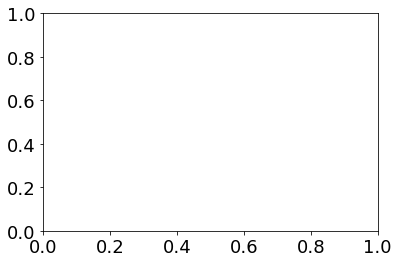

In [5]:
plt.rcParams.update({'font.size': 16})
plt.tick_params(axis='both', which='major', labelsize=18)
fig_size = plt.rcParams["figure.figsize"]
fig_size = [15, 7]
plt.rcParams["figure.figsize"] = fig_size

<a id="preprocessing"></a>
# Data Pre-processing
This section aggregates code to load data, definitions of functions used to pre-process data, and code to prepare data.

<a id="dataframes"></a>
## DataFrames Creation
In this section we load dataset file from and create DataFrame instances for the districts from corresponding tabs in the file.

In [6]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([auth_url, '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': username,'domain': {'id': domain_id},
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url)

The next section defines the dataset to be analyzed: for each site we define a list of files to be loaded and processed. When new data is available, add the files in the corresponding lists.

In [7]:
files_Chanhumba = ['Tanzania Transaction logs - Chanhumba.xlsx']
files_Busiro = ['Uganda Transaction logs - Busiro.xlsx']
files_Kikondo = ['Uganda Transaction logs - Kikondo.xlsx']
files_Dei = ['Uganda Transaction logs - Dei.xlsx']

sheet_name = 'Transaction log' # name of the tab, that contains transaction data

The readFiles function loads files from the specified list and returns a single DataFrame object with aggregated data.

In [8]:
def readFiles(files):
    frames = []
    for file in files:
        xls = pd.ExcelFile(get_file_content(file))
        frames.append(xls.parse(sheet_name, convert_float=True))
    return pd.concat(frames)

In [9]:
waterUsageRDD_Kikondo = readFiles(files_Kikondo)
waterUsageRDD_Busiro = readFiles(files_Busiro)
waterUsageRDD_Dei = readFiles(files_Dei)
waterUsageRDD_Chanhumba = readFiles(files_Chanhumba)

<a id="section3"></a>
## Functions
This section defines functions used for data pre-processing.

In [10]:
def getCardDataByDistrict(district):
    if(district == 'Busiro'):
        return waterUsageDF_Busiro
    if(district == 'Kikondo'):
        return waterUsageDF_Kikondo
    if(district == 'Dei'):
        return waterUsageDF_Dei    
    if(district == 'Chanhumba'):
        return waterUsageDF_Chanhumba

In [11]:
def movingAverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    
    data = []
    values_sum = 0
      
    if(window > len(values)):
        smas = np.convolve(values, weights, 'same')
        return smas[:len(values)]
        
    for i in range (0,window-1):
        values_sum = values_sum + values[i]
        value = values_sum / (i+1)
        data.append(value)
    
    for i in sma:
        data.append(i)
        
    return data

def trimInitialWeeks(pdf, numOfWeeks):
    minyear = np.min(pdf['isoyear'])
   
    minweek = np.min(pdf[pdf.isoyear == minyear].isoweek)
    
    maxweek = np.max(pdf[pdf.isoyear == minyear].isoweek)
   
    if (maxweek - minweek > numOfWeeks):
        pdf = pdf[((pdf.isoyear == minyear)&(pdf.isoweek >= minweek + numOfWeeks)) | (pdf.isoyear > minyear)]
        size = len(pdf)
        pdf.index = range(0, size)
    else:
        print ('Need to handle situation with year changed')
    
    return pdf

def loadWaterTransactionData(initial_df):
    df = initial_df.copy()
    if(df['Date and time'].dtype != 'datetime64[ns]'):
        df['Date and time'] = df['Date and time'].str.slice(0,10).str.replace('-', '.')
        df['Date and time'] = pd.to_datetime(df['Date and time'], format='%d.%m.%Y')
    else:
        df['Date and time'] = df['Date and time'].dt.date
#    if(df['Smartcard 1'].dtype != 'object'):
#        df['Smartcard 1'] = df['Smartcard 1'].astype(str).str.replace('.0','')    
    df = df[(df['Smartcard 1'].str.contains(pattern) != True) & (df['Smartcard 1'] != '')]  
    df = df[df['Operation'] == 'Water dispensed']
    df['Smartcard 1'] = df['Smartcard 1'].astype(int)
    df = df[~df['Smartcard 1'].isin({1603, 1604, 1605, 2281, 2283, 2284, 2291, 2292, 2954})]
    df = df[['Transaction id', 'Date and time', 'Smartcard 1', 'Water dispensed', 'Credits', 'Balance', 'Operation', 'Dispenser']]
    df['year'] = pd.DatetimeIndex(df['Date and time']).year
    df['month'] = pd.DatetimeIndex(df['Date and time']).month
    df['day'] = pd.DatetimeIndex(df['Date and time']).day
    df['isoyear'] = pd.DatetimeIndex(df['Date and time']).year
    df['isoweek'] = pd.DatetimeIndex(df['Date and time']).week
    df['weekday'] = pd.DatetimeIndex(df['Date and time']).weekday
    df.columns = ['transaction', 'date', 'smartcard', 'amount', 'credits', 'balance', 'operation', 'dispenser', 'year', 'month', 'day', 'isoyear', 'isoweek', 'weekday']
    
    return df


def prepareTransactionData(initial_df):
    df = loadWaterTransactionData(initial_df)
    
    byday1 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.sum()
    byday2 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).smartcard.nunique()
    byday3 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.count()
    byday = pd.concat([byday1, byday2, byday3], axis = 1).reset_index()
    byday.columns = ['isoyear', 'isoweek', 'date', 'weekday', 'amount', 'smartcards', 'transactions'] 
    byday['amount_per_card'] = byday.amount / byday.smartcards
  
    # calc the last date
    last_date = np.max(df.date)
    card_last_day = df.groupby(['smartcard']).date.max().reset_index()
    card_last_day.columns = ['smartcard', 'last_date']
    # update last date for 'non-stopped' cards
    card_last_day['last_date'] = card_last_day['last_date'].apply(adjustDate, args=(last_date, 28))
    
    total_num = len(df.smartcard.drop_duplicates())
    pdf = byday
    # add number of non-stopped cards into dataframe
    pdf['active_cards'] = 0
    pdf['inactive_cards'] = 0
    pdf['amount_per_active_card'] = 0
    for i in pdf.index:
        row = pdf.ix[i]
        active_num = card_last_day[(card_last_day.last_date >= row.date)].smartcard.count()
        pdf.ix[i, 'active_cards'] = active_num
        pdf.ix[i, 'inactive_cards'] = total_num - active_num
        pdf.ix[i, 'amount_per_active_card'] = row.amount / active_num
    
    return pdf

def prepareDispenserTransactionData(initial_df):
    w = loadWaterTransactionData(initial_df)
    
    byday1 = w.groupby(['dispenser', 'isoyear', 'isoweek', 'date']).amount.sum()
    byday2 = w.groupby(['dispenser', 'isoyear', 'isoweek', 'date']).smartcard.nunique()
    byday3 = w.groupby(['dispenser', 'isoyear', 'isoweek', 'date']).amount.count()
    
    byday = pd.concat([byday1, byday2, byday3], axis = 1).reset_index()
            
    byday.columns = ['dispenser', 'isoyear', 'isoweek', 'date', 'amount', 'smartcards', 'transactions'] 
    byday['amount_per_card'] = byday.amount / byday.smartcards
    
    return byday.fillna(0)

In [12]:
def getCardCountPercentage(x):
    district = x[0]
    count = x[2]
    if district == 'Busiro':
        return count / busiroCardCount * 100
    if district == 'Kikondo':
        return count / kikondoCardCount * 100
    if district == 'Dei':
        return count / deiCardCount * 100
    if district == 'Chanhumba':
        return count / chanhumbaCardCount * 100
    return 0

In [13]:
def getCardGroup(x):
    district = x[0]
    card = x[1]
    if((district == 'Busiro') & ((card == '1834') | (card == '1950') | (card == '2929'))):
        return 'Creditor'
    if((district == 'Kikondo') & (card == '2289')):
        return 'Creditor'
    if((district == 'Dei') & (card == '15200')):
        return 'Creditor'
    multiTrans = x[2] 
    oneTrans = x[3] 
    multiTrip = x[4] 
    summa = multiTrans + oneTrans + multiTrip
    multiTrans = multiTrans / summa * 100 
    oneTrans = oneTrans / summa * 100 
    multiTrip = multiTrip / summa * 100 
    
    if((multiTrans == 0) & (oneTrans - multiTrip > 30)):
        return 'oneTrans'
    if((multiTrans == 0) & (multiTrip - oneTrans > 30)):
        return 'multiTrip'
    if((multiTrip == 0) & (oneTrans - multiTrans > 30)):
        return 'oneTrans'
    if((multiTrip == 0) & (multiTrans - oneTrans > 30)):
        return 'multiTrans'
    if((oneTrans == 0) & (multiTrip - multiTrans > 30)):
        return 'multiTrip'
    if((oneTrans == 0) & (multiTrans - multiTrip > 30)):
        return 'multiTrans'

    if((multiTrans > 0) & (oneTrans - multiTrip > 25)):
        return 'oneTrans'
    if((multiTrans > 0) & (multiTrip - oneTrans > 25)):
        return 'multiTrip'
    if((multiTrip > 0) & (oneTrans - multiTrans > 25)):
        return 'oneTrans'
    if((multiTrip > 0) & (multiTrans - oneTrans > 25)):
        return 'multiTrans'
    if((oneTrans > 0) & (multiTrip - multiTrans > 25)):
        return 'multiTrip'
    if((oneTrans > 0) & (multiTrans - multiTrip > 25)):
        return 'multiTrans'

    if(multiTrans >= 50):
        return 'multiTrans'
    if(oneTrans >= 50):
        return 'oneTrans'
    if(multiTrip >= 50):
        return 'multiTrip'
    if(multiTrans < 25):
        if(oneTrans > multiTrip):
            return 'oneTrans'
        else:
            return 'multiTrip'
    if(multiTrip < 25):
        if(oneTrans > multiTrans):
            return 'oneTrans'
        else:
            return 'multiTrans'
    if(oneTrans < 25):
        if(multiTrip > multiTrans):
            return 'multiTrip'
        else:
            return 'multiTrans'
    
    return 'NA'

In [14]:
def printTransactionIntervalAnalysisAllDistricts(districts):
    N = 16
    ind = np.arange(N)
    width = 0.2
    labels = []
    fig, ax = plt.subplots()
    
    for i in range(0, len(districts)):
        shift = 0
        districtColor = 'b'
        if (i > 0):
            shift += shift + i * width
            if (i == 1):
                districtColor = 'g'
            elif(i == 2):
                districtColor = 'r'
            else:
                districtColor = 'y'
            
        data = timeDiffDF_multiTransaction_groupped[timeDiffDF_multiTransaction_groupped.District == districts[i]]
        labels = data.Group
        data.Smartcard_1 = data.Smartcard_1 / data.Smartcard_1.sum() * 100
        ax.bar(ind + shift, data.Smartcard_1, width, color = districtColor) 
    ax.set_xlabel("Interval between transactions")
    ax.set_ylabel("Percentage of total transactions")
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation=90, horizontalalignment='left')
    ax.legend(districts)
    plt.title('Transaction Interval analysis')
    plt.margins(0.02)

In [15]:
def printTransactionTypeAnalysisPercentageAllDistricts(districts):
    N = 3
    ind = np.arange(N)
    width = 0.2
    labels = []
    fig, ax = plt.subplots()
    
    for i in range(0, len(districts)):
        shift = 0
        districtColor = 'b'
        if (i > 0):
            shift += shift + i * width
            if (i == 1):
                districtColor = 'g'
            elif(i == 2):
                districtColor = 'r'
            else:
                districtColor = 'y'
            
        data = timeDiffDF_grouppedTransactions[timeDiffDF_grouppedTransactions.District == districts[i]]
        labels = data.Group
        ax.bar(ind + shift, data.Percentage, width, color = districtColor) 
    ax.set_xlabel("Transaction type")
    ax.set_ylabel("Transactions")
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, horizontalalignment='left')
    ax.legend(districts)
    plt.title('Transaction Type analysis - Percentage')
    plt.margins(0.02)

In [16]:
def getIntervalGroup(x):
    if (x >= 4) & (x < 10):
        return '4-10'
    if (x >= 10) & (x < 20):
        return '10-20'
    if (x >= 20) & (x < 30):
        return '20-30'
    if (x >= 30) & (x < 40):
        return '30-40'
    if (x >= 40) & (x < 50):
        return '40-50'
    if (x >= 50) & (x < 60):
        return '50-1h'
    if (x >= 60) & (x < 120):
        return '1h-2h'
    if (x >= 120) & (x < 240):
        return '2h-4h'
    if (x >= 240) & (x < 360):
        return '4h-6h'
    if (x >= 360) & (x < 480):
        return '6h-8h'
    if (x >= 480) & (x < 600):
        return '8h-10h'
    if (x >= 600):
        return '>10h'
      
    return x 

In [17]:
def getPercentage(x):
    district = x[0]
    count = x[2]
    if district == 'Busiro':
        return count / busiroMultipleTransactions * 100
    if district == 'Kikondo':
        return count / kikondoMultipleTransactions * 100
    if district == 'Dei':
        return count / deiMultipleTransactions * 100
    if district == 'Chanhumba':
        return count / chanhumbaMultipleTransactions * 100
    return 0

In [18]:
def getOperationGroup(x):
    if(x < 30):
        return 'multiple transactions'
    return 'multiple trip'

In [19]:
def getTimeDiff(x):
    d1 = x[3]
    d2 = x[4]
    d3 = x[5]
    if(pd.notnull(d2)):
        return d1 - d2
    if(pd.notnull(d3)):
        return d3 - d1
    return d2

def getTimeDiff2(x):
    d1 = x[3]
    d2 = x[4]
    d3 = x[5]
    return d3 - d1

In [20]:
def getAverageWaterPerDay(district):
    return pd.merge(hours, resultsetByHours[resultsetByHours.District == district],  on=['Hour'], how = 'outer').fillna(0).AverageWaterPerDay


def getAverageWaterPerDayByDispenser(dispenser):
    return pd.merge(hours, resultsetByHours_Dispenser[resultsetByHours_Dispenser.Dispenser == dispenser],  on=['Hour'], how = 'outer').fillna(0).AverageWaterPerDay


def getAverageTransactionsPerDay(district):
    return pd.merge(hours, resultsetByHours[resultsetByHours.District == district],  on=['Hour'], how = 'outer').fillna(0).AverageTransactionsPerDay


def getAverageTransactionsPerDayDispenser(district):
    return pd.merge(hours, resultsetByHours_Dispenser[resultsetByHours_Dispenser.District == district],  on=['Hour'], how = 'outer').fillna(0).AverageTransactionsPerDay

def changeHour2(x):
    if x < 6: 
        return 'Yearly hours'
    if x > 18:
        return 'Late hours'
    return str(x) + '.00'

def changeHour1(x):
    if x < 6: 
        return 0
    if x > 18:
        return 23
    return x

def changeDay(x):
    if x == 0: 
        return 'Mon'
    if x == 1: 
        return 'Tue'
    if x == 2: 
        return 'Wed'
    if x == 3: 
        return 'Thu'
    if x == 4: 
        return 'Fri'
    if x == 5: 
        return 'Sat'
    if x == 6: 
        return 'Sun'
    return x

In [21]:
def movingAverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    
    data = []
    values_sum = 0
      
    if(window > len(values)):
        smas = np.convolve(values, weights, 'same')
        return smas[:len(values)]
        
    for i in range (0,window-1):
        values_sum = values_sum + values[i]
        value = values_sum / (i+1)
        data.append(value)
    
    for i in sma:
        data.append(i)
        
    return data

def getCardData(card, district):
    if(district == 'Busiro'):
        d = waterUsageDF_Busiro[waterUsageDF_Busiro.Smartcard_1 == card]
    if(district == 'Kikondo'):
        d = waterUsageDF_Kikondo[waterUsageDF_Kikondo.Smartcard_1 == card]
    if(district == 'Dei'):
        d = waterUsageDF_Dei[waterUsageDF_Dei.Smartcard_1 == card]
    if(district == 'Chanhumba'):
        d = waterUsageDF_Chanhumba[waterUsageDF_Chanhumba.Smartcard_1 == card]
    
    d.Water_dispensed = d.Water_dispensed.astype(float)
    res1=d.groupby(['Date']).Water_dispensed.sum().reset_index()
    res2=d.groupby(['Date']).Balance.min().reset_index()
    res = res1.merge(res2)
    
    from datetime import datetime
    delta = d.Date.max() - d.Date.min()
    emptyDB = pd.DataFrame(index=pd.date_range(d.Date.min(), periods=delta.days), columns=['Date', 'Water_dispensed', 'Balance'])
    emptyDB.Date = pd.date_range(d.Date.min(), periods=delta.days)
    emptyDB.Water_dispensed = 0
    emptyDB.Balance = 0

    r = pd.concat([emptyDB, res.set_index('Date', drop=False)], ignore_index=True, join='outer')
    r['Date'] = pd.to_datetime(r['Date'])
    
    result1 = r.groupby(['Date']).Water_dispensed.sum().reset_index()
    result2 = r.groupby(['Date']).Balance.max().reset_index()
    result = result1.merge(result2)
    x = [1.0]
    for row in result.itertuples():
        if(row[3] == 0):
            d = result[(result.Date <= row[1]) & (result.Balance > 0)]
            x.append(d[d.Date == d.Date.max()].Balance.max())
        else:
            x.append(row[3])    
       
    result['DayBalance'] = x[1:]
    result['MA10'] = movingAverage(result.Water_dispensed,10)
    return result.fillna(0)

def getCardDataFromDistrict(district):
    if(district == 'Busiro'):
        d = waterUsageDF_Busiro
    if(district == 'Kikondo'):
        d = waterUsageDF_Kikondo
    if(district == 'Dei'):
        d = waterUsageDF_Dei
    if(district == 'Chanhumba'):
        d = waterUsageDF_Chanhumba
    
    d.Water_dispensed = d.Water_dispensed.astype(float)
    res1=d.groupby(['Date']).Water_dispensed.sum().reset_index()
    res2=d.groupby(['Date']).Balance.min().reset_index()
    res = res1.merge(res2)
    
    from datetime import datetime
    delta = d.Date.max() - d.Date.min()
    emptyDB = pd.DataFrame(index=pd.date_range(d.Date.min(), periods=delta.days), columns=['Date', 'Water_dispensed', 'Balance'])
    emptyDB.Date = pd.date_range(d.Date.min(), periods=delta.days)
    emptyDB.Water_dispensed = 0
    emptyDB.Balance = 0

    r = pd.concat([emptyDB, res.set_index('Date', drop=False)], ignore_index=True, join='outer')
    
    result1 = r.groupby(['Date']).Water_dispensed.sum().reset_index()
    result2 = r.groupby(['Date']).Balance.max().reset_index()
    result = result1.merge(result2)
    x = [1.0]
    for row in result.itertuples():
        if(row[3] == 0):
            d = result[(result.Date <= row[1]) & (result.Balance > 0)]
            x.append(d[d.Date == d.Date.max()].Balance.max())
        else:
            x.append(row[3])    
       
    result['DayBalance'] = x[1:]
    result['MA10'] = movingAverage(result.Water_dispensed,10)
    return result.fillna(0)
    

In [22]:
    def getDayOfWeekData(district):
        return resultsetByDayOfWeek_Dispenser[resultsetByDayOfWeek_Dispenser.District == district]
    def getDayOfWeekHourData(district):
        return resultsetByDayOfWeekHour[resultsetByDayOfWeekHour.District == district].reset_index(drop=True)

In [23]:
def getCardsByDistrict_forReport(district):
    df = resultset
    if(district == 'Busiro'):
        df = resultset[(resultset.District == 'Busiro') & (resultset.Status == 'Stopped without credits')]
    if(district == 'Kikondo'):
        df =  resultset[(resultset.District == 'Kikondo') & (resultset.Status == 'Stopped without credits')]
    if(district == 'Dei'):
        df =  resultset[(resultset.District == 'Dei') & (resultset.Status == 'Stopped without credits')]
    if(district == 'Chanhumba'):
        df =  resultset[(resultset.District == 'Chanhumba') & (resultset.Status == 'Stopped without credits')]
    df = df[['Smartcard_1', 'First_Usage_Date']].drop_duplicates().sort_values(['First_Usage_Date'], ascending = [True])
    return list(df[:5].Smartcard_1)

In [24]:
# get max interval between transactions (use for stopped cards determining)
def calculateInterval(card, district):
    percentage = 5
    data = cardsHistory[cardsHistory.District == district]
    cardData = data[data.Smartcard_1 == card]
     
    initAr = list(cardData.Date)

    ar = (len(initAr) - 1) * [0]
    
    for index in range(len(initAr) - 1):
        ar[index] = (initAr[index+1] - initAr[index]).days
    ar.sort()
    
    values = 2
    if(len(ar) * percentage / 100) > 2:
        values = int(round(len(ar) * percentage / 100) )
    
    if(values > len(ar)):
        values = len(ar)
    
    if(values  == 0):
        maxIntervalOfUsage = 0
    else:
        maxIntervalOfUsage = round(sum(ar[-values:])/values)
    
    if(maxIntervalOfUsage > 0):
        if(maxIntervalOfUsage < 30):
            maxIntervalOfUsage = 30
    
    return maxIntervalOfUsage

def getInterval(x):
    card = x[0] 
    district = x[1] 
    return calculateInterval(card, district)

def findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge):
    res = 'Running'
    if ((endDate - lastUsageDate).days > interval):
        if (float(lastBalance) > balanceLowerEdge):
            res = 'Stopped with credits'
        else:
            res = 'Stopped without credits'
    return res

# get card status: Running, stopped with credits or stopped without credits 
def getStatus(x):
    card = x[0] 
    district = x[1] 
    endDate = x[2]
    lastUsageDate = x[3]
    lastBalance = x[4]
    interval = x[5]
    return findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge)

# find how many times card was renewed, what is the average amount of deposit, min balance before deposit and average balance before deposit 
def getCreditInfoByDistrict(district):
    data = getCardDataByDistrict(district)    
    data.Balance = data.Balance.astype(float).fillna(0)
    data.Credits = data.Credits.astype(float).abs().fillna(0)
    d1 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Balance.min().reset_index()
    d2 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Credits.sum().reset_index()
    df = pd.merge(d1, d2, on = ['Smartcard_1','Date', 'Date_and_time'])
    df.Date_and_time = pd.to_datetime(df.Date_and_time)
    df = df.sort_values(['Smartcard_1','Date', 'Date_and_time'], ascending=[True, True, True])
    df['Balance_diff'] = df.groupby('Smartcard_1')['Balance'].diff().fillna(0)
    df = df[(df.Balance_diff > 0)]
    df.Credits = df.Credits + df.Balance_diff
    df['Balance_prev'] = df.Balance - df.Balance_diff
    prevMin = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].min()
    prevAve = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].mean()
    count = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_diff'].count()
    ave = df[df.Balance_diff > 0].groupby('Smartcard_1')['Credits'].mean()
    result = pd.concat([count, ave, prevMin, prevAve], axis = 1).reset_index()
    result = result.fillna(0)
    result.columns = ['Smartcard_1', 'Credits_Add', 'Add_Credits_Mean', 'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean']
    return result

In [25]:
def creditGroup(y):
    x = abs(y)
    if (x >= 0) & (x < 25):
        return 1
    if (x >= 25) & (x < 50):
        return 2
    if (x >= 50) & (x < 75):
        return 3
    if (x >= 75) & (x < 100):
        return 4
    if (x >= 100) & (x < 125):
        return 5
    if (x >= 125) & (x < 150):
        return 6
    if (x >= 150) & (x < 175):
        return 7
    if (x >= 175) & (x < 200):
        return 8
    if (x >= 200) & (x < 225):
        return 9
    if (x >= 225) & (x < 250):
        return 10
    if (x >= 250) & (x < 275):
        return 11
    if (x >= 275) & (x < 300):
        return 12
    if (x >= 300):
        return 13
  
    return 0

In [26]:
def renewBalanceGroup(x):
    if (x >= 0) & (x < 200):
        return 1
    if (x >= 200) & (x < 400):
        return 2
    if (x >= 400) & (x < 600):
        return 3
    if (x >= 600) & (x < 800):
        return 4
    if (x >= 800) & (x < 1000):
        return 5
    if (x >= 1000) & (x < 1200):
        return 6
    if (x >= 1200):
        return 7
  
    return 0

<a id="section4"></a>
## Data preparation

Remove rows with empty 'Smartcard 1' values, drop duplicates, convert date and time, add district name

In [27]:
waterUsageRDD_Chanhumba.dtypes

Transaction id              int64
Date and time      datetime64[ns]
Dispenser                  object
Operation                  object
Smartcard 1               float64
Smartcard 2               float64
Water dispensed           float64
Credits                   float64
Balance                   float64
Total created             float64
dtype: object

In [28]:
waterUsageRDD_Chanhumba

Transaction id       Date and time   Dispenser        Operation  \
0               14337 2017-06-14 15:07:38    Arusha B       No changes   
1               14336 2017-06-14 15:07:24    Arusha B       No changes   
2               14335 2017-06-14 15:07:16    Arusha B       No changes   
3                9292 2017-06-14 15:03:28     Nyerere  Water dispensed   
4                9291 2017-06-14 14:30:39     Nyerere  Water dispensed   
5                9290 2017-06-14 14:27:11     Nyerere  Water dispensed   
6                9289 2017-06-14 14:23:28     Nyerere       No changes   
7                9288 2017-06-14 14:23:18     Nyerere  Water dispensed   
8               14334 2017-06-14 14:21:37    Arusha B       No changes   
9               14333 2017-06-14 14:21:32    Arusha B       No changes   
10              14332 2017-06-14 14:21:17    Arusha B       No changes   
11              14331 2017-06-14 14:21:10    Arusha B       No changes   
12              14330 2017-06-14 14:21:00    Arusha B       No changes   
13              14329 2017-06-14 14:20:52    Arusha B       No changes   
14              14328 2017-06-14 14:13:19    Arusha B       No changes   
15              14327 2017-06-14 14:12:59    Arusha B       No changes   
16              14326 2017-06-14 14:12:13    Arusha B       No changes   
17               3515 2017-06-14 14:10:20    Zahanati  Water dispensed   
18              14325 2017-06-14 14:03:36    Arusha B       No changes   
19              14324 2017-06-14 13:56:40    Arusha B       No changes   
20              14323 2017-06-14 13:56:35    Arusha B       No changes   
21              14322 2017-06-14 13:56:28    Arusha B       No changes   
22              14321 2017-06-14 13:56:23    Arusha B       No changes   
23              14320 2017-06-14 13:56:03    Arusha B       No changes   
24              14319 2017-06-14 13:51:52    Arusha B       No changes   
25              14318 2017-06-14 13:51:48    Arusha B       No changes   
26              14317 2017-06-14 13:48:26    Arusha B       No changes   
27               3514 2017-06-14 13:41:19    Zahanati  Water dispensed   
28               3513 2017-06-14 13:40:36    Zahanati  Water dispensed   
29              14316 2017-06-14 13:40:07    Arusha B       No changes   
...               ...                 ...         ...              ...   
26946            6291 2017-05-01 07:10:06    Arusha B       No changes   
26947            3591 2017-05-01 06:53:37      Iringa       No changes   
26948            2819 2017-05-01 06:48:56  Chang'ombe       No changes   
26949            2818 2017-05-01 06:48:50  Chang'ombe       No changes   
26950            6290 2017-05-01 06:43:35    Arusha B       No changes   
26951            2817 2017-05-01 06:40:36  Chang'ombe       No changes   
26952            2426 2017-05-01 06:40:18     Nyerere       No changes   
26953            3590 2017-05-01 06:35:59      Iringa       No changes   
26954            2816 2017-05-01 06:32:14  Chang'ombe       No changes   
26955            3589 2017-05-01 06:27:22      Iringa       No changes   
26956            3588 2017-05-01 06:27:16      Iringa       No changes   
26957            3587 2017-05-01 06:26:42      Iringa       No changes   
26958            2815 2017-05-01 06:03:21  Chang'ombe       No changes   
26959            2814 2017-05-01 06:03:18  Chang'ombe       No changes   
26960            2813 2017-05-01 06:03:10  Chang'ombe       No changes   
26961            2425 2017-05-01 05:56:49     Nyerere       No changes   
26962            3586 2017-05-01 05:56:43      Iringa       No changes   
26963            2424 2017-05-01 05:56:30     Nyerere       No changes   
26964            3585 2017-05-01 05:56:03      Iringa       No changes   
26965            3584 2017-05-01 05:50:49      Iringa       No changes   
26966            3583 2017-05-01 05:49:35      Iringa       No changes   
26967            2423 2017-05-01 05:41:39     Nyerere       No changes   
26968      

In [29]:
def cleanData(waterUsageDF, districtName):
    waterUsageDF = waterUsageDF[~waterUsageDF['Smartcard 1'].isnull()]
    if(waterUsageDF['Smartcard 1'].dtype != 'object'):
        waterUsageDF['Smartcard 1'] = waterUsageDF['Smartcard 1'].astype(int).astype(str)   
    waterUsageDF_2 = waterUsageDF[(waterUsageDF['Smartcard 1'].str.contains(pattern) != True) & (waterUsageDF['Smartcard 1'] != '')]
    waterUsageDF_2.columns = ['Transaction_id','Date_and_time','Dispenser','Operation','Smartcard_1','Smartcard_2','Water_dispensed','Credits','Balance','Total_created']
    waterUsageDF_2 = waterUsageDF_2.drop_duplicates().reset_index(drop=True)
    
    waterUsageDF_2.Date_and_time = pd.to_datetime(waterUsageDF_2.Date_and_time, format='%d-%m-%Y %H:%M:%S')
    waterUsageDF_2['Date'] = waterUsageDF_2.Date_and_time.dt.date
    waterUsageDF_2.Date = pd.to_datetime(waterUsageDF_2.Date, format='%Y-%m-%d')
    
    waterUsageDF_2['District'] = districtName
    
    return waterUsageDF_2

In [30]:
waterUsageDF_Busiro = cleanData(waterUsageRDD_Busiro, 'Busiro')
waterUsageDF_Kikondo = cleanData(waterUsageRDD_Kikondo, 'Kikondo')
waterUsageDF_Dei = cleanData(waterUsageRDD_Dei, 'Dei')
waterUsageDF_Chanhumba = cleanData(waterUsageRDD_Chanhumba, 'Chanhumba')

In [31]:
waterUsageDF_Chanhumba.dtypes

Transaction_id              int64
Date_and_time      datetime64[ns]
Dispenser                  object
Operation                  object
Smartcard_1                object
Smartcard_2               float64
Water_dispensed           float64
Credits                   float64
Balance                   float64
Total_created             float64
Date               datetime64[ns]
District                   object
dtype: object

Let's move transactions for 'vendor' cards into a separate set, and remove them from the dataset

In [32]:
vendor_cards = {'1604', '1605', '2281', '2283', '2284', '2291', '2292', '2954'}
vendors = waterUsageDF_Kikondo[waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)] 
vendors = vendors.append(waterUsageDF_Busiro[waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)])

waterUsageDF_Busiro = waterUsageDF_Busiro[~waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)] 
waterUsageDF_Kikondo = waterUsageDF_Kikondo[~waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)]

Save datasets with all types of operation for future

In [33]:
waterUsageDF_Busiro_allOperations = waterUsageDF_Busiro
waterUsageDF_Kikondo_allOperations = waterUsageDF_Kikondo
waterUsageDF_Dei_allOperations = waterUsageDF_Dei
waterUsageDF_Chanhumba_allOperations = waterUsageDF_Chanhumba

allOperations = waterUsageDF_Busiro_allOperations.append(waterUsageDF_Kikondo_allOperations).append(waterUsageDF_Dei).append(waterUsageDF_Chanhumba).append(vendors)
allOperations = allOperations[~allOperations.Smartcard_1.isnull()]

Let's remove from from the dataset all operations different to Water dispensed, and further clean the data

In [34]:
def cleanData2(waterUsageDF):
    waterUsageDF = waterUsageDF[(waterUsageDF.Operation == 'Water dispensed')]
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.replace(to_replace='.0', value='', regex=False)
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.astype(int).astype(str)
    waterUsageDF = waterUsageDF[(waterUsageDF.Smartcard_1 != '')]
    return waterUsageDF

In [35]:
waterUsageDF_Busiro = cleanData2(waterUsageDF_Busiro)
waterUsageDF_Kikondo = cleanData2(waterUsageDF_Kikondo)
waterUsageDF_Dei = cleanData2(waterUsageDF_Dei)
waterUsageDF_Chanhumba = cleanData2(waterUsageDF_Chanhumba)


Clean the aggregated data as well

In [36]:
allOperations.Smartcard_1 = allOperations.Smartcard_1.replace(to_replace='.0', value='', regex=False)
allOperations.Smartcard_2 = allOperations.Smartcard_2.replace(to_replace='.0', value='', regex=False)

allOperations.Smartcard_1 = allOperations.Smartcard_1.astype(int).astype(str)

allOperations = allOperations[(allOperations.Smartcard_1 != '')]

Prepare data related to credits

In [37]:
def prepareCreditsData(waterUsageDF, districtName):
    credits = getCreditInfoByDistrict(districtName)
    result = pd.merge(waterUsageDF, credits, on='Smartcard_1', how='left')
    result['District'] = districtName
    result['EndDate'] = waterUsageDF.Date.max()
    return result

busiroResult = prepareCreditsData(waterUsageDF_Busiro, 'Busiro')
kikondoResult = prepareCreditsData(waterUsageDF_Kikondo, 'Kikondo')
deiResult = prepareCreditsData(waterUsageDF_Dei, 'Dei')
chanhumbaResult = prepareCreditsData(waterUsageDF_Chanhumba, 'Chanhumba')

In [38]:
result = pd.DataFrame(busiroResult.append(kikondoResult).append(deiResult).append(chanhumbaResult), 
                columns=['Transaction_id','Date','Date_and_time','EndDate','District','Dispenser','Smartcard_1','Water_dispensed',
                'Credits','Balance','Credits_Add','Add_Credits_Mean','Balance_Before_Credit_Min','Balance_Before_Credit_Mean'])

transaction_Count = result.groupby(['District','Smartcard_1'])['Transaction_id'].count().reset_index()
water_dispensed_Mean = result.groupby(['District','Smartcard_1'])['Water_dispensed'].mean().reset_index()
first_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].min().reset_index()
last_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].max().reset_index()

d1 = pd.merge(transaction_Count, water_dispensed_Mean, on=['District','Smartcard_1'], how='left')
d2 = pd.merge(first_Usage_Date, last_Usage_Date, on=['District','Smartcard_1'], how='left')
additionalDB = pd.merge(d1, d2, on=['District','Smartcard_1'], how='left')
additionalDB.columns = ['District', 'Smartcard_1', 'Transaction_Count', 'Water_dispensed_Mean', 'First_Usage_Date', 'Last_Usage_Date']
resultset = pd.merge(result, additionalDB, on=['District','Smartcard_1'], how='left')

In [39]:
cardData1 = allOperations.groupby(['District','Smartcard_1', 'Date']).Water_dispensed.sum()
cardData2 = allOperations.groupby(['District','Smartcard_1', 'Date']).Balance.min()
cardDataRes = pd.concat([cardData1, cardData2], axis = 1).reset_index()
cardsHistory = cardDataRes.sort_values(['District','Smartcard_1', 'Date'], ascending=[True,True,True]).reset_index(drop=True)

lastBalance = cardsHistory.groupby(['District','Smartcard_1']).Balance.last().reset_index()
lastBalance.columns = ['District','Smartcard_1','LastBalance']

cardsMaxInterval = pd.DataFrame(lastBalance, columns=['Smartcard_1', 'District'], index = lastBalance.index).drop_duplicates().reset_index(drop=True)
cardsMaxInterval.loc[:,'Interval'] = cardsMaxInterval.apply(getInterval, axis = 1)

resultset = pd.merge(resultset, lastBalance, on=['District','Smartcard_1'], how='left')
resultset = pd.merge(resultset, cardsMaxInterval, on=['District','Smartcard_1'], how='left')
resultset.LastBalance = resultset.LastBalance.astype(float)

#balanceLowerEdge = getbalanceLowerEdge()
balanceLowerEdge = 15

cardsStatus = pd.DataFrame(resultset, columns=['Smartcard_1', 'District', 'EndDate', 
                                               'Last_Usage_Date', 'LastBalance', 'Interval'], index = resultset.index).drop_duplicates().reset_index(drop=True)
cardsStatus.loc[:,'Status'] = cardsStatus.apply(getStatus, axis = 1)

In [40]:
resultset = pd.merge(resultset, cardsStatus, on=['Smartcard_1', 'District', 'EndDate', 'Last_Usage_Date', 'LastBalance', 'Interval'], how='left')
resultset.LastBalance = resultset.LastBalance.fillna(0)
resultset['CreditGroup'] = pd.Series(resultset.Credits, index=resultset.index).apply(creditGroup)

<a id="report"></a>
# Report Data Calculation

<a id="section1"></a>
## Section 11 - Stopped Cards


There are some cards which are stopped using by people in the communities. They may be lost, stolen cards or just useless for a time. We name all these cards 'Stopped'.

To find these cards we check the last usage date and if the card was used a month ago or longer we mark this card as 'Stopped'.
Then we check the current balance of the card and if the balance less than 2 shillings we mark this card as 'Stopped without credits', elsewhere we mark this card as 'Stopped with credits'.

In [41]:

allCards = resultset.groupby(['District']).Smartcard_1.nunique().reset_index()
allStoppedCards = resultset.groupby(['District', 'Status']).Smartcard_1.nunique().reset_index()
allStoppedCards = allStoppedCards[allStoppedCards.Status != 'Running']
allStoppedCards = allStoppedCards.pivot_table(
    values='Smartcard_1', index=['District'], columns=['Status'], aggfunc=np.sum, fill_value=0).reset_index()
allStoppedCards['Stopped cards'] = allStoppedCards['Stopped with credits'] + allStoppedCards['Stopped without credits']
allStoppedCards = pd.merge(allStoppedCards,allCards, on=['District'] )
allStoppedCards = allStoppedCards[['District', 'Smartcard_1', 'Stopped cards', 'Stopped without credits', 'Stopped with credits']]
allStoppedCards = allStoppedCards.append(allStoppedCards.sum(numeric_only=True), ignore_index=True)
allStoppedCards.ix[(allStoppedCards.District.isnull()),'District'] = 'All'
allStoppedCards.columns = ['District', 'Total number of cards', 'Stopped cards', 'Without credit', 'With credit']
allStoppedCards

District  Total number of cards  Stopped cards  Without credit  \
0     Busiro                  451.0          202.0            93.0   
1  Chanhumba                  367.0          105.0            12.0   
2        Dei                  133.0           57.0            31.0   
3    Kikondo                  200.0          105.0            48.0   
4        All                 1151.0          469.0           184.0   

   With credit  
0        109.0  
1         93.0  
2         26.0  
3         57.0  
4        285.0

average card with credits balance = 1098.0
                 never_renewed  renewed 0 or 1 times  \
all                2783.840000            978.437500   
with credits       4101.422105           1563.900000   
without credits       2.277778              2.666667   

                 renewed more than 2 times  
all                             123.453333  
with credits                    244.226667  
without credits                   2.680000  


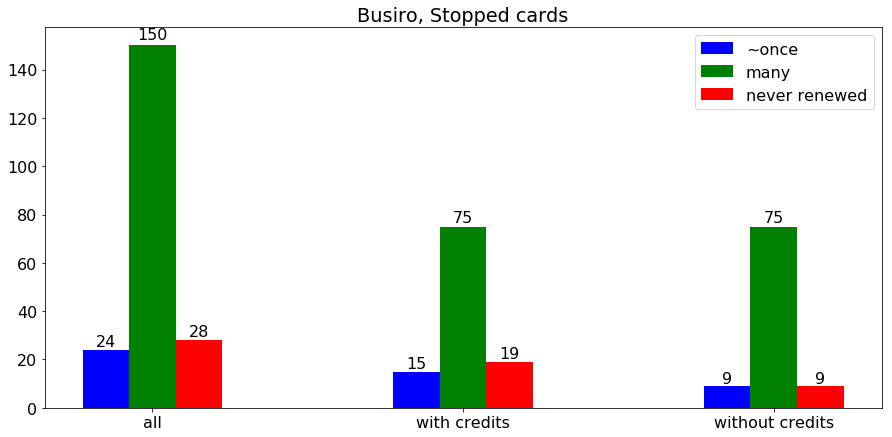

average card with credits balance = 1075.0
                 never_renewed  renewed 0 or 1 times  \
all                1736.060000            937.090909   
with credits       2670.534615           1471.928571   
without credits       0.607143              1.125000   

                 renewed more than 2 times  
all                             220.655405  
with credits                    439.155405  
without credits                   2.155405  


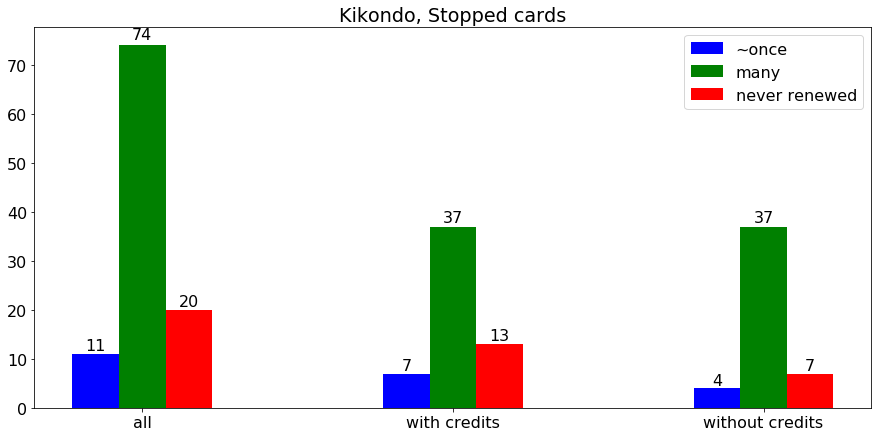

average card with credits balance = 16486.0
                 never_renewed  renewed 0 or 1 times  \
all               16435.204375             39983.375   
with credits      32869.096250             79964.500   
without credits       1.312500                 2.250   

                 renewed more than 2 times  
all                             157.527027  
with credits                    359.343750  
without credits                   3.761905  


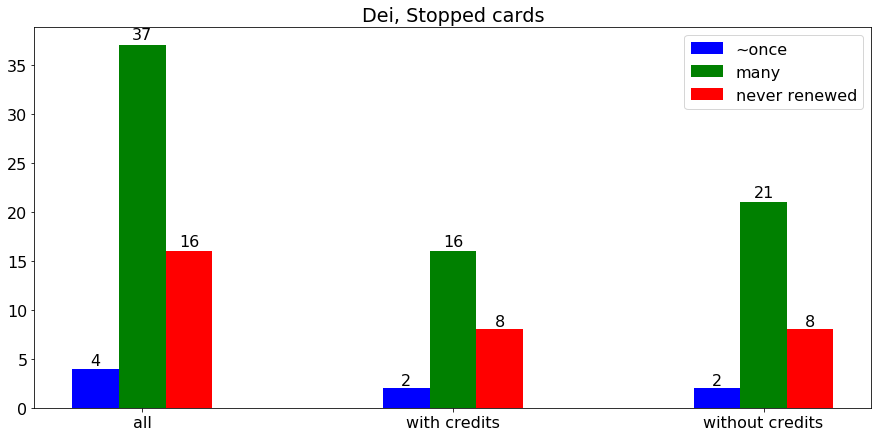

average card with credits balance = nan
                 never_renewed  renewed 0 or 1 times  \
all                 764.010101           1320.291667   
with credits        869.215517           1320.291667   
without credits       1.270833                   NaN   

                 renewed more than 2 times  
all                                    NaN  
with credits                           NaN  
without credits                        NaN  


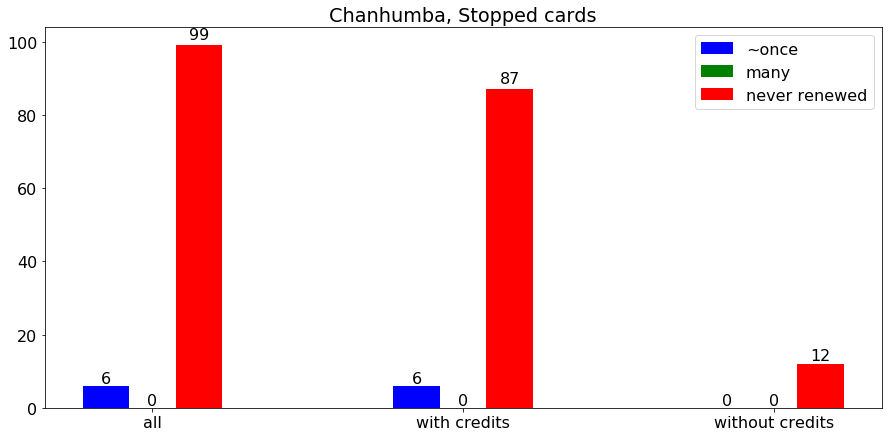

In [42]:
#4. Classify cards which stopped being used by the following criteria:
#- credits where never renewed
#- additional credits were added 0 or 1 time
#- additional credits were added 2 or more times

#@interact(district=['Busiro', 'Kikondo', 'Dei'])
def printCardsWithCredits(district):
#    district = 'Kikondo'
    stoppedCards = resultset[(resultset.Status != 'Running') & (resultset.District == district)]
    #- credits where never renewed
    stoppedCards1 = stoppedCards[pd.isnull(stoppedCards.Credits_Add)]
    stoppedCards1_Count = len(stoppedCards1.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards1_Mean = stoppedCards1.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    #- additional credits were added 0 or 1 time
    stoppedCards2 = stoppedCards[stoppedCards.Credits_Add < 3]
    stoppedCards2_Count = len(stoppedCards2.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards2_Mean = stoppedCards2.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    #- additional credits were added 0 or 1 time
    stoppedCards3 = stoppedCards[stoppedCards.Credits_Add > 2]
    stoppedCards3_Count = len(stoppedCards3.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards3_Mean = stoppedCards3.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    
    stoppedCardsWithCredits = stoppedCards[stoppedCards.Status == 'Stopped with credits']
    #- credits where never renewed
    stoppedCards1WithCredits = stoppedCardsWithCredits[pd.isnull(stoppedCardsWithCredits.Credits_Add)]
    stoppedCards1WithCredits_Count = len(stoppedCards1WithCredits.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards1WithCredits_Mean = stoppedCards1WithCredits.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    #- additional credits were added 0 or 1 time
    stoppedCards2WithCredits = stoppedCardsWithCredits[stoppedCardsWithCredits.Credits_Add < 3]
    stoppedCards2WithCredits_Count = len(stoppedCards2WithCredits.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards2WithCredits_Mean = stoppedCards2WithCredits.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    #- additional credits were added 0 or 1 time
    stoppedCards3WithCredits = stoppedCardsWithCredits[stoppedCardsWithCredits.Credits_Add > 2]
    stoppedCards3WithCredits_Count = len(stoppedCards3WithCredits.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards3WithCredits_Mean = stoppedCards3WithCredits.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    averageBalanceWithCredits = (stoppedCards1WithCredits_Count * stoppedCards1WithCredits_Mean + 
                      stoppedCards2WithCredits_Count * stoppedCards2WithCredits_Mean + 
                      stoppedCards3WithCredits_Count * stoppedCards3WithCredits_Mean ) / (stoppedCards1WithCredits_Count + stoppedCards2WithCredits_Count + stoppedCards3WithCredits_Count)
    stoppedCardsWithoutCredits = stoppedCards[stoppedCards.Status == 'Stopped without credits']
    #- credits where never renewed
    stoppedCards1WithoutCredits = stoppedCardsWithoutCredits[pd.isnull(stoppedCardsWithoutCredits.Credits_Add)]
    stoppedCards1WithoutCredits_Count = len(stoppedCards1WithoutCredits.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards1WithoutCredits_Mean = stoppedCards1WithoutCredits.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    #- additional credits were added 0 or 1 time
    stoppedCards2WithoutCredits = stoppedCardsWithoutCredits[stoppedCardsWithoutCredits.Credits_Add < 3]
    stoppedCards2WithoutCredits_Count = len(stoppedCards2WithoutCredits.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards2WithoutCredits_Mean = stoppedCards2WithoutCredits.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
    #- additional credits were added 0 or 1 time
    stoppedCards3WithoutCredits = stoppedCardsWithoutCredits[stoppedCardsWithoutCredits.Credits_Add > 2]
    stoppedCards3WithoutCredits_Count = len(stoppedCards3WithoutCredits.groupby(['District','Smartcard_1'])['Smartcard_1'].count())
    stoppedCards3WithoutCredits_Mean = stoppedCards3WithoutCredits.groupby(['District','Smartcard_1']).LastBalance.mean().reset_index().LastBalance.mean()
     
    d = [{'never_renewed': stoppedCards1_Count, 'renewed 0 or 1 times': stoppedCards2_Count, 'renewed more than 2 times': stoppedCards3_Count}, 
         {'never_renewed': stoppedCards1WithCredits_Count, 'renewed 0 or 1 times': stoppedCards2WithCredits_Count, 'renewed more than 2 times': stoppedCards3WithCredits_Count},
         {'never_renewed': stoppedCards1WithoutCredits_Count, 'renewed 0 or 1 times': stoppedCards2WithoutCredits_Count, 'renewed more than 2 times': stoppedCards3WithoutCredits_Count}
        ]
    df2 = pd.DataFrame(d, index=['all', 'with credits', 'without credits']);
    
    d_mean = [{'never_renewed': stoppedCards1_Mean, 'renewed 0 or 1 times': stoppedCards2_Mean, 'renewed more than 2 times': stoppedCards3_Mean}, 
         {'never_renewed': stoppedCards1WithCredits_Mean, 'renewed 0 or 1 times': stoppedCards2WithCredits_Mean, 'renewed more than 2 times': stoppedCards3WithCredits_Mean},
         {'never_renewed': stoppedCards1WithoutCredits_Mean, 'renewed 0 or 1 times': stoppedCards2WithoutCredits_Mean, 'renewed more than 2 times': stoppedCards3WithoutCredits_Mean}
        ]
    df2_mean = pd.DataFrame(d_mean, index=['all', 'with credits', 'without credits']);
    N = 3

    ind = np.arange(N)  # the x locations for the groups
    width = 0.15       # the width of the bars

    fig, ax = plt.subplots()

    little = (stoppedCards2_Count, stoppedCards2WithCredits_Count, stoppedCards2WithoutCredits_Count)
    rects1 = ax.bar(ind, little, width, color='b', align="center")
    
    many = (stoppedCards3_Count, stoppedCards3WithCredits_Count, stoppedCards3WithoutCredits_Count)
    rects2 = ax.bar(ind + width, many, width, color='g', align="center")
    
    never = (stoppedCards1_Count, stoppedCards1WithCredits_Count, stoppedCards1WithoutCredits_Count)
    rects3 = ax.bar(ind + 2 * width, never, width, color='r', align="center")

    ax.set_xticks(ind + width)
    ax.set_xticklabels(('all', 'with credits', 'without credits'))

    ax.legend((rects1[0], rects2[0], rects3[0]), ('~once', 'many', 'never renewed'))

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    print('average card with credits balance =' , round(averageBalanceWithCredits, 0))
    print(df2_mean)
    plt.title(district + ', Stopped cards')
    plt.show()
    return df2_mean

for district in ['Busiro', 'Kikondo', 'Dei', 'Chanhumba']:
    printCardsWithCredits(district)

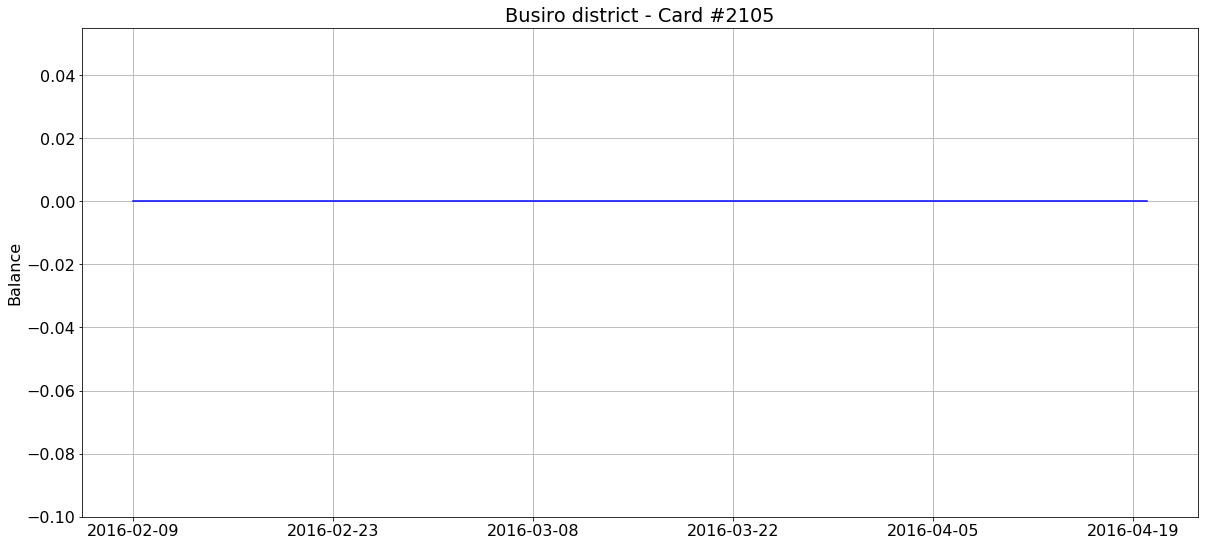

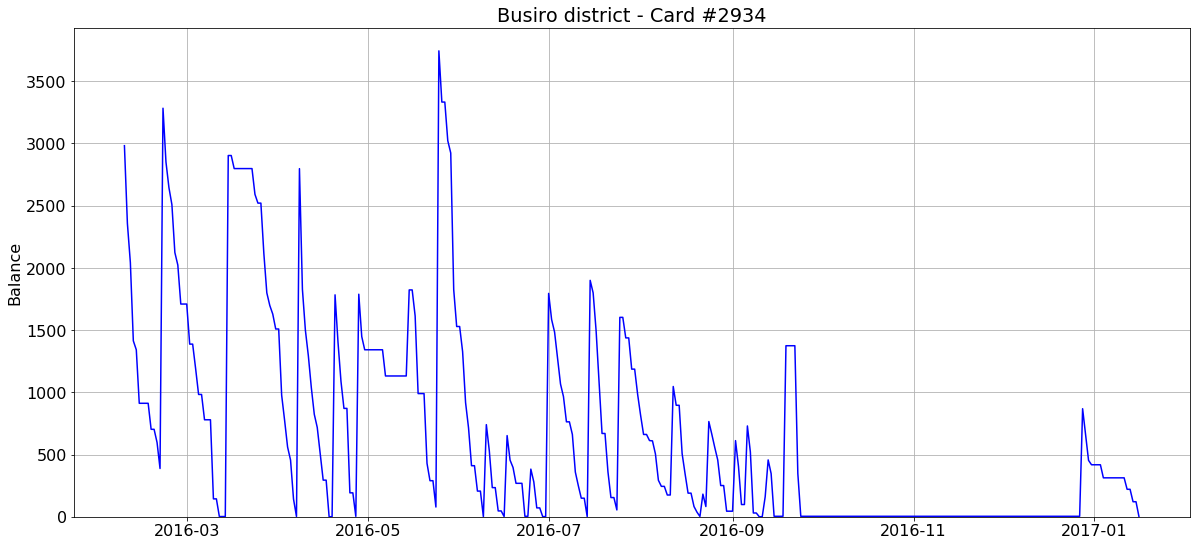

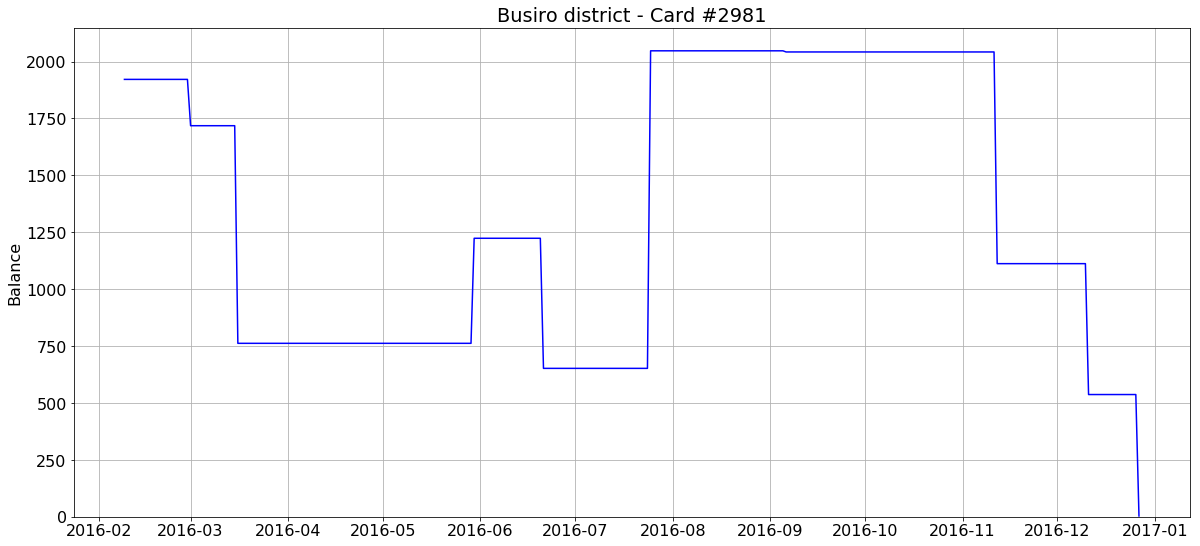

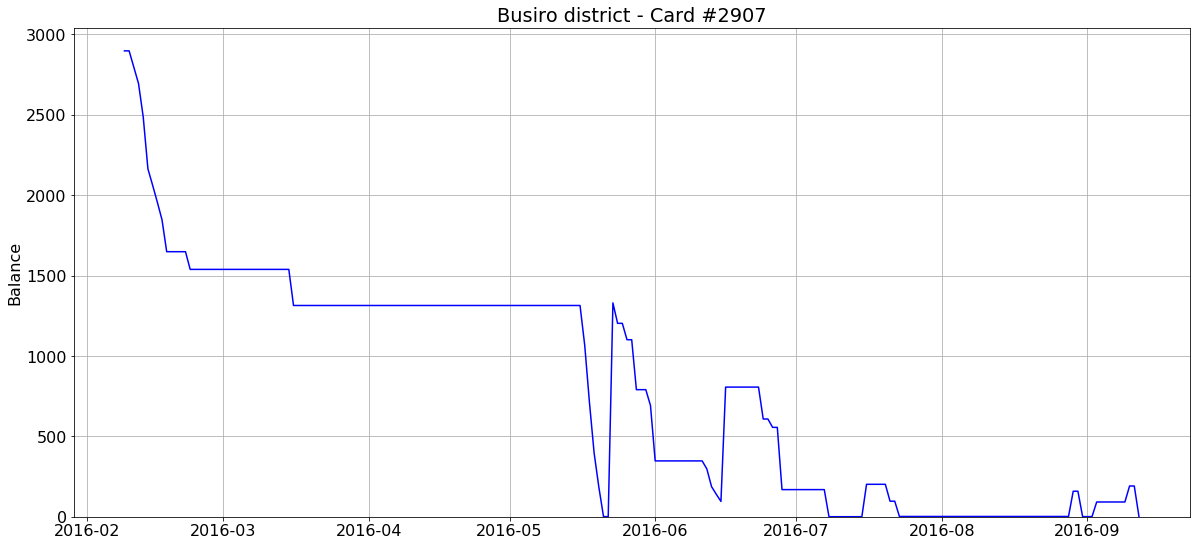

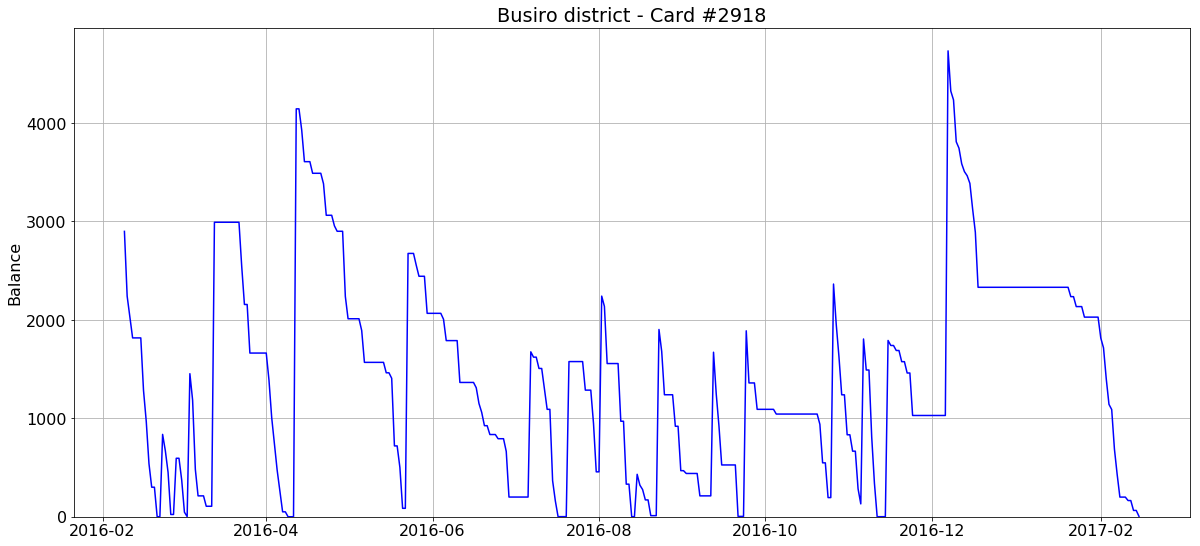

In [43]:
#@interact(card=getCardsByDistrict_forReport('Busiro')[:10])
def printGraph(card):
    #card = '1898'
    data = getCardData(card, 'Busiro')
    x = data.Date
    y = data.DayBalance

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Balance")
    plt.plot(x,y, 'b')
    plt.ylim(ymin=-0.1)

    plt.title('Busiro district - Card #' + card)
    
    plt.show()
    
for card in getCardsByDistrict_forReport('Busiro')[:10]:
    printGraph(card)

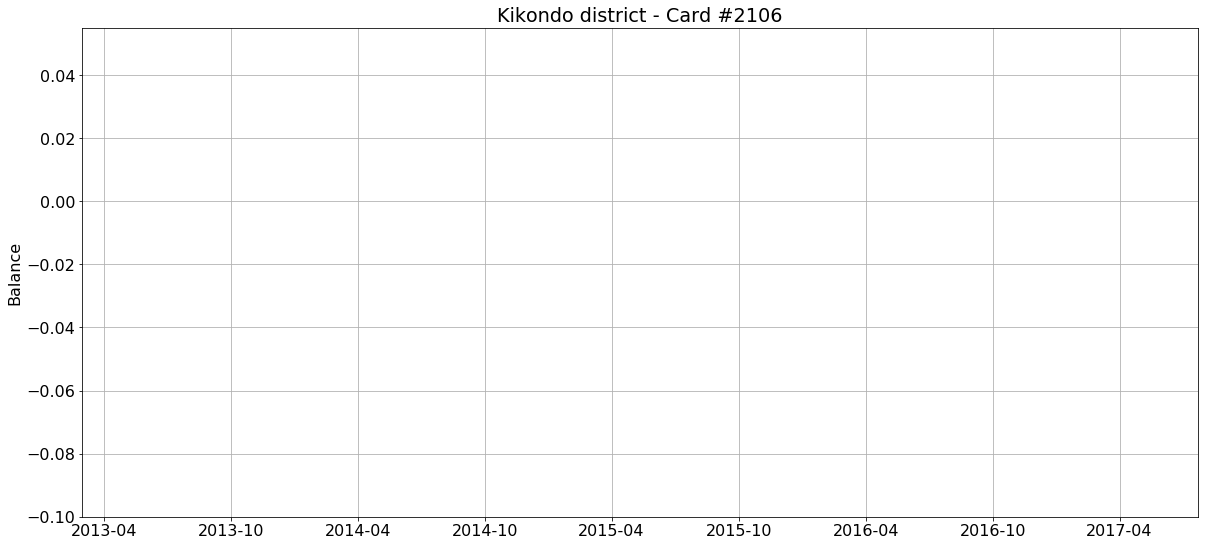

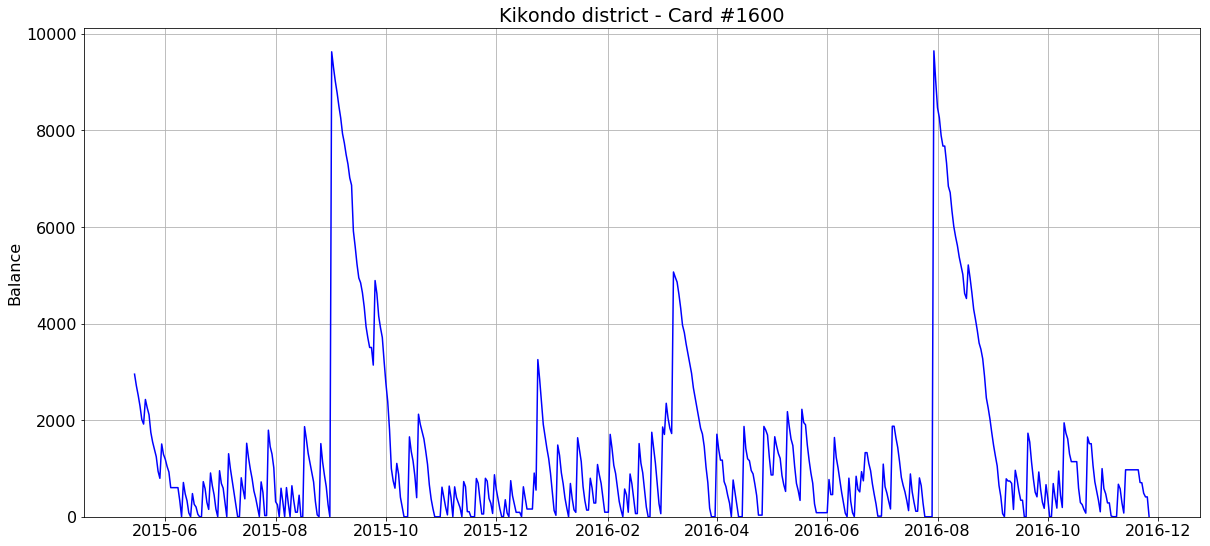

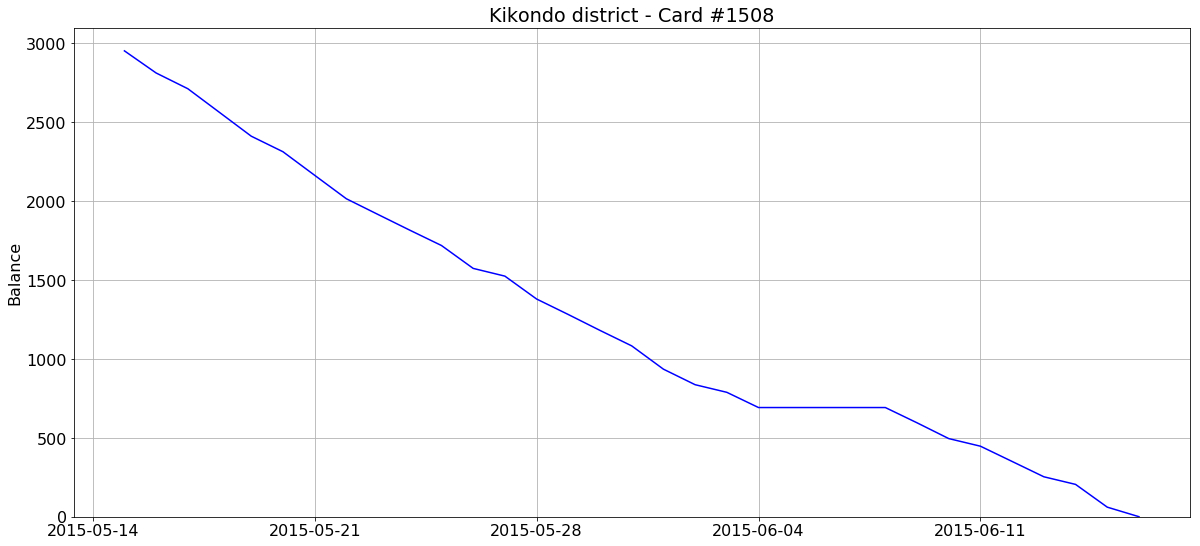

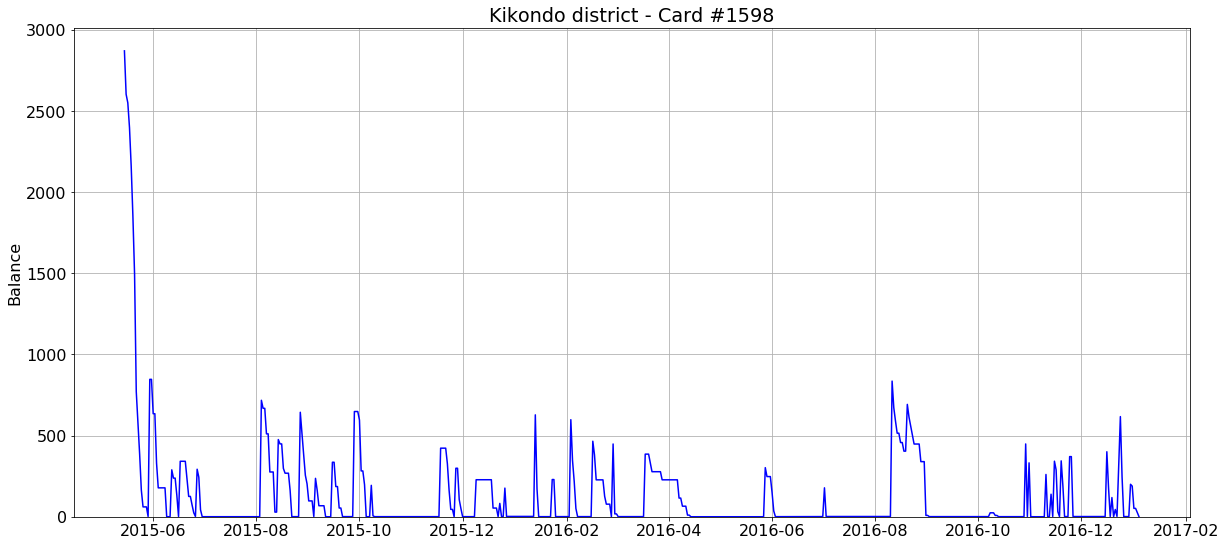

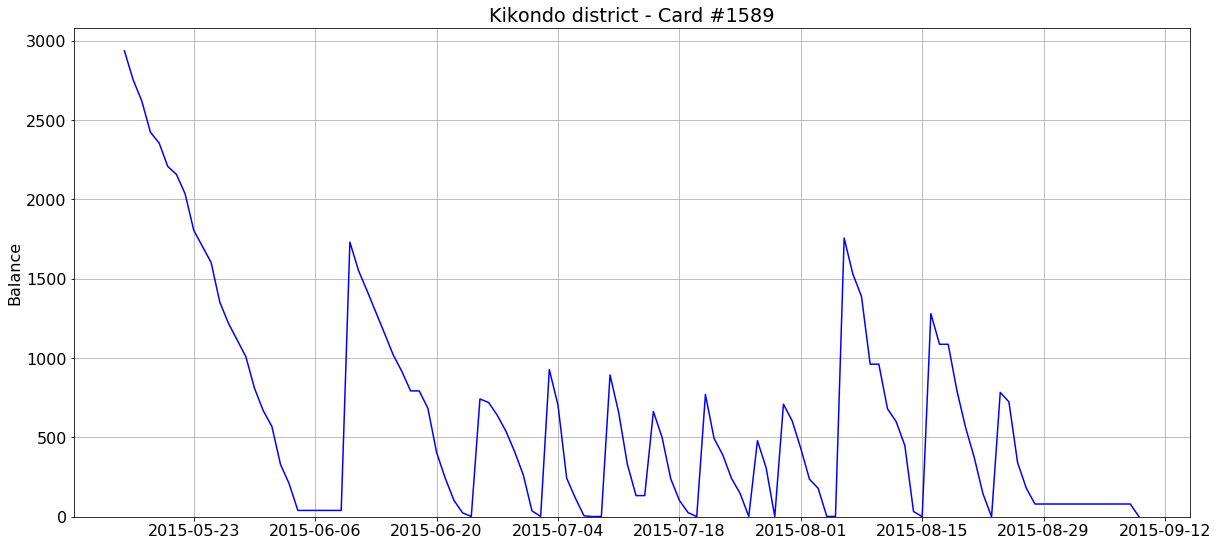

In [44]:
#@interact(card=getCardsByDistrict_forReport('Kikondo')[:10])
def printGraph(card):
    #card = '1898'
    data = getCardData(card, 'Kikondo')
    x = data.Date
    y = data.DayBalance

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Balance")
    plt.plot(x,y, 'b')
    plt.ylim(ymin=-0.1)

    plt.title('Kikondo district - Card #' + card)
    
    plt.show()
    
for card in getCardsByDistrict_forReport('Kikondo')[:10]:
    printGraph(card)

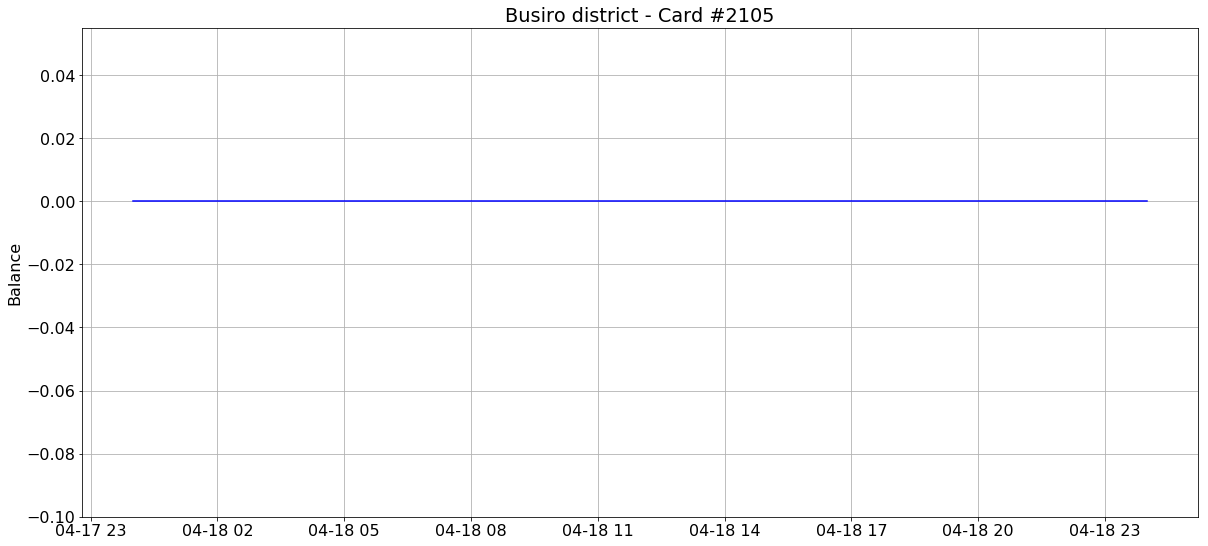

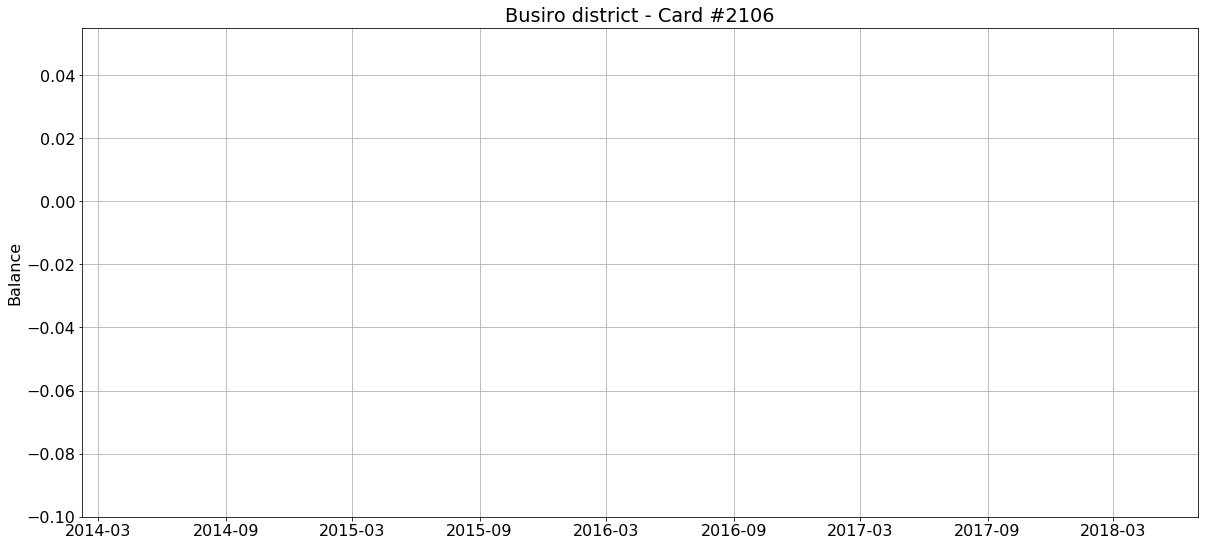

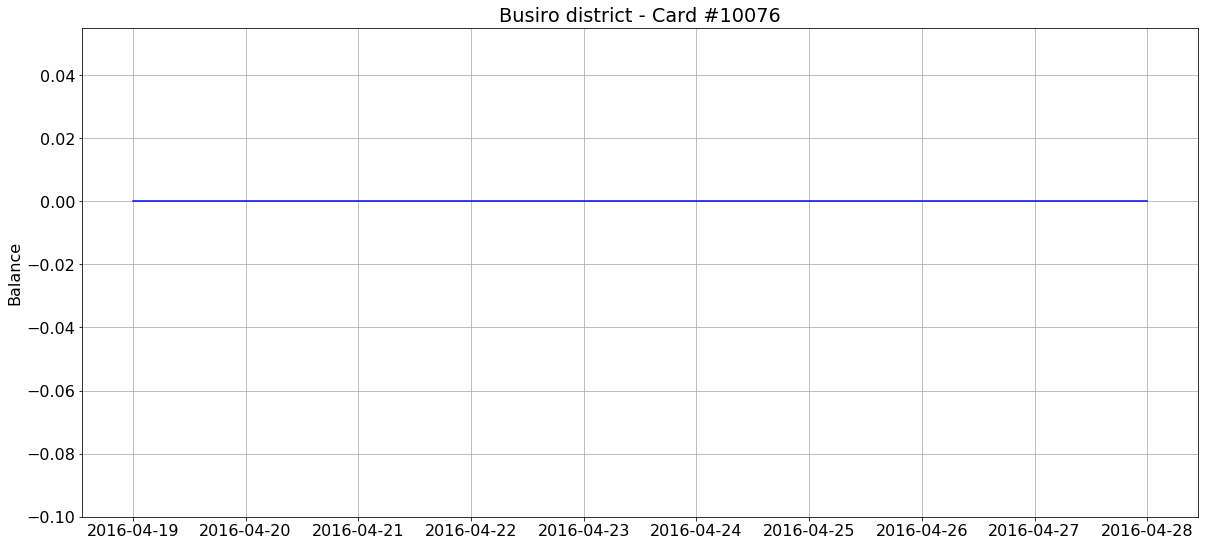

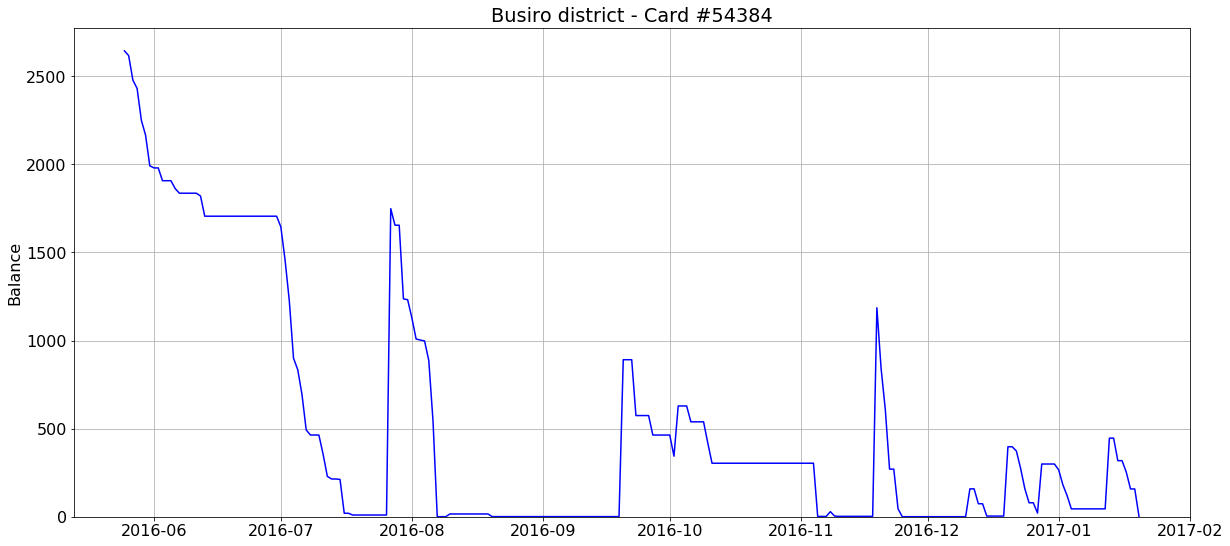

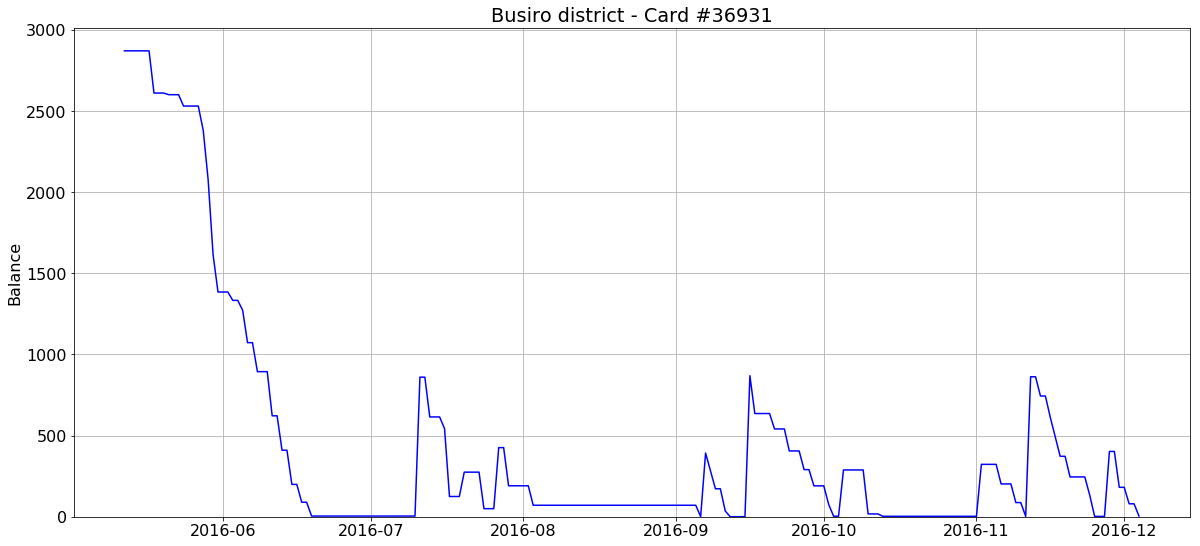

In [45]:
#@interact(card=getCardsByDistrict_forReport('Dei')[:10])
def printGraph(card):
    #card = '1898'
    data = getCardData(card, 'Dei')
    x = data.Date
    y = data.DayBalance

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Balance")
    plt.plot(x,y, 'b')
    plt.ylim(ymin=-0.1)

    plt.title('Busiro district - Card #' + card)
    plt.show()
    
for card in getCardsByDistrict_forReport('Dei')[:10]:
    printGraph(card)

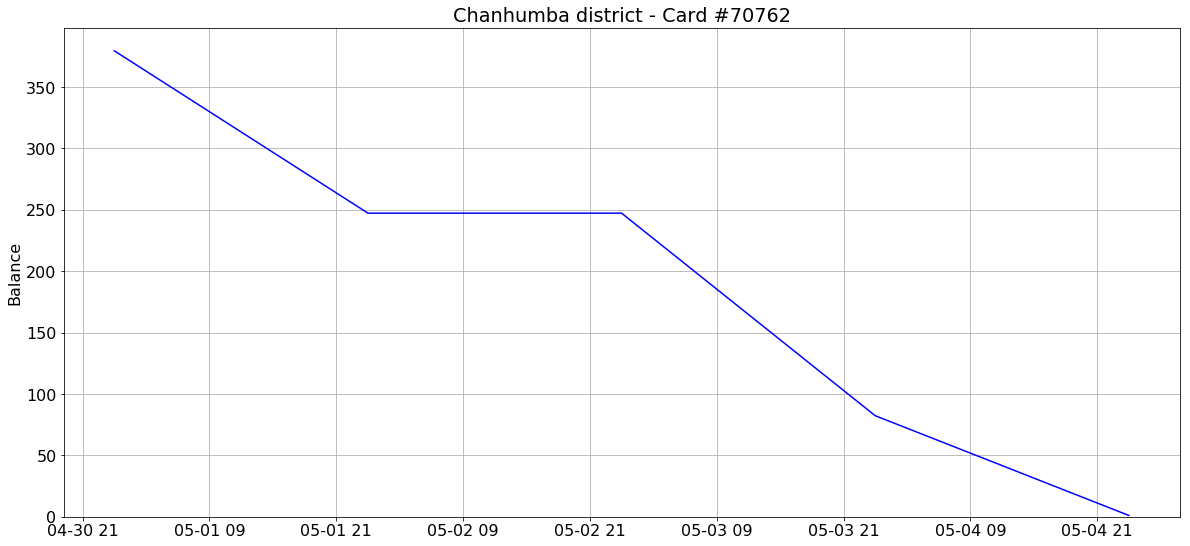

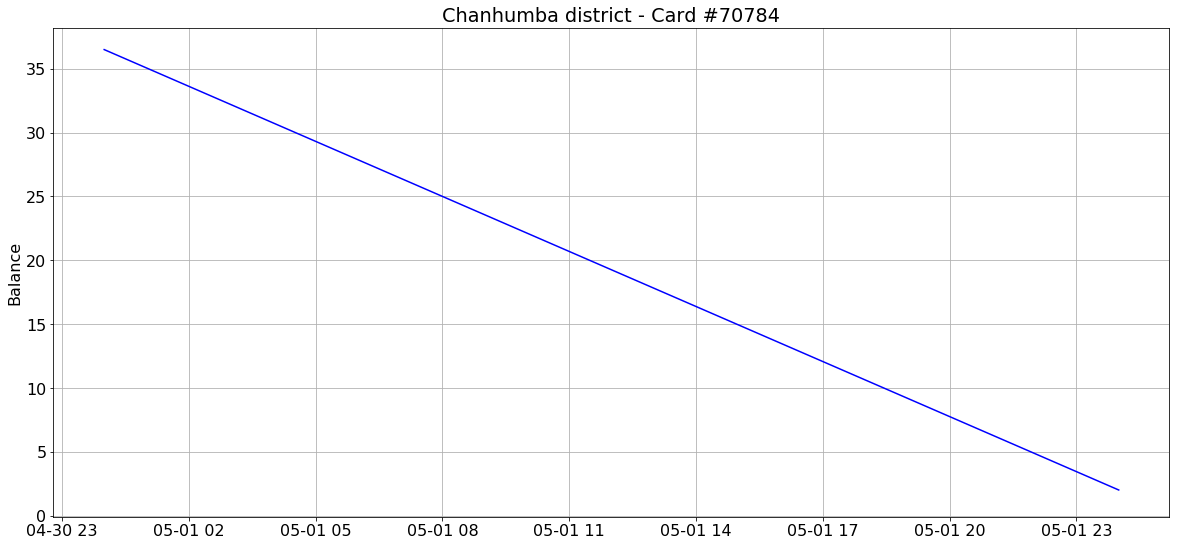

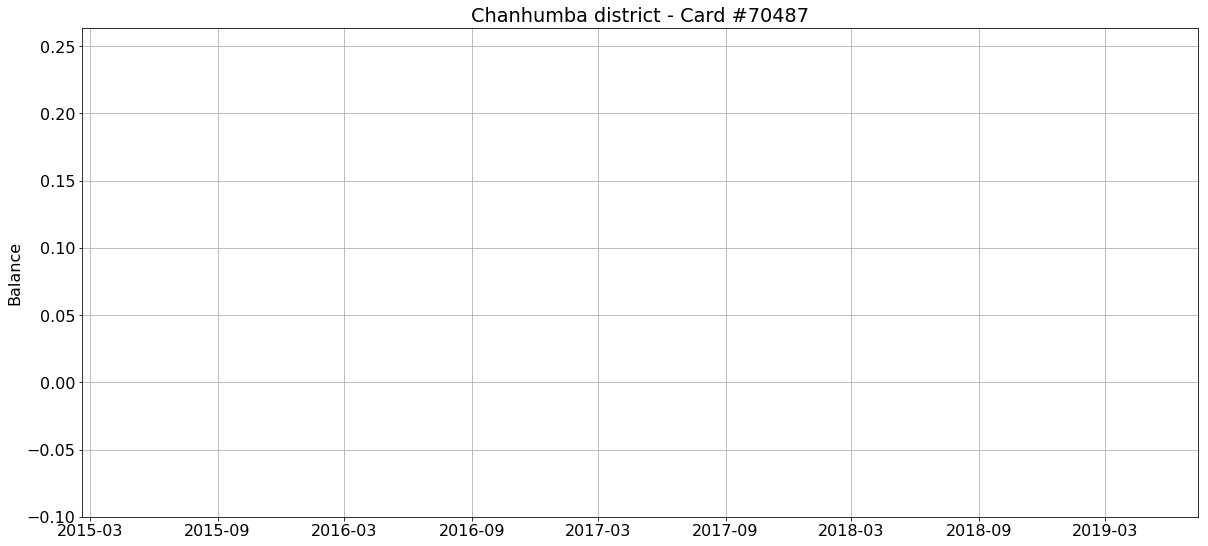

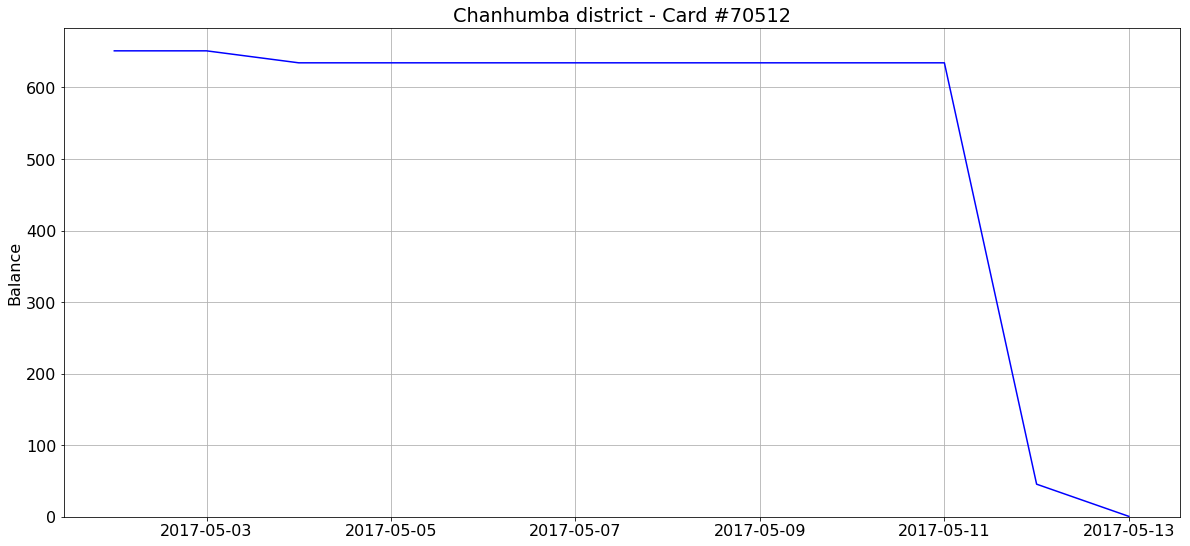

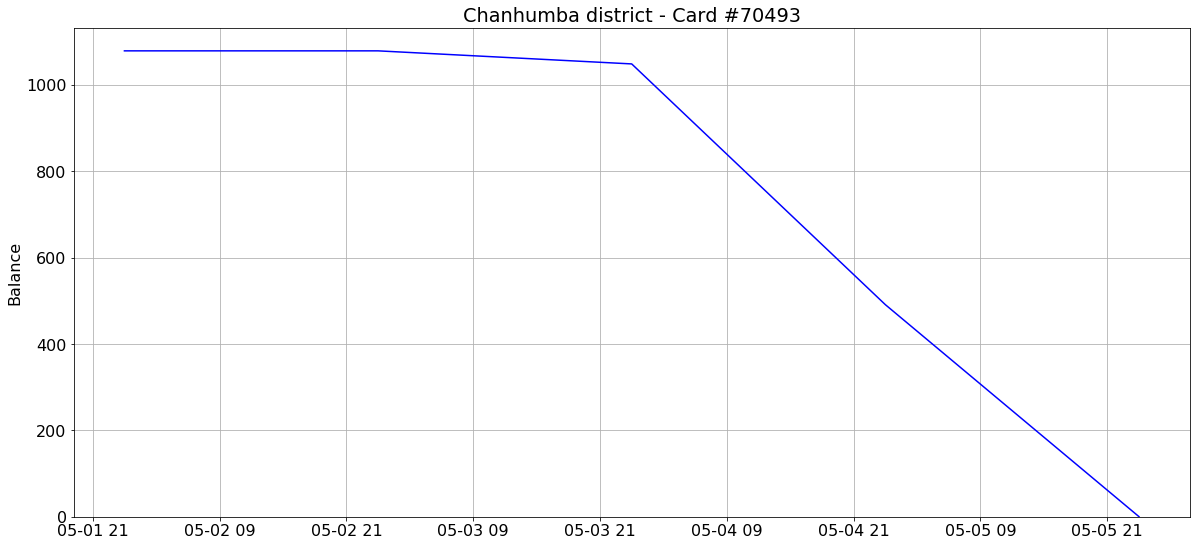

In [46]:
def printGraph(card):
    #card = '1898'
    data = getCardData(card, 'Chanhumba')
    x = data.Date
    y = data.DayBalance

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Balance")
    plt.plot(x,y, 'b')
    plt.ylim(ymin=-0.1)

    plt.title('Chanhumba district - Card #' + card)
    plt.show()
    
for card in getCardsByDistrict_forReport('Chanhumba')[:10]:
    printGraph(card)

<a id="section5"></a>
## Section 12 - Water consumption during the day and by the day of week

Here we build some charts illustrate water consumption during different periods of time

In [47]:
# days of activity
resultset = resultset.sort_values(['District', 'Smartcard_1', 'Date_and_time'], ascending=[True, True, True]).drop_duplicates()
numberOfDaysBusiro119 = len(resultset[resultset.Dispenser == 'Busiro 119'].Date.drop_duplicates())
numberOfDaysBusiro121 = len(resultset[resultset.Dispenser == 'Busiro 121'].Date.drop_duplicates())
numberOfDaysBusiro = len(resultset[resultset.District == 'Busiro'].Date.drop_duplicates())
numberOfDaysKikondo = len(resultset[resultset.District == 'Kikondo'].Date.drop_duplicates())
numberOfDaysDei = len(resultset[resultset.District == 'Dei'].Date.drop_duplicates())
numberOfDaysChanhumba = len(resultset[resultset.District == 'Chanhumba'].Date.drop_duplicates())

numberOfDaysChanhumbaNyerere = len(resultset[resultset.Dispenser == 'Nyerere'].Date.drop_duplicates())
numberOfDaysChanhumbaZahanati = len(resultset[resultset.Dispenser == 'Zahanati'].Date.drop_duplicates())
numberOfDaysChanhumbaArusha_B = len(resultset[resultset.Dispenser == 'Arusha B'].Date.drop_duplicates())
numberOfDaysChanhumbaIringa = len(resultset[resultset.Dispenser == 'Iringa'].Date.drop_duplicates())
numberOfDaysChanhumbaChangombe = len(resultset[resultset.Dispenser == "Chang'ombe"].Date.drop_duplicates())



districtDays = [{'District': 'Busiro', 'Days': numberOfDaysBusiro}, {'District': 'Busiro 119', 'Days': numberOfDaysBusiro119}, {'District': 'Busiro 121', 'Days': numberOfDaysBusiro121}, 
                {'District': 'Kikondo', 'Days': numberOfDaysKikondo}, {'District': 'Dei', 'Days': numberOfDaysDei}, {'District': 'Chanhumba', 'Days': numberOfDaysChanhumba}, 
                {'District': 'Nyerere', 'Days': numberOfDaysChanhumbaNyerere}, {'District': 'Zahanati', 'Days': numberOfDaysChanhumbaZahanati}, 
                {'District': 'Arusha B', 'Days': numberOfDaysChanhumbaArusha_B}, {'District': 'Iringa', 'Days': numberOfDaysChanhumbaIringa}, 
                {'District': "Chang'ombe", 'Days': numberOfDaysChanhumbaChangombe}]
numberOfDays = pd.DataFrame(districtDays, index=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']);


In [48]:
# activity by hour
resultset['Hour'] = pd.DatetimeIndex(resultset['Date_and_time']).hour
resultsetByHours1 = resultset.groupby(['District', 'Hour']).Water_dispensed.mean()
resultsetByHours2 = resultset.groupby(['District', 'Hour']).Water_dispensed.sum()
resultsetByHours3 = resultset.groupby(['District', 'Hour']).Water_dispensed.count()
resultsetByHours =  pd.concat([resultsetByHours1, resultsetByHours2, resultsetByHours3], axis = 1).reset_index() 

resultsetByHours = pd.merge(resultsetByHours, numberOfDays, on=['District'])
resultsetByHours.columns = ['District', 'Hour', 'Water_dispensed_Mean_Transaction', 'Water_dispensed_Sum', 'Transaction_count', 'Days']


In [49]:
    resultset['DayOfWeek'] = pd.DatetimeIndex(resultset['Date_and_time']).dayofweek
    resultsetByDayOfWeek1 = resultset.groupby(['District', 'Date', 'DayOfWeek']).Water_dispensed.sum()
    resultsetByDayOfWeek2 = resultset.groupby(['District', 'Date', 'DayOfWeek']).Water_dispensed.count()
    resultsetByDayOfWeek_Dispenser =  pd.concat([resultsetByDayOfWeek1, resultsetByDayOfWeek2], axis = 1).reset_index() 
    resultsetByDayOfWeek_Dispenser.columns = ['District', 'Date', 'DayOfWeek', 'Water_dispensed', 'Transaction_count']
    
    resultsetByDayOfWeek1 = resultsetByDayOfWeek_Dispenser.groupby(['District', 'DayOfWeek']).Water_dispensed.mean()
    resultsetByDayOfWeek2 = resultsetByDayOfWeek_Dispenser.groupby(['District', 'DayOfWeek']).Transaction_count.mean()
    resultsetByDayOfWeek_Dispenser =  pd.concat([resultsetByDayOfWeek1, resultsetByDayOfWeek2], axis = 1).reset_index() 


In [50]:
resultset['Hour'] = pd.DatetimeIndex(resultset['Date_and_time']).hour
resultsetByHours1 = resultset.groupby(['Dispenser', 'Hour']).Water_dispensed.mean()
resultsetByHours2 = resultset.groupby(['Dispenser', 'Hour']).Water_dispensed.sum()
resultsetByHours3 = resultset.groupby(['Dispenser', 'Hour']).Water_dispensed.count()
resultsetByHours_Dispenser =  pd.concat([resultsetByHours1, resultsetByHours2, resultsetByHours3], axis = 1).reset_index() 
numberOfDays['Dispenser'] = numberOfDays.District
resultsetByHours_Dispenser = pd.merge(resultsetByHours_Dispenser, numberOfDays, on=['Dispenser'])
resultsetByHours_Dispenser.columns = ['Dispenser', 'Hour', 'Water_dispensed_Mean_Transaction', 'Water_dispensed_Sum', 'Transaction_count', 'Days', 'District']


In [51]:
hours = pd.DataFrame(np.arange(24), index=np.arange(24), columns = ['Hour'])
   
resultsetByHours_Dispenser['AverageWaterPerDay']  = resultsetByHours_Dispenser.Water_dispensed_Sum / resultsetByHours_Dispenser.Days
resultsetByHours_Dispenser['AverageTransactionsPerDay']  = resultsetByHours_Dispenser.Transaction_count / resultsetByHours_Dispenser.Days
resultsetByHours['AverageWaterPerDay']  = resultsetByHours.Water_dispensed_Sum / resultsetByHours.Days
resultsetByHours['AverageTransactionsPerDay']  = resultsetByHours.Transaction_count / resultsetByHours.Days


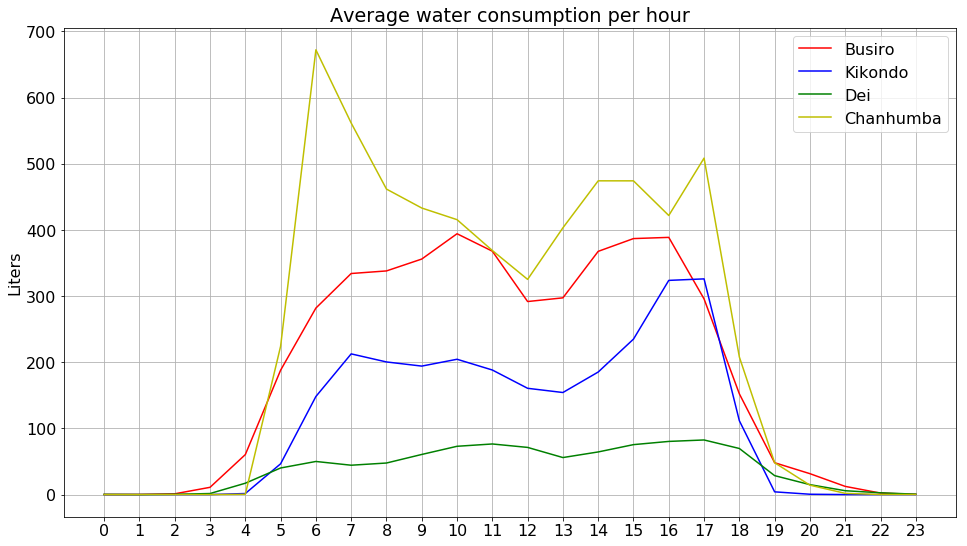

In [52]:
    x = hours.Hour
    y1 = getAverageWaterPerDay('Busiro') 
    y2 = getAverageWaterPerDay('Kikondo') 
    y3 = getAverageWaterPerDay('Dei') 
    y4 = getAverageWaterPerDay('Chanhumba') 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y1, 'r')
    plt.plot(x,y2, 'b')
    plt.plot(x,y3, 'g')
    plt.plot(x,y4, 'y')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba") )
    plt.title('Average water consumption per hour')

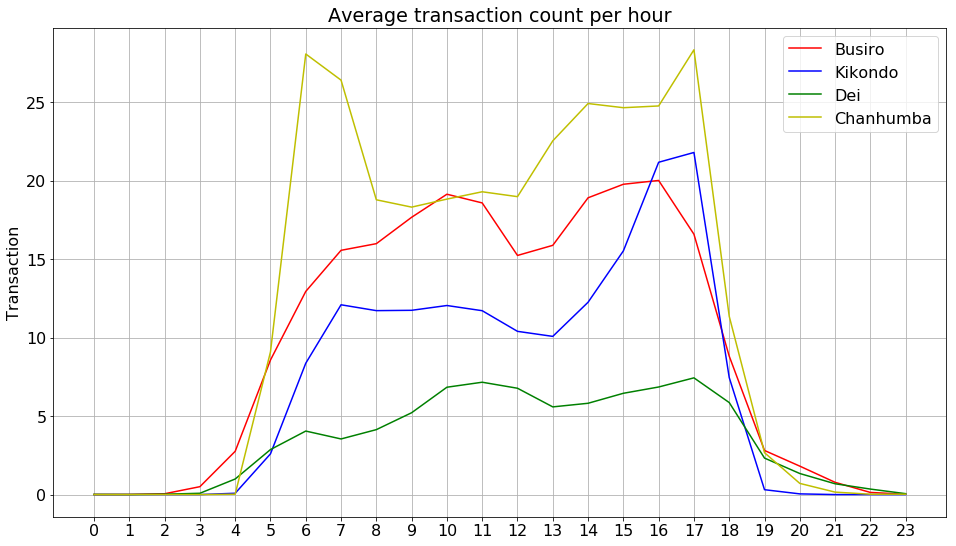

In [53]:
    x = hours.Hour
    y1 = getAverageTransactionsPerDay('Busiro') 
    y2 = getAverageTransactionsPerDay('Kikondo') 
    y3 = getAverageTransactionsPerDay('Dei') 
    y4 = getAverageTransactionsPerDay('Chanhumba') 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Transaction")
    
    plt.plot(x,y1, 'r')
    plt.plot(x,y2, 'b')
    plt.plot(x,y3, 'g')
    plt.plot(x,y4, 'y')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba") )
    plt.title('Average transaction count per hour')

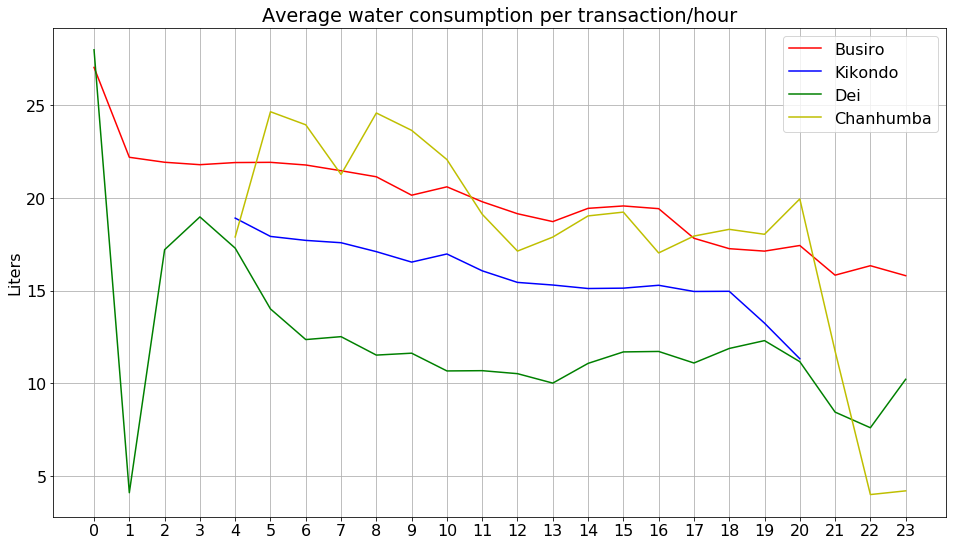

In [54]:
    x = hours.Hour
    y11 = getAverageTransactionsPerDay('Busiro') 
    y12 = getAverageTransactionsPerDay('Kikondo') 
    y13 = getAverageTransactionsPerDay('Dei') 
    y14 = getAverageTransactionsPerDay('Chanhumba') 
    y21 = getAverageWaterPerDay('Busiro') 
    y22 = getAverageWaterPerDay('Kikondo') 
    y23 = getAverageWaterPerDay('Dei') 
    y24 = getAverageWaterPerDay('Chanhumba') 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y21/y11, 'r')
    plt.plot(x,y22/y12, 'b')
    plt.plot(x,y23/y13, 'g')
    plt.plot(x,y24/y14, 'y')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba") )
    plt.title('Average water consumption per transaction/hour')

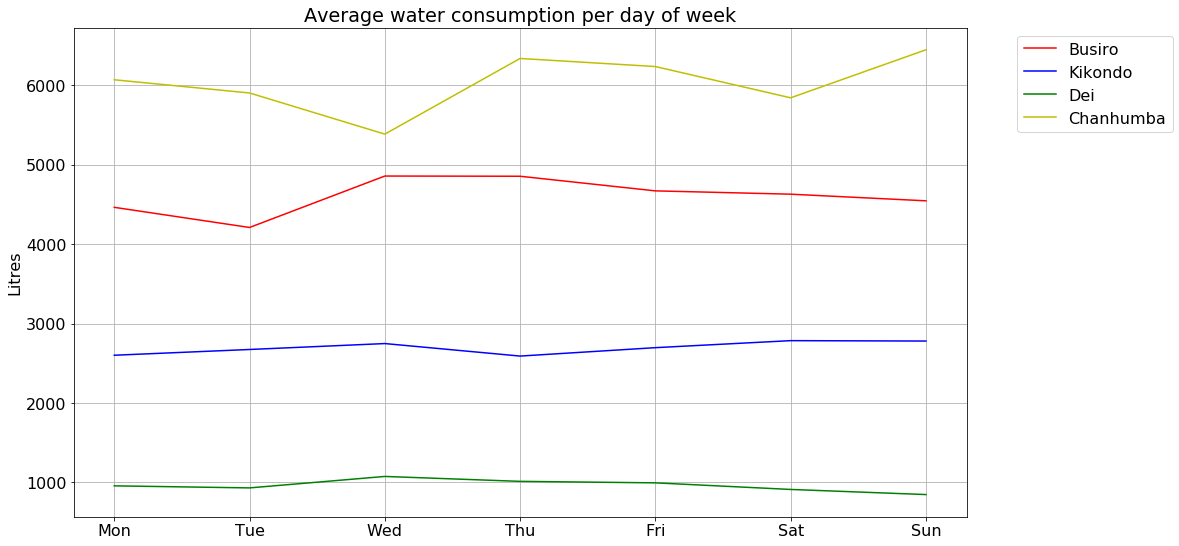

In [55]:
    x = getDayOfWeekData('Busiro').DayOfWeek
    y1 = getDayOfWeekData('Busiro').Water_dispensed 
    y2 = getDayOfWeekData('Kikondo').Water_dispensed  
    y3 = getDayOfWeekData('Dei').Water_dispensed  
    y4 = getDayOfWeekData('Chanhumba').Water_dispensed  

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Litres")
    
    plt.plot(x,y1, 'r')
    plt.plot(x,y2, 'b')
    plt.plot(x,y3, 'g')
    plt.plot(x,y4, 'y')
 
    plt.xticks(np.arange(0, 7, 1.0))
    ax.xaxis.set_ticklabels(list(calendar.day_abbr))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba"), bbox_to_anchor=(1.24, 1) )
    plt.title('Average water consumption per day of week')

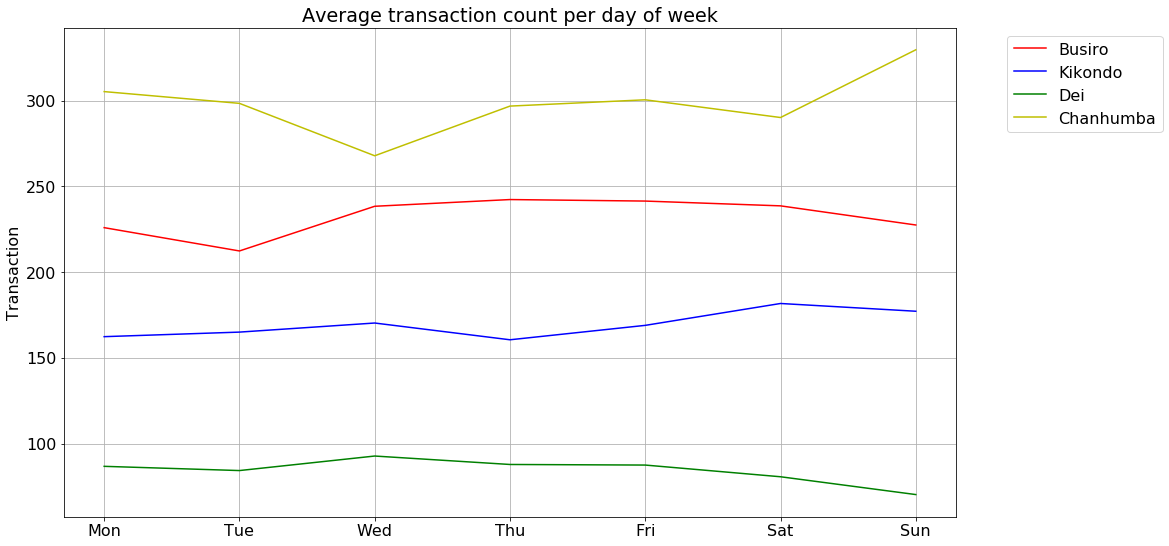

In [56]:
    x = getDayOfWeekData('Busiro').DayOfWeek
    y1 = getDayOfWeekData('Busiro').Transaction_count 
    y2 = getDayOfWeekData('Kikondo').Transaction_count  
    y3 = getDayOfWeekData('Dei').Transaction_count  
    y4 = getDayOfWeekData('Chanhumba').Transaction_count  

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Transaction")
    
    plt.plot(x,y1, 'r')
    plt.plot(x,y2, 'b')
    plt.plot(x,y3, 'g')
    plt.plot(x,y4, 'y')
 
    plt.xticks(np.arange(0, 7, 1.0))
    ax.xaxis.set_ticklabels(list(calendar.day_abbr))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba"), bbox_to_anchor=(1.24, 1) )
    plt.title('Average transaction count per day of week')

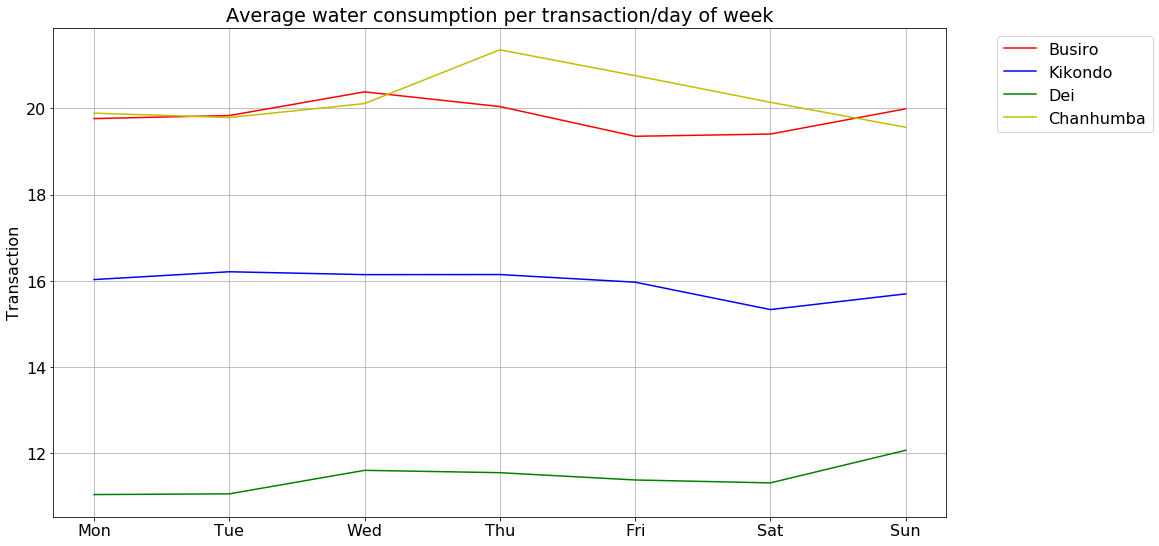

In [57]:
    x = getDayOfWeekData('Busiro').DayOfWeek
    y11 = getDayOfWeekData('Busiro').Transaction_count 
    y12 = getDayOfWeekData('Kikondo').Transaction_count  
    y13 = getDayOfWeekData('Dei').Transaction_count  
    y14 = getDayOfWeekData('Chanhumba').Transaction_count  
    y21 = getDayOfWeekData('Busiro').Water_dispensed 
    y22 = getDayOfWeekData('Kikondo').Water_dispensed  
    y23 = getDayOfWeekData('Dei').Water_dispensed  
    y24 = getDayOfWeekData('Chanhumba').Water_dispensed  

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Transaction")
    
    plt.plot(x,y21/y11, 'r')
    plt.plot(x,y22/y12, 'b')
    plt.plot(x,y23/y13, 'g')
    plt.plot(x,y24/y14, 'y')
 
    plt.xticks(np.arange(0, 7, 1.0))
    ax.xaxis.set_ticklabels(list(calendar.day_abbr))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba"), bbox_to_anchor=(1.24, 1) )
    plt.title('Average water consumption per transaction/day of week')

In [58]:
    resultsetByDayOfWeekHour1 = resultset.groupby(['District', 'Date', 'DayOfWeek', 'Hour']).Water_dispensed.sum()
    resultsetByDayOfWeekHour2 = resultset.groupby(['District', 'Date', 'DayOfWeek', 'Hour']).Water_dispensed.count()
    resultsetByDayOfWeekHour =  pd.concat([resultsetByDayOfWeekHour1, resultsetByDayOfWeekHour2], axis = 1).reset_index() 
    resultsetByDayOfWeekHour.columns = ['District', 'Date', 'DayOfWeek', 'Hour', 'Water_dispensed', 'Transaction_count']
    resultsetByDayOfWeekHour.Hour = resultsetByDayOfWeekHour.Hour.map(lambda x: changeHour1(x))
    resultsetByDayOfWeekHour.HourNew = resultsetByDayOfWeekHour.Hour.map(lambda x: changeHour2(x))
    resultsetByDayOfWeekHour.DayOfWeekNew = resultsetByDayOfWeekHour.DayOfWeek.map(lambda x: changeDay(x))
    resultsetByDayOfWeekHour['Index'] = resultsetByDayOfWeekHour.DayOfWeekNew.map(str) + ', ' + resultsetByDayOfWeekHour.HourNew.map(str)
    resultsetByDayOfWeekHour = resultsetByDayOfWeekHour[['District', 'DayOfWeek', 'Hour', 'Index', 'Water_dispensed', 'Transaction_count']]

    resultsetByDayOfWeekHour1 = resultsetByDayOfWeekHour.groupby(['District', 'DayOfWeek', 'Hour', 'Index']).Water_dispensed.mean()
    resultsetByDayOfWeekHour2 = resultsetByDayOfWeekHour.groupby(['District', 'DayOfWeek', 'Hour', 'Index']).Transaction_count.mean()
    resultsetByDayOfWeekHour =  pd.concat([resultsetByDayOfWeekHour1, resultsetByDayOfWeekHour2], axis = 1).reset_index() 

    resultsetByDayOfWeekHour['WaterPerTransaction'] = resultsetByDayOfWeekHour.Water_dispensed / resultsetByDayOfWeekHour.Transaction_count

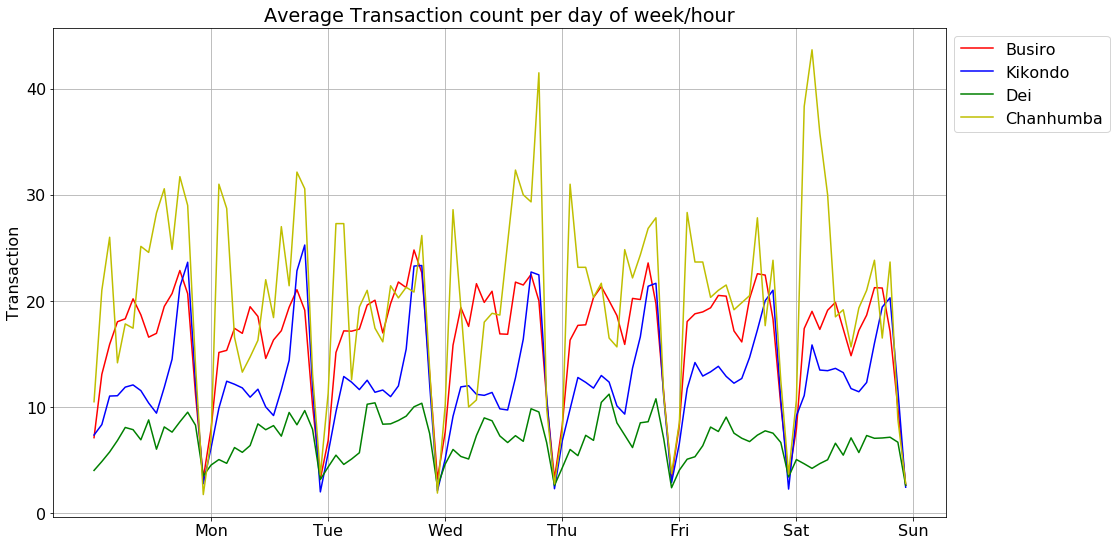

In [59]:
    x = getDayOfWeekHourData('Busiro').index
    y1 = getDayOfWeekHourData('Busiro').Transaction_count 
    y2 = getDayOfWeekHourData('Kikondo').Transaction_count  
    y3 = getDayOfWeekHourData('Dei').Transaction_count  
    y4 = getDayOfWeekHourData('Chanhumba').Transaction_count  

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Transaction")
    
    plt.plot(x,y1, 'r')
    plt.plot(x,y2, 'b')
    plt.plot(x,y3, 'g')
    plt.plot(x,y4, 'y')
 
    plt.xticks(np.arange(15, 106, 15.0))
    ax.xaxis.set_ticklabels(list(calendar.day_abbr))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba"), bbox_to_anchor=(1, 1) )
    plt.title('Average Transaction count per day of week/hour')

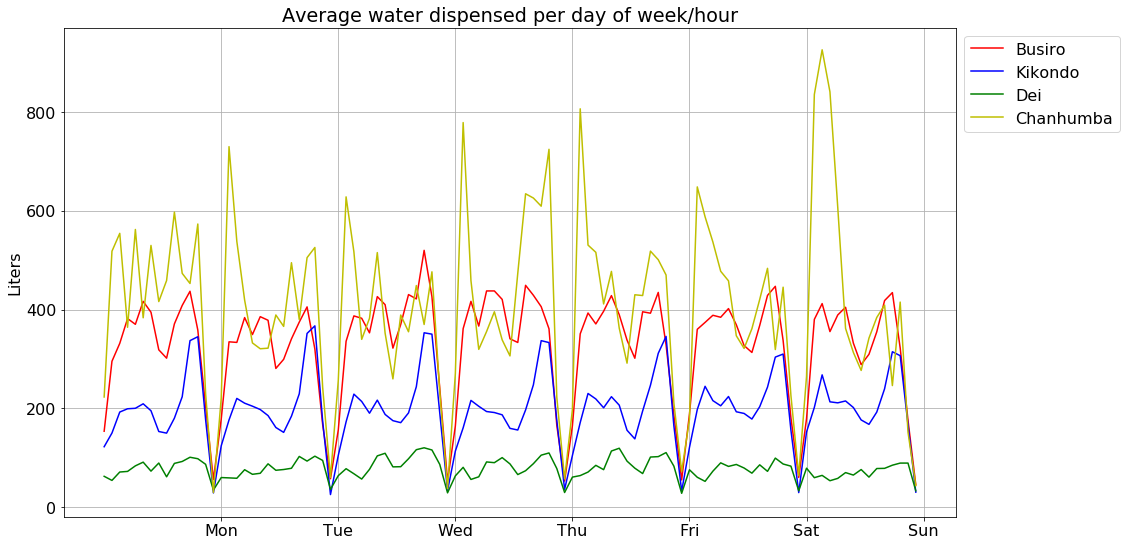

In [60]:
    x = getDayOfWeekHourData('Busiro').index
    y1 = getDayOfWeekHourData('Busiro').Water_dispensed 
    y2 = getDayOfWeekHourData('Kikondo').Water_dispensed  
    y3 = getDayOfWeekHourData('Dei').Water_dispensed  
    y4 = getDayOfWeekHourData('Chanhumba').Water_dispensed  

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y1, 'r')
    plt.plot(x,y2, 'b')
    plt.plot(x,y3, 'g')
    plt.plot(x,y4, 'y')
 
    plt.xticks(np.arange(15, 106, 15.0))
    ax.xaxis.set_ticklabels(list(calendar.day_abbr))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba"), bbox_to_anchor=(1, 1) )
    plt.title('Average water dispensed per day of week/hour')

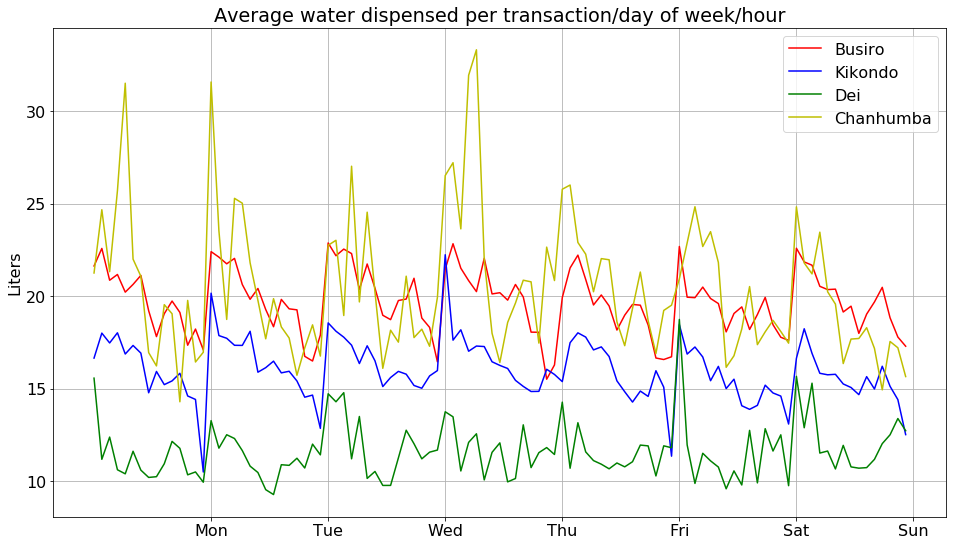

In [61]:
    x = getDayOfWeekHourData('Busiro').index
    y1 = getDayOfWeekHourData('Busiro').WaterPerTransaction 
    y2 = getDayOfWeekHourData('Kikondo').WaterPerTransaction  
    y3 = getDayOfWeekHourData('Dei').WaterPerTransaction  
    y4 = getDayOfWeekHourData('Chanhumba').WaterPerTransaction  

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y1, 'r')
    plt.plot(x,y2, 'b')
    plt.plot(x,y3, 'g')
    plt.plot(x,y4, 'y')
 
    plt.xticks(np.arange(15, 106, 15.0))
    ax.xaxis.set_ticklabels(list(calendar.day_abbr))
    
    plt.legend ( ("Busiro", "Kikondo", "Dei", "Chanhumba"), bbox_to_anchor=(1, 1) )
    plt.title('Average water dispensed per transaction/day of week/hour')

<a id="section6"></a>
# Section 13 - Transaction type analysis

We divide all cards into several groups by their behavior in water consumption.

If the interval between transactions was usually more than one, we marked these cards as '1 transaction per day cards'.

If the interval between transactions was usually less than a few minutes, we marked these cards as 'Multi-transaction cards'.

If the interval between transactions was usually more than a few minutes and there were a lot of transaction per day, we marked these cards as 'Multi-trip cards'.

If we didn't mark the card exactly, we marked it as 'NA'.

Also if we found that the card had a very big current balance and made credits to other cards we marked it as 'Creditor'.

In [62]:
resultset.Date_and_time = pd.to_datetime(resultset.Date_and_time, format='%d-%m-%Y %H:%M:%S')
resultset['Time_previous'] = resultset.groupby(['District', 'Smartcard_1', 'Date'])['Date_and_time'].shift()
resultset['Time_next'] = resultset.groupby(['District', 'Smartcard_1', 'Date'])['Date_and_time'].shift(-1)

timeDiffDF = resultset[['District', 'Smartcard_1','Date', 'Date_and_time', 'Time_previous', 'Time_next']]
timeDiffDF['Time_diff'] = timeDiffDF.apply(getTimeDiff, axis = 1)
timeDiffDF[:5]

District Smartcard_1       Date       Date_and_time       Time_previous  \
14   Busiro        1603 2016-02-09 2016-02-09 14:44:10                 NaT   
17   Busiro        1603 2016-02-09 2016-02-09 14:55:04 2016-02-09 14:44:10   
18   Busiro        1603 2016-02-09 2016-02-09 14:55:30 2016-02-09 14:55:04   
20   Busiro        1603 2016-02-09 2016-02-09 14:57:24 2016-02-09 14:55:30   
22   Busiro        1603 2016-02-09 2016-02-09 15:13:13 2016-02-09 14:57:24   

             Time_next Time_diff  
14 2016-02-09 14:55:04  00:10:54  
17 2016-02-09 14:55:30  00:10:54  
18 2016-02-09 14:57:24  00:00:26  
20 2016-02-09 15:13:13  00:01:54  
22 2016-02-09 15:21:09  00:15:49

In [63]:
timeDiffDF_multiTransaction = timeDiffDF[pd.notnull(timeDiffDF.Time_diff)].reset_index(drop = True)
timeDiffDF_multiTransaction['Minutes'] = np.round(timeDiffDF_multiTransaction.Time_diff.astype('timedelta64[s]') / 60, 0).astype(int)
timeDiffDF_multiTransaction['Group'] = pd.Series(timeDiffDF_multiTransaction.Minutes, index=timeDiffDF_multiTransaction.index).apply(getOperationGroup) 
timeDiffDF_multiTransaction[:3]

District Smartcard_1       Date       Date_and_time       Time_previous  \
0   Busiro        1603 2016-02-09 2016-02-09 14:44:10                 NaT   
1   Busiro        1603 2016-02-09 2016-02-09 14:55:04 2016-02-09 14:44:10   
2   Busiro        1603 2016-02-09 2016-02-09 14:55:30 2016-02-09 14:55:04   

            Time_next Time_diff  Minutes                  Group  
0 2016-02-09 14:55:04  00:10:54       11  multiple transactions  
1 2016-02-09 14:55:30  00:10:54       11  multiple transactions  
2 2016-02-09 14:57:24  00:00:26        0  multiple transactions

Busiro  Chanhumba        Dei   Kikondo
0  85.950161  86.974038  93.055649  90.82352

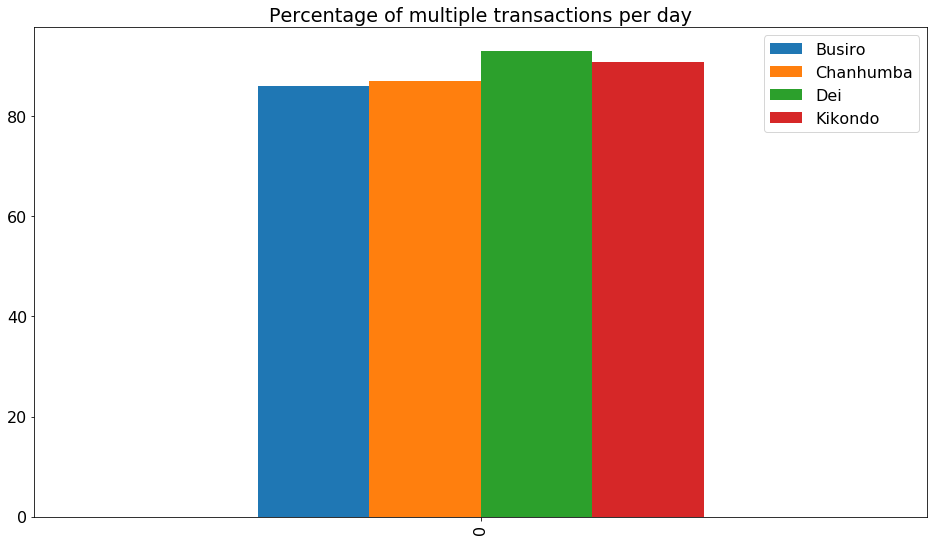

In [64]:
df2 = pd.DataFrame([{'Busiro': len(timeDiffDF_multiTransaction[timeDiffDF_multiTransaction.District == 'Busiro']) / len(timeDiffDF[timeDiffDF.District == 'Busiro']) * 100, 
                     'Kikondo': len(timeDiffDF_multiTransaction[timeDiffDF_multiTransaction.District == 'Kikondo']) / len(timeDiffDF[timeDiffDF.District == 'Kikondo']) * 100, 
                     'Chanhumba': len(timeDiffDF_multiTransaction[timeDiffDF_multiTransaction.District == 'Chanhumba']) / len(timeDiffDF[timeDiffDF.District == 'Chanhumba']) * 100, 
                     'Dei': len(timeDiffDF_multiTransaction[timeDiffDF_multiTransaction.District == 'Dei']) / len(timeDiffDF[timeDiffDF.District == 'Dei']) * 100}]);
df2.plot(kind='bar',title='Percentage of multiple transactions per day');
df2

In [65]:
timeDiffDF_multiTransaction_groupped = timeDiffDF_multiTransaction.groupby(['District', 'Minutes']).Smartcard_1.count().reset_index()
timeDiffDF_multiTransaction_groupped['Group'] = pd.Series(timeDiffDF_multiTransaction_groupped.Minutes, index=timeDiffDF_multiTransaction_groupped.index).apply(getIntervalGroup)
timeDiffDF_multiTransaction_groupped[:3]

District  Minutes  Smartcard_1 Group
0   Busiro        0        10789     0
1   Busiro        1        14899     1
2   Busiro        2        12372     2

In [66]:
busiroMultipleTransactions = len(timeDiffDF[timeDiffDF.District == 'Busiro'])
kikondoMultipleTransactions = len(timeDiffDF[timeDiffDF.District == 'Kikondo'])
deiMultipleTransactions = len(timeDiffDF[timeDiffDF.District == 'Dei'])
chanhumbaMultipleTransactions = len(timeDiffDF[timeDiffDF.District == 'Chanhumba'])
busiroCardCount = len(resultset[resultset.District == 'Busiro'].groupby(['Smartcard_1']))
kikondoCardCount = len(resultset[resultset.District == 'Kikondo'].groupby(['Smartcard_1']))
deiCardCount = len(resultset[resultset.District == 'Dei'].groupby(['Smartcard_1']))
chanhumbaCardCount = len(resultset[resultset.District == 'Chanhumba'].groupby(['Smartcard_1']))

In [67]:
timeDiffDF_multiTransaction_groupped1 = timeDiffDF_multiTransaction_groupped.groupby(['District', 'Group']).Smartcard_1.sum().reset_index()
timeDiffDF_multiTransaction_groupped2 = timeDiffDF_multiTransaction_groupped.groupby(['District', 'Group']).Minutes.min().reset_index()
timeDiffDF_multiTransaction_groupped = timeDiffDF_multiTransaction_groupped1.merge(timeDiffDF_multiTransaction_groupped2)
timeDiffDF_multiTransaction_groupped = timeDiffDF_multiTransaction_groupped.sort_values(['District', 'Minutes'], ascending=[True, True]).drop_duplicates().reset_index(drop = True)
timeDiffDF_multiTransaction_groupped['Percentage'] = timeDiffDF_multiTransaction_groupped.apply(getPercentage, axis = 1)
timeDiffDF_multiTransaction_groupped.head()

District Group  Smartcard_1  Minutes  Percentage
0   Busiro     0        10789        0   10.996280
1   Busiro     1        14899        1   15.185242
2   Busiro     2        12372        2   12.609693
3   Busiro     3         3697        3    3.768027
4   Busiro  4-10         9307        4    9.485807

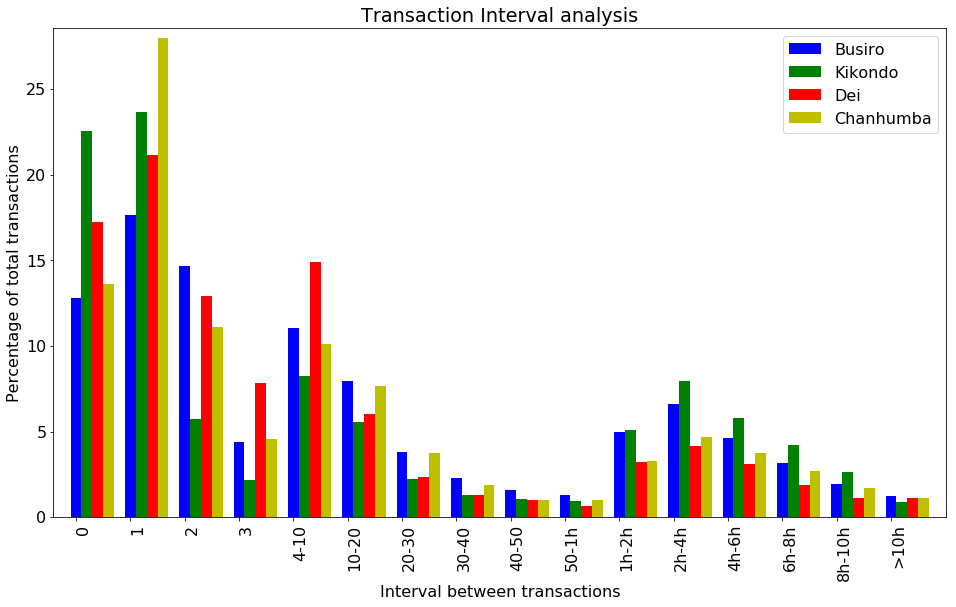

In [68]:
printTransactionIntervalAnalysisAllDistricts(districts)

In [69]:
timeDiffDF_multiTransaction = timeDiffDF[pd.notnull(timeDiffDF.Time_diff)].reset_index(drop = True)
timeDiffDF_multiTransaction['Minutes'] = np.round(timeDiffDF_multiTransaction.Time_diff.astype('timedelta64[s]') / 60, 0).astype(int)
timeDiffDF_multiTransaction.head()

District Smartcard_1       Date       Date_and_time       Time_previous  \
0   Busiro        1603 2016-02-09 2016-02-09 14:44:10                 NaT   
1   Busiro        1603 2016-02-09 2016-02-09 14:55:04 2016-02-09 14:44:10   
2   Busiro        1603 2016-02-09 2016-02-09 14:55:30 2016-02-09 14:55:04   
3   Busiro        1603 2016-02-09 2016-02-09 14:57:24 2016-02-09 14:55:30   
4   Busiro        1603 2016-02-09 2016-02-09 15:13:13 2016-02-09 14:57:24   

            Time_next Time_diff  Minutes  
0 2016-02-09 14:55:04  00:10:54       11  
1 2016-02-09 14:55:30  00:10:54       11  
2 2016-02-09 14:57:24  00:00:26        0  
3 2016-02-09 15:13:13  00:01:54        2  
4 2016-02-09 15:21:09  00:15:49       16

In [70]:
timeDiffDF_1Transaction = timeDiffDF[~pd.notnull(timeDiffDF.Time_diff)].reset_index(drop = True)
timeDiffDF_1Transaction['Group'] = '1 transaction'

In [71]:
timeDiffDF_multiTransaction['Group'] = pd.Series(timeDiffDF_multiTransaction.Minutes, index=timeDiffDF_multiTransaction.index).apply(getOperationGroup) 

In [72]:
timeDiffDF = timeDiffDF_multiTransaction.append(timeDiffDF_1Transaction)
timeDiffDF = timeDiffDF.sort_values(['District', 'Smartcard_1', 'Date_and_time'], ascending=[True, True, True])
timeDiffDF = timeDiffDF[['District', 'Smartcard_1', 'Date', 'Date_and_time', 'Minutes', 'Group']]
timeDiffDF['Count'] = 1

In [73]:
timeDiffDF_grouppedTransactions = timeDiffDF.groupby(['District', 'Group']).Count.sum().reset_index()
timeDiffDF_grouppedTransactions['Percentage'] = timeDiffDF_grouppedTransactions.apply(getPercentage, axis = 1)
timeDiffDF_grouppedTransactions.head()

District                  Group  Count  Percentage
0     Busiro          1 transaction  13785   14.049839
1     Busiro  multiple transactions  61000   62.171941
2     Busiro          multiple trip  23330   23.778219
3  Chanhumba          1 transaction   1746   13.025962
4  Chanhumba  multiple transactions   9194   68.591465

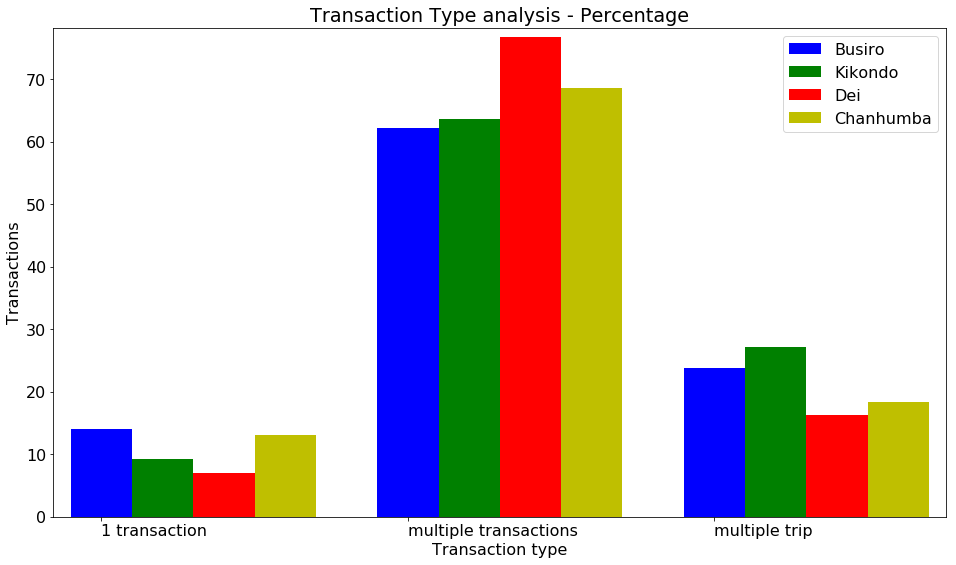

In [74]:
printTransactionTypeAnalysisPercentageAllDistricts(districts)

<a id="section7"></a>
## Section 14 - Card classification

Group     Busiro  Kikondo        Dei  Chanhumba
0    Creditor   0.665188      0.5   0.751880   0.000000
1          NA   4.212860      3.5   0.751880   4.087193
2  multiTrans  71.618625     67.0  86.466165  71.389646
3   multiTrip   8.425721     20.5   4.511278   7.356948
4    oneTrans  15.077605      8.5   7.518797  17.166213

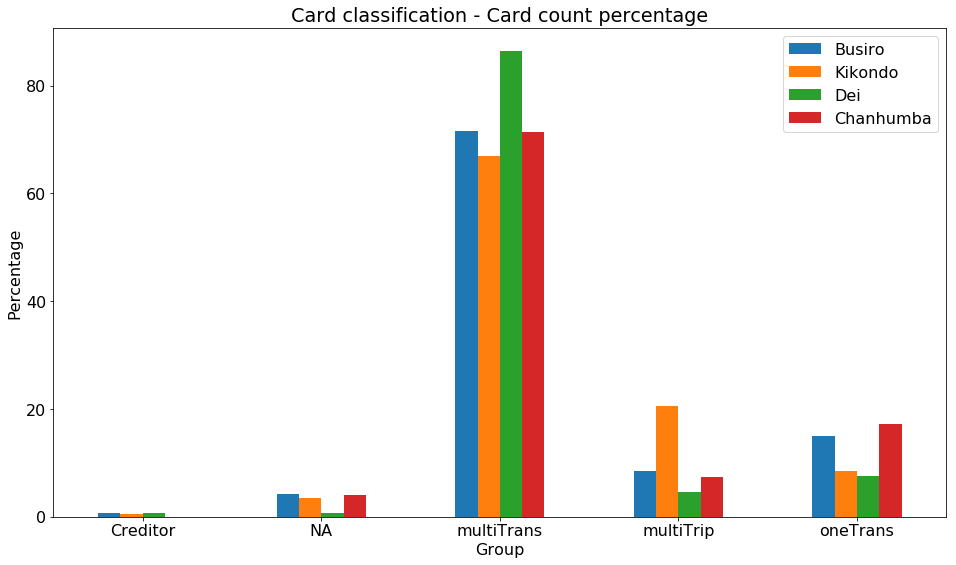

In [75]:
timeDiffDF_byCard = timeDiffDF.groupby(['District', 'Smartcard_1', 'Group']).Count.sum().reset_index()
timeDiffDF_byCard1 = timeDiffDF_byCard[timeDiffDF_byCard.Group == 'multiple transactions']
timeDiffDF_byCard2 = timeDiffDF_byCard[timeDiffDF_byCard.Group == '1 transaction']
timeDiffDF_byCard3 = timeDiffDF_byCard[timeDiffDF_byCard.Group == 'multiple trip']
timeDiffDF_byCard = pd.merge(timeDiffDF_byCard1, timeDiffDF_byCard2, on=['District', 'Smartcard_1'], how='outer').fillna(0)
timeDiffDF_byCard = pd.merge(timeDiffDF_byCard, timeDiffDF_byCard3, on=['District', 'Smartcard_1'], how='outer').fillna(0)
timeDiffDF_byCard = timeDiffDF_byCard[['District', 'Smartcard_1', 'Count_x', 'Count_y','Count']]
timeDiffDF_byCard.columns = ['District', 'Smartcard_1', 'multiple transactions', '1 transaction','multiple trip']
timeDiffDF_byCard['Group'] = timeDiffDF_byCard.apply(getCardGroup, axis = 1)
timeDiffDF_byCard['Count'] = 1
timeDiffDF_byCard_Groupped = timeDiffDF_byCard.groupby(['District', 'Group']).Count.sum().reset_index()
timeDiffDF_byCard_Groupped['Percentage'] = timeDiffDF_byCard_Groupped.apply(getCardCountPercentage, axis = 1)
timeDiffDF_byCard_Groupped_Busiro = timeDiffDF_byCard_Groupped[timeDiffDF_byCard_Groupped.District == 'Busiro']
timeDiffDF_byCard_Groupped_Kikondo = timeDiffDF_byCard_Groupped[timeDiffDF_byCard_Groupped.District == 'Kikondo']
timeDiffDF_byCard_Groupped_Dei = timeDiffDF_byCard_Groupped[timeDiffDF_byCard_Groupped.District == 'Dei']
timeDiffDF_byCard_Groupped_Chanhomba = timeDiffDF_byCard_Groupped[timeDiffDF_byCard_Groupped.District == 'Chanhumba']
timeDiffDF_byCard_Groupped = pd.merge(timeDiffDF_byCard_Groupped_Busiro[['Group', 'Percentage']], timeDiffDF_byCard_Groupped_Kikondo[['Group', 'Percentage']], on=['Group'], how='outer').fillna(0)
timeDiffDF_byCard_Groupped = pd.merge(timeDiffDF_byCard_Groupped, timeDiffDF_byCard_Groupped_Dei[['Group', 'Percentage']], on=['Group'], how='outer').fillna(0)
timeDiffDF_byCard_Groupped = pd.merge(timeDiffDF_byCard_Groupped, timeDiffDF_byCard_Groupped_Chanhomba[['Group', 'Percentage']], on=['Group'], how='outer').fillna(0)
timeDiffDF_byCard_Groupped.index = timeDiffDF_byCard_Groupped.Group
timeDiffDF_byCard_Groupped.columns = ['Group','Busiro','Kikondo','Dei','Chanhumba']
timeDiffDF_byCard_Groupped = timeDiffDF_byCard_Groupped[['Busiro','Kikondo','Dei','Chanhumba']]

ax = timeDiffDF_byCard_Groupped.plot(kind='bar',title='Card classification - Card count percentage');
ax.set_ylabel("Percentage")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)

timeDiffDF_byCard_Groupped.reset_index()

In [76]:
groupAnalyzis = pd.merge(resultset, timeDiffDF_byCard[['District', 'Smartcard_1', 'Group']], on = ['District', 'Smartcard_1'])
groupAnalyzis = groupAnalyzis[['Date', 'Date_and_time', 'District', 'Dispenser', 'Smartcard_1', 'Water_dispensed', 'Credits',
       'Balance', 'Credits_Add', 'Add_Credits_Mean',
       'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean',
       'Transaction_Count', 'Water_dispensed_Mean', 'LastBalance', 'Status', 'CreditGroup', 'Group']]

In [77]:
transCout = groupAnalyzis.groupby(['District', 'Group']).Date_and_time.count().reset_index()
transCout.columns = ['District', 'Group', 'TransactionCount']
transCout = transCout.set_index(['District', 'Group'])

In [78]:
watDispensed = groupAnalyzis.groupby(['District', 'Group']).Water_dispensed.mean().reset_index()
watDispensed.columns = ['District', 'Group', 'Water_dispensed_mean']
watDispensed = watDispensed.set_index(['District', 'Group'])

In [79]:
tempGroup = groupAnalyzis[['District', 'Smartcard_1', 'Group', 'Credits_Add', 'Add_Credits_Mean', 'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean',
       'Transaction_Count', 'Water_dispensed_Mean', 'LastBalance', 'Status']].drop_duplicates()

In [80]:
cardNumbersByCardType = tempGroup.groupby(['District', 'Group']).Smartcard_1.count().reset_index()
cardNumbersByCardType.columns = ['District', 'Group', 'CardNumbers']
cardNumbersByCardType = cardNumbersByCardType.set_index(['District', 'Group'])

In [81]:
averageBalanceByCardType = tempGroup.groupby(['District', 'Group']).LastBalance.mean().reset_index()
averageBalanceByCardType.columns = ['District', 'Group', 'AverageBalance']
averageBalanceByCardType.AverageBalance  = averageBalanceByCardType.AverageBalance.apply(np.round)
averageBalanceByCardType = averageBalanceByCardType.set_index(['District', 'Group'])

In [82]:
averageNumberOfRenewalsByCardType = tempGroup.groupby(['District', 'Group']).Credits_Add.mean().reset_index()
averageNumberOfRenewalsByCardType.columns = ['District', 'Group', 'AverageRenewalCount']
averageNumberOfRenewalsByCardType.AverageRenewalCount  = averageNumberOfRenewalsByCardType.AverageRenewalCount.apply(np.round)
averageNumberOfRenewalsByCardType = averageNumberOfRenewalsByCardType.set_index(['District', 'Group'])

In [83]:
averageAmountOfRenewalsByCardType = tempGroup[~tempGroup.Add_Credits_Mean.isnull()].groupby(['District', 'Group']).Add_Credits_Mean.mean().reset_index()
averageAmountOfRenewalsByCardType.columns = ['District', 'Group', 'AverageRenewalAmount']
averageAmountOfRenewalsByCardType.AverageRenewalAmount  = averageAmountOfRenewalsByCardType.AverageRenewalAmount.apply(np.round)
averageAmountOfRenewalsByCardType = averageAmountOfRenewalsByCardType.set_index(['District', 'Group'])

In [84]:
balanceBeforeRenewalByCardType = tempGroup.groupby(['District', 'Group']).Balance_Before_Credit_Min.mean().reset_index()
balanceBeforeRenewalByCardType.columns = ['District', 'Group', 'MinBalanceBeforeRenewal']
balanceBeforeRenewalByCardType.MinBalanceBeforeRenewal  = balanceBeforeRenewalByCardType.MinBalanceBeforeRenewal.apply(np.round)
balanceBeforeRenewalByCardType = balanceBeforeRenewalByCardType.set_index(['District', 'Group'])

In [85]:
averageBalanceBeforeRenewalByCardType = tempGroup.groupby(['District', 'Group']).Balance_Before_Credit_Mean.mean().reset_index()
averageBalanceBeforeRenewalByCardType.columns = ['District', 'Group', 'AveBalanceBeforeRenewal']
averageBalanceBeforeRenewalByCardType.AveBalanceBeforeRenewal  = averageBalanceBeforeRenewalByCardType.AveBalanceBeforeRenewal.apply(np.round)
averageBalanceBeforeRenewalByCardType = averageBalanceBeforeRenewalByCardType.set_index(['District', 'Group'])

In [86]:
resultByCardType = pd.concat([transCout, cardNumbersByCardType, watDispensed, averageBalanceBeforeRenewalByCardType, balanceBeforeRenewalByCardType, averageNumberOfRenewalsByCardType
                    , averageAmountOfRenewalsByCardType, averageBalanceByCardType], axis=1)
resultByCardType = resultByCardType.reset_index()
resultByCardType.columns = ['District', 'Group', 'TransactionCount', 'CardCount','Water_dispensed_mean', 'AveBalanceBeforeRenewal', 'MinBalanceBeforeRenewal', 'AverageRenewalCount', 
                            'AverageRenewalAmount', 'AverageBalance']
resultByCardType.head()

District       Group  TransactionCount  CardCount  Water_dispensed_mean  \
0   Busiro    Creditor              2642          3             17.950757   
1   Busiro          NA              3086         19             18.161892   
2   Busiro  multiTrans             68301        323             20.385611   
3   Busiro   multiTrip             19075         38             18.233478   
4   Busiro    oneTrans              5011         68             20.128817   

   AveBalanceBeforeRenewal  MinBalanceBeforeRenewal  AverageRenewalCount  \
0                   2226.0                     54.0                 82.0   
1                    129.0                     51.0                 18.0   
2                    202.0                     44.0                 25.0   
3                    150.0                      0.0                 74.0   
4                    379.0                    122.0                  9.0   

   AverageRenewalAmount  AverageBalance  
0                6727.0          3334.0  
1                1283.0           260.0  
2                1025.0           417.0  
3                 816.0          1458.0  
4                1154.0           504.0

        Group  Busiro  Kikondo    Dei  Chanhumba
0    Creditor    2642       16    190        0.0
1          NA    3086     1829    129      341.0
2  multiTrans   68301    79387  27358    11240.0
3   multiTrip   19075    38436   1825     1307.0
4    oneTrans    5011     1762    220      516.0


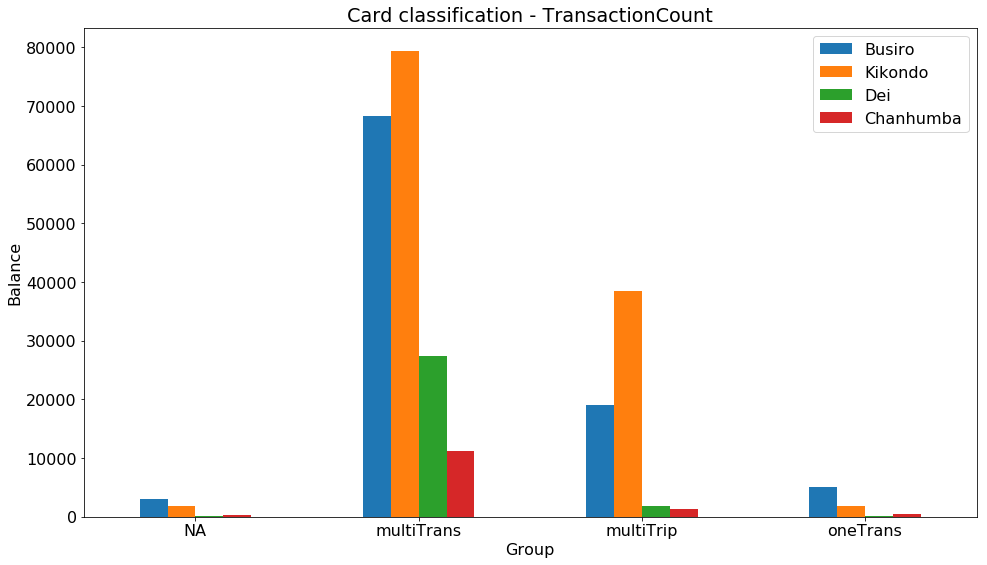

        Group  Busiro  Kikondo  Dei  Chanhumba
0    Creditor       3        1    1        0.0
1          NA      19        7    1       15.0
2  multiTrans     323      134  115      262.0
3   multiTrip      38       41    6       27.0
4    oneTrans      68       17   10       63.0


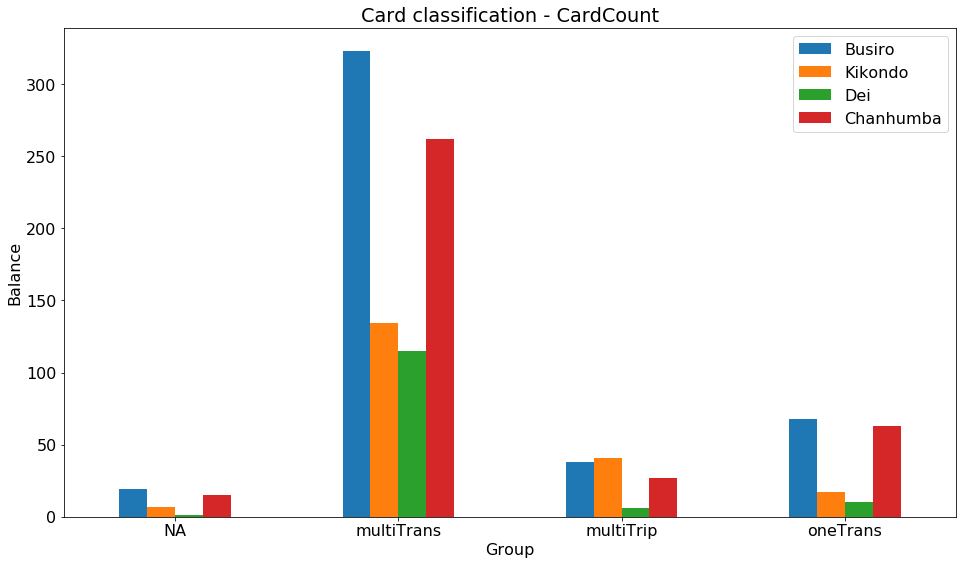

        Group     Busiro    Kikondo        Dei  Chanhumba
0    Creditor  17.950757   4.593750   4.598421   0.000000
1          NA  18.161892  18.849973  14.922481  21.823460
2  multiTrans  20.385611  15.985773  11.471018  20.050480
3   multiTrip  18.233478  15.532290  10.800384  18.487605
4    oneTrans  20.128817  18.946481  13.386364  26.748450


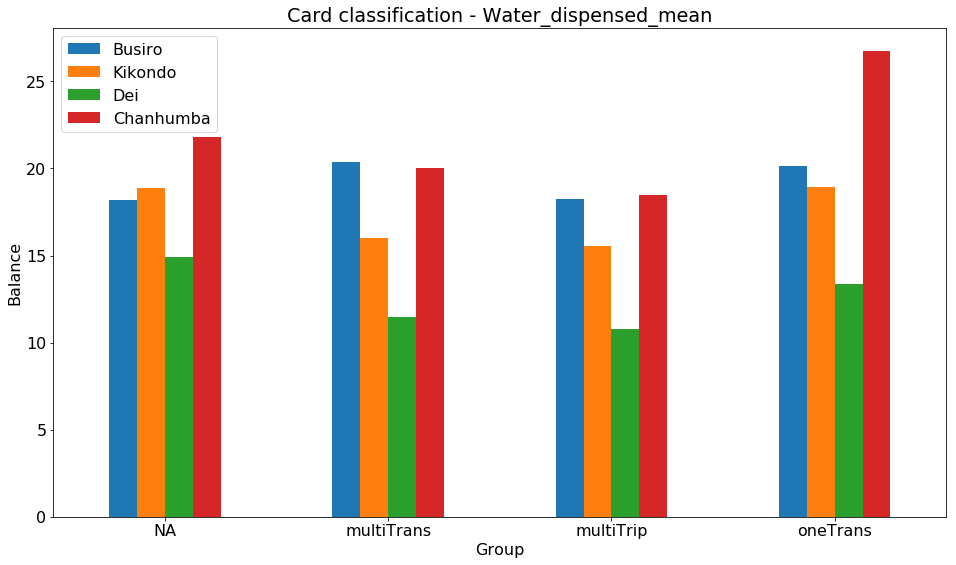

        Group  Busiro  Kikondo     Dei  Chanhumba
0    Creditor  2226.0  12402.0  8670.0        0.0
1          NA   129.0     31.0    20.0       19.0
2  multiTrans   202.0    139.0    74.0      283.0
3   multiTrip   150.0     98.0  1526.0       52.0
4    oneTrans   379.0    719.0   128.0       88.0


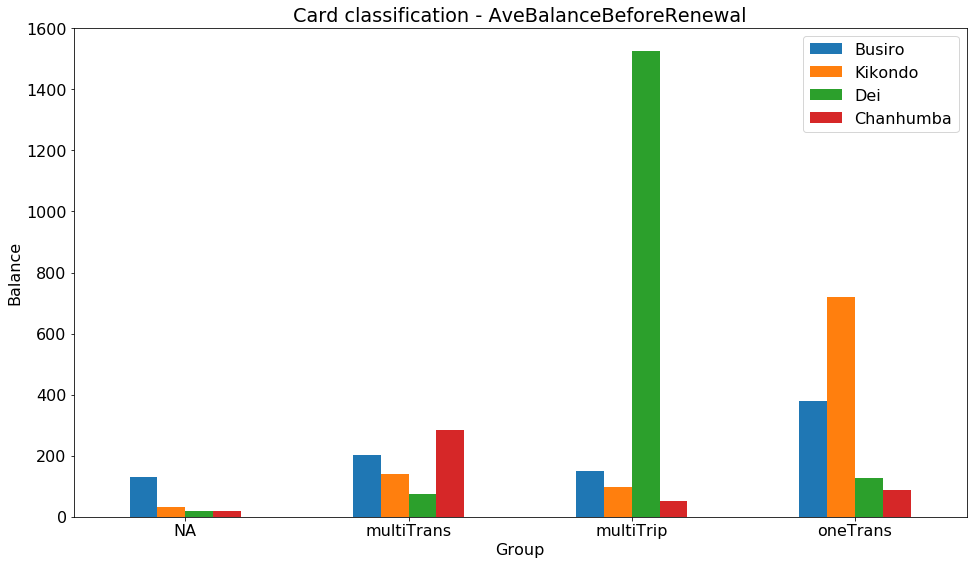

        Group  Busiro  Kikondo     Dei  Chanhumba
0    Creditor    54.0     80.0  3861.0        0.0
1          NA    51.0      1.0     2.0       16.0
2  multiTrans    44.0     69.0     2.0       59.0
3   multiTrip     0.0      0.0     1.0        1.0
4    oneTrans   122.0     42.0     1.0       23.0


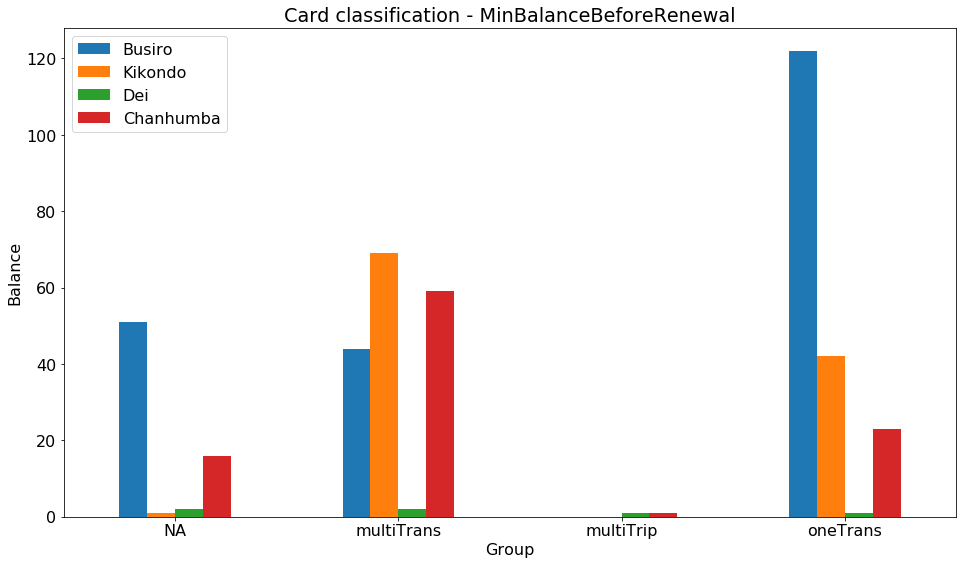

        Group  Busiro  Kikondo   Dei  Chanhumba
0    Creditor    82.0      5.0   2.0        0.0
1          NA    18.0     11.0  13.0        3.0
2  multiTrans    25.0     27.0  15.0        4.0
3   multiTrip    74.0     40.0  21.0        5.0
4    oneTrans     9.0      4.0   4.0        2.0


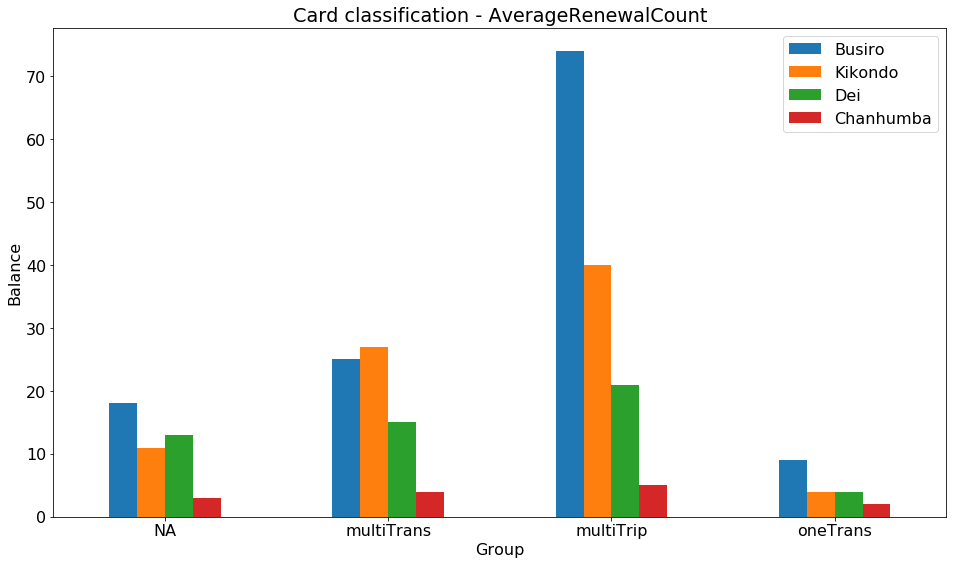

        Group  Busiro  Kikondo       Dei  Chanhumba
0    Creditor  6727.0  46695.0  171445.0        0.0
1          NA  1283.0    893.0     531.0      612.0
2  multiTrans  1025.0    944.0     865.0     1306.0
3   multiTrip   816.0   1093.0   32947.0     1270.0
4    oneTrans  1154.0   4827.0     900.0      743.0


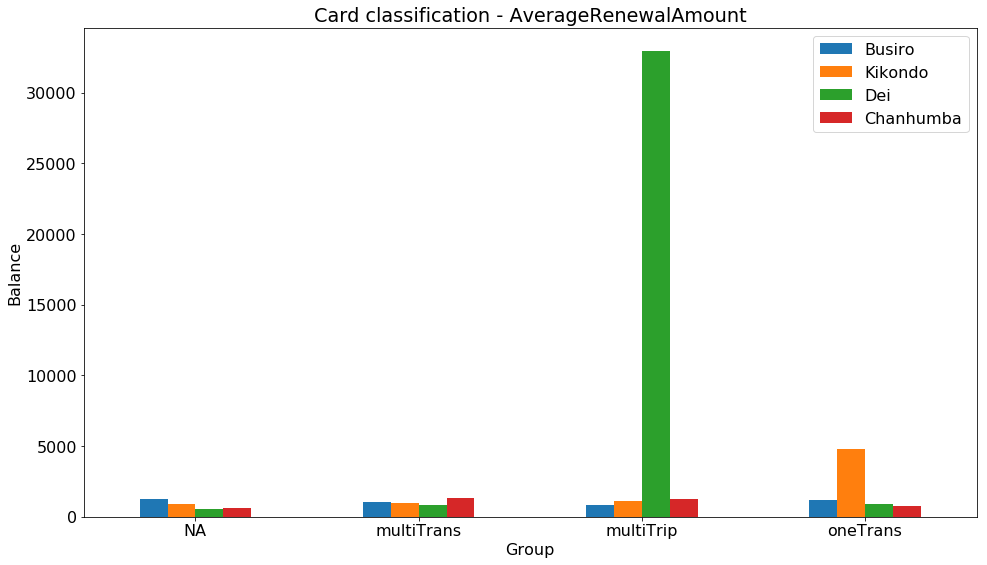

        Group  Busiro  Kikondo       Dei  Chanhumba
0    Creditor  3334.0     75.0  159428.0        0.0
1          NA   260.0    148.0       4.0      454.0
2  multiTrans   417.0    467.0     215.0     1436.0
3   multiTrip  1458.0    532.0   15116.0    27506.0
4    oneTrans   504.0   2221.0   25837.0      513.0


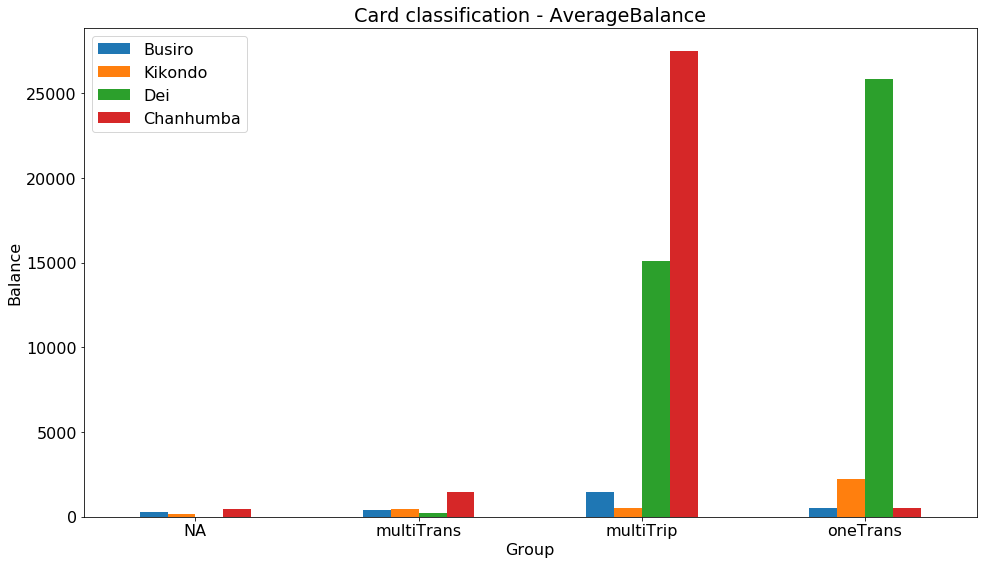

In [87]:
#@interact(ind = list(resultByCardType.columns)[2:])
def printNumbersOfIntervals(ind):
    resultByCardType_Busiro = resultByCardType[resultByCardType.District == 'Busiro']
    resultByCardType_Kikondo = resultByCardType[resultByCardType.District == 'Kikondo']
    resultByCardType_Dei = resultByCardType[resultByCardType.District == 'Dei']
    resultByCardType_Chanhumba = resultByCardType[resultByCardType.District == 'Chanhumba']
    resultByCardTypeNew = pd.merge(resultByCardType_Busiro[['Group', ind]], resultByCardType_Kikondo[['Group', ind]], on=['Group'], how='outer').fillna(0)
    resultByCardTypeNew = pd.merge(resultByCardTypeNew, resultByCardType_Dei[['Group', ind]], on=['Group'], how='outer').fillna(0)
    resultByCardTypeNew = pd.merge(resultByCardTypeNew, resultByCardType_Chanhumba[['Group', ind]], on=['Group'], how='outer').fillna(0)
    resultByCardTypeNew.index = resultByCardTypeNew.Group
    resultByCardTypeNew.columns = ['Group','Busiro','Kikondo','Dei','Chanhumba']
    resultByCardTypeNew = resultByCardTypeNew[['Busiro','Kikondo','Dei','Chanhumba']]

    ax = resultByCardTypeNew[resultByCardTypeNew.index != 'Creditor'].plot(kind='bar',title='Card classification - ' + ind);
    ax.set_ylabel("Balance")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    print(resultByCardTypeNew.reset_index())
    plt.show()
    return resultByCardTypeNew.reset_index()

for ind in list(resultByCardType.columns)[2:]:
    printNumbersOfIntervals(ind)

<a id="section8"></a>
## Section 15 - Comparing 119 and 121 kiosks in Busiro

In this section we compare two kiosks in Busiro with general indexes from the report. 

In [88]:
dds2 = prepareDispenserTransactionData(waterUsageRDD_Busiro)

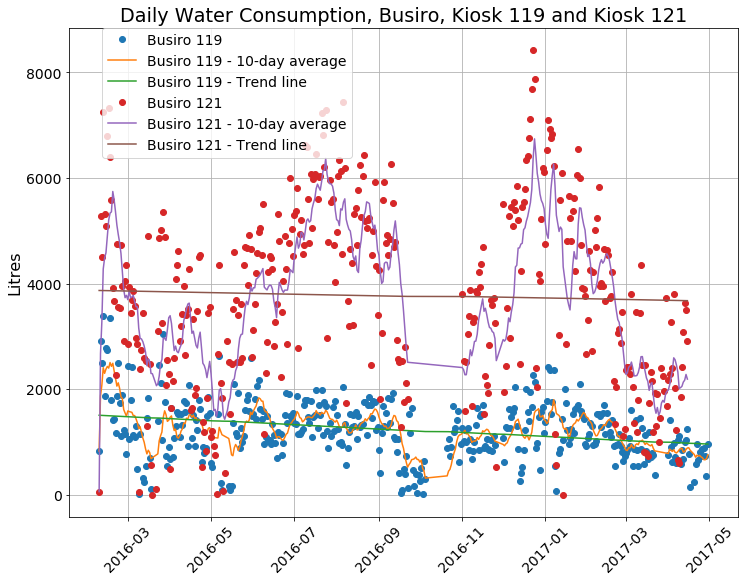

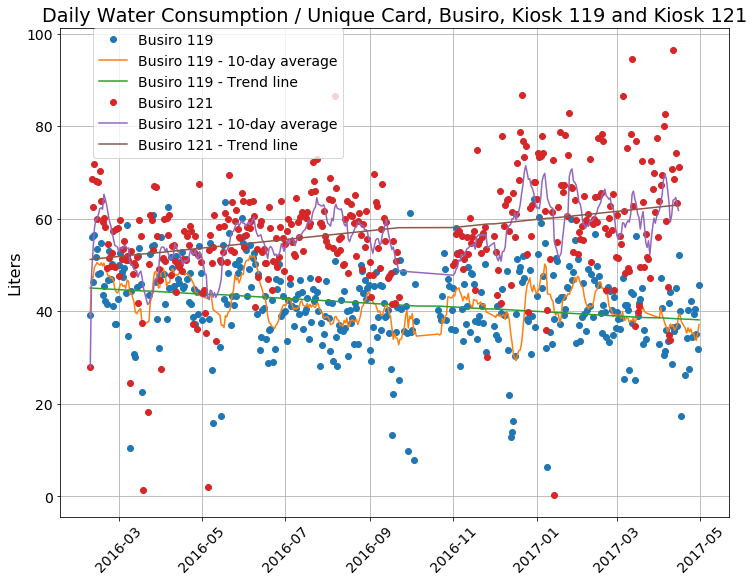

In [89]:
def showTrendsByDispensers(district, key, weeksToTrim, showPoints, showAverage):
    dsNames = list(dds2['dispenser'].drop_duplicates())
    data = dds2
    data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
    data = data.sort_values('date', ascending = True)
    #data = data[data.isoweek > 30]
   
    field = series2[key]['field']
    
    data = trimInitialWeeks(data, int(weeksToTrim))
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel(series2[key]['measure'])
    plt.xticks(rotation=90)
    #data = data[pd.to_datetime(data.date) < pd.to_datetime('2016-09-15', format='%Y-%m-%d')]
    
    legend = list()
    for name in dsNames:
        d = data[data.dispenser == name].reset_index(drop = True)
        x = d.date
        y = d[field]
        #name = name.replace('Busiro', 'Site 2, Kiosk ').replace('119', '1').replace('121', '2')
        if showPoints:
            plt.plot(x, y, 'o')
            legend.append(name)
        
        # calc 10-day average
        if showAverage:
            plt.plot(x, movingAverage(y, 10) ,"-")
            legend.append(name + " - 10-day average")

        # calc the trendline
        i = x.index
        z = np.polyfit(i, y, 1)
        p = np.poly1d(z)

        t = data.index.map(lambda x: p(x))
        plt.plot(x, p(i),"-")
        legend.append(name + " - Trend line")
    
    plt.legend(legend)
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.title('Daily ' + key + ', Busiro, Kiosk 119 and Kiosk 121')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    plt.legend(legend, bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0., fontsize=14)
    plt.show()
    
series2 = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'}}

series3 = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'}}

weeksToTrim = 0
showAverage = True
showPoints = True

for i in series2:
    showTrendsByDispensers('Busiro', i, weeksToTrim, showPoints, showAverage)

Number of smartcards
Dispenser                        
Busiro 119                    144
Busiro 121                    204
Both kiosks                   103

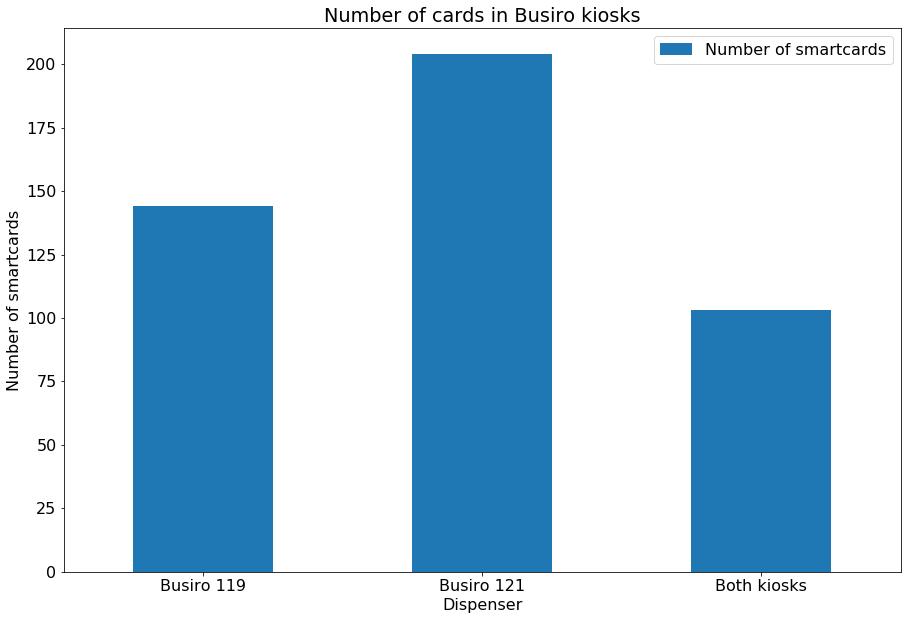

In [90]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

cn_df = resultset[resultset.District == 'Busiro'][['Dispenser','Smartcard_1']].drop_duplicates()
cn_df_both = cn_df.groupby(['Smartcard_1']).Dispenser.count().reset_index()
cn_df_both = cn_df_both[cn_df_both.Dispenser > 1]
both = len(cn_df_both)
cn_df = cn_df[~cn_df.Smartcard_1.isin(list(cn_df_both.Smartcard_1))]
cn_df=cn_df.groupby(['Dispenser']).Smartcard_1.count().reset_index()

cn_df = cn_df.append([{'Dispenser':'Both kiosks', 'Smartcard_1' : both}])
cn_df.index = cn_df.Dispenser
cn_df = cn_df.drop(['Dispenser'], axis = 1)

cn_df.columns = ['Number of smartcards']
ax = cn_df.plot(kind='bar',title='Number of cards in Busiro kiosks');
ax.set_ylabel("Number of smartcards")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)

cn_df

Dispenser  Transaction_id
0  Busiro 119           25205
1  Busiro 121           72910

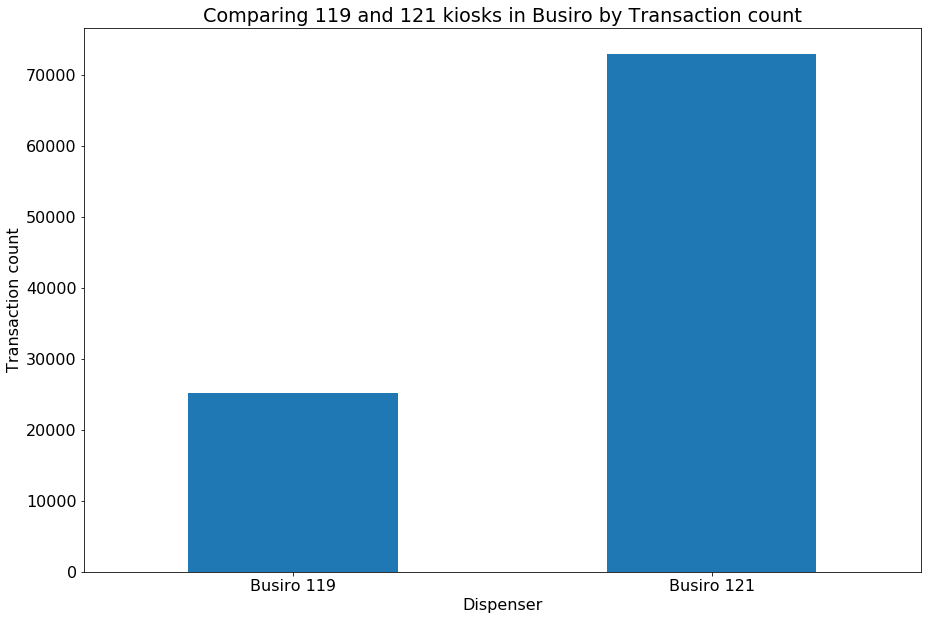

In [91]:
def chartTransactionNumbersOfBusiroDispensers():
    d1 = resultset[resultset.District == 'Busiro']
    d1 = d1[['Dispenser', 'Smartcard_1', 'Transaction_id']].groupby(['Dispenser'])['Transaction_id'].count()
    ax = d1.plot(kind='bar',title='Comparing 119 and 121 kiosks in Busiro by Transaction count');
    ax.set_ylabel("Transaction count")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)

    return d1.reset_index()

chartTransactionNumbersOfBusiroDispensers()

    Dispenser  Water_dispensed_Mean
0  Busiro 119             21.060891
1  Busiro 121             21.392296


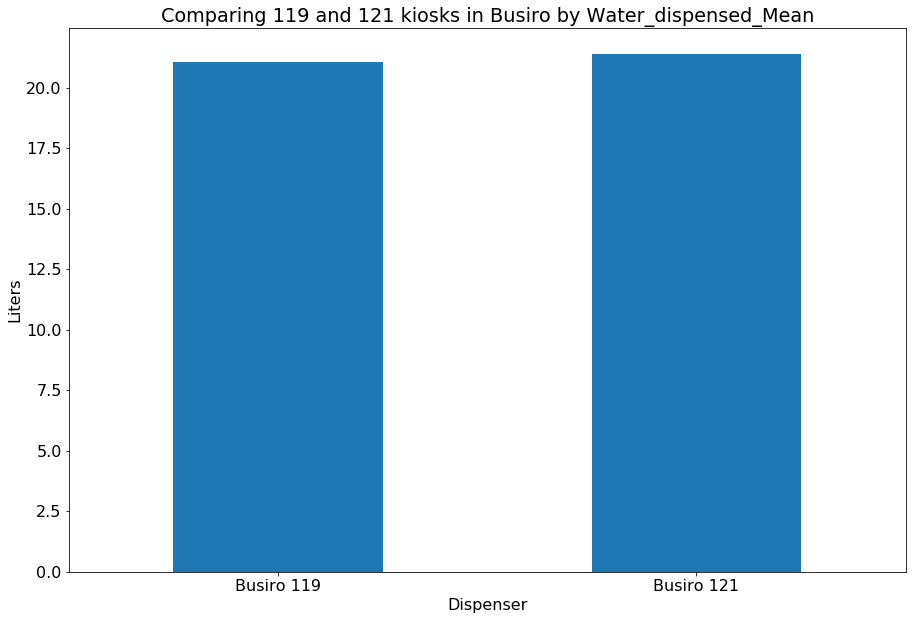

    Dispenser  Balance_Before_Credit_Mean
0  Busiro 119                  246.316018
1  Busiro 121                  218.648601


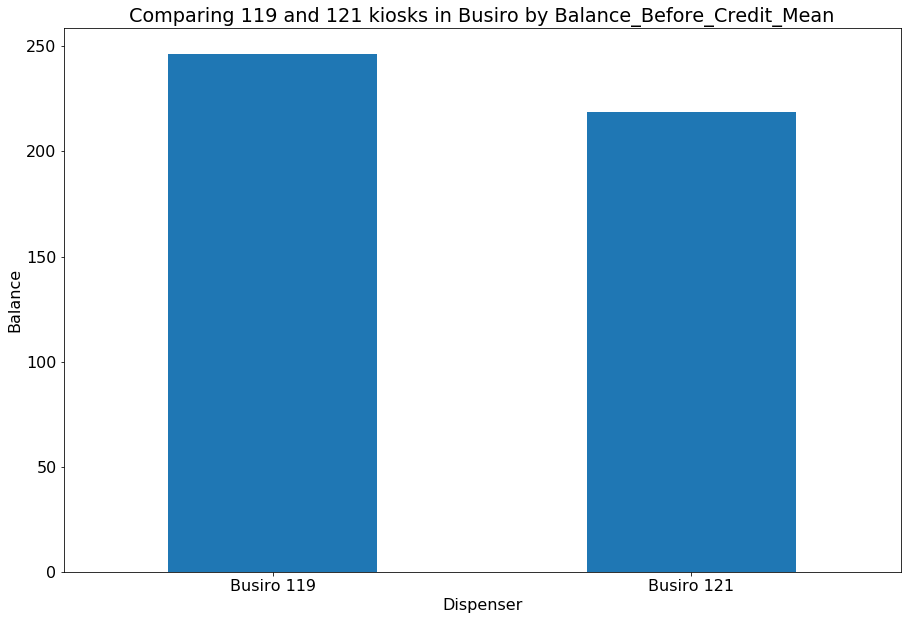

    Dispenser  Balance_Before_Credit_Min
0  Busiro 119                  46.952703
1  Busiro 121                  39.669014


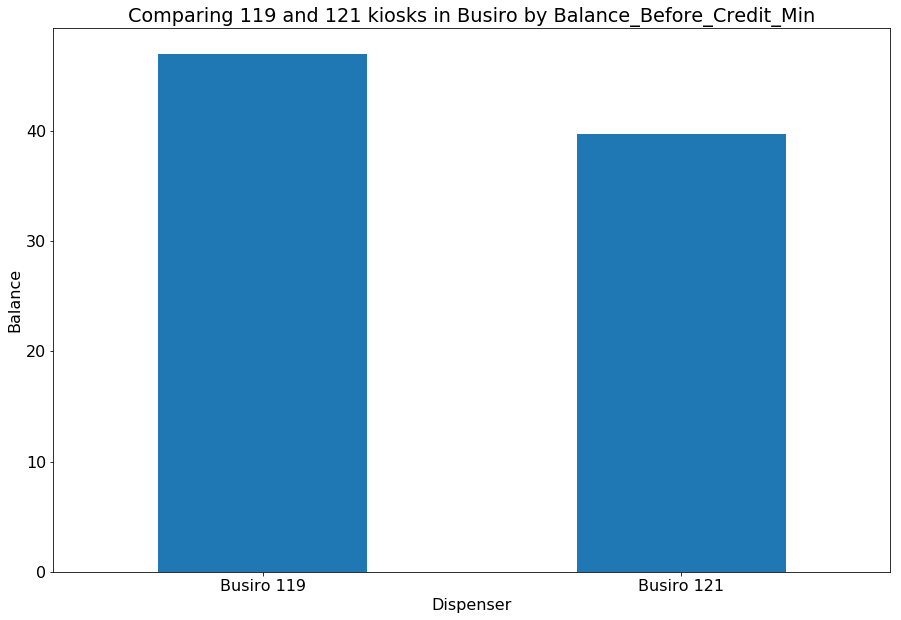

    Dispenser  Credits_Add
0  Busiro 119    18.409910
1  Busiro 121    34.359155


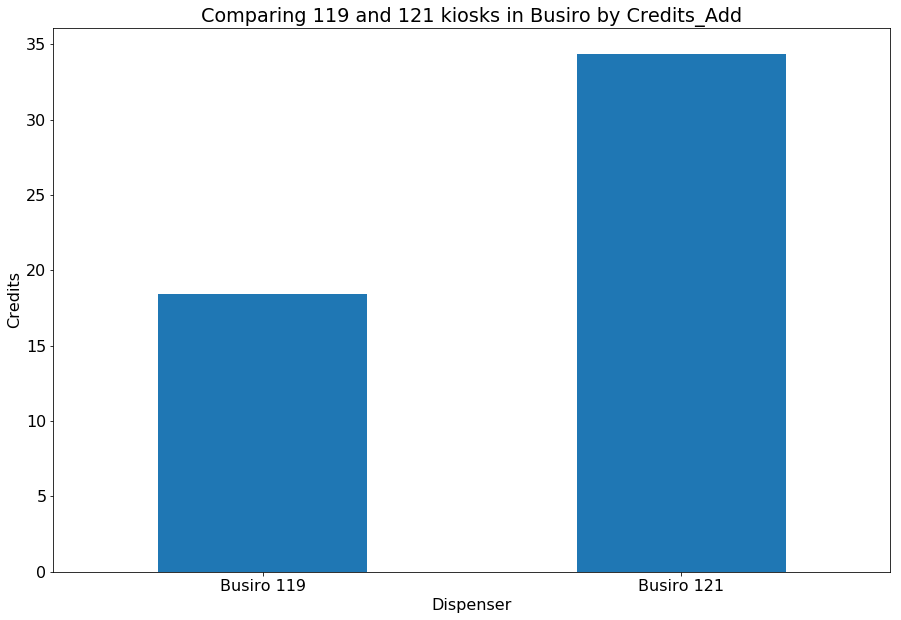

    Dispenser  Add_Credits_Mean
0  Busiro 119       1209.019626
1  Busiro 121        971.658046


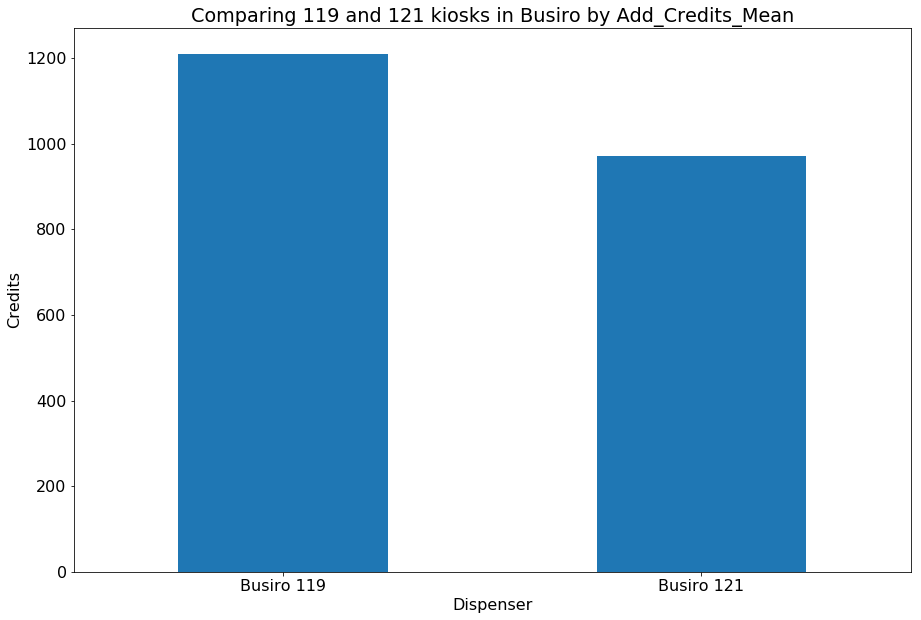

    Dispenser  LastBalance
0  Busiro 119   327.376518
1  Busiro 121   597.581498


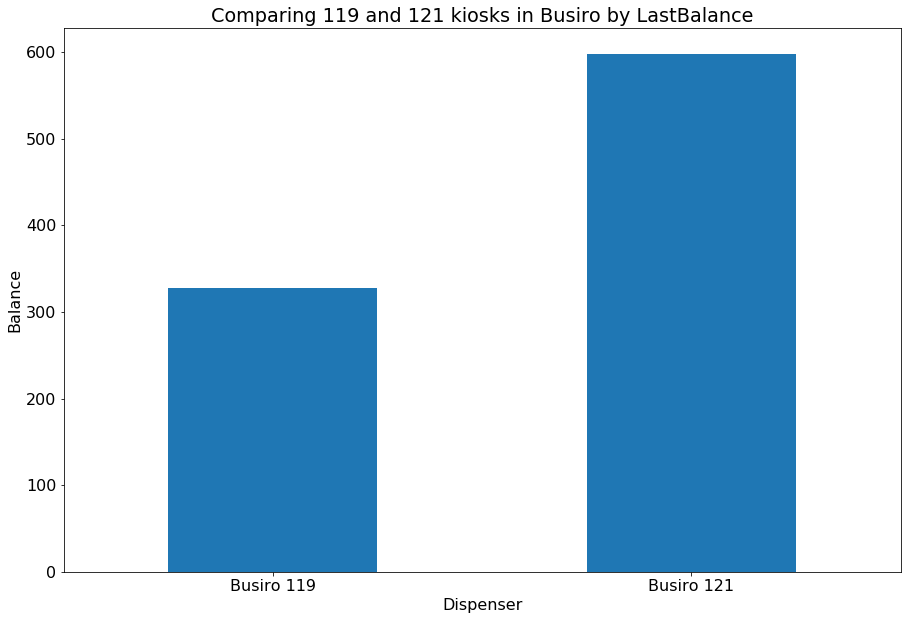

In [92]:
#@interact(ind = ['Water_dispensed_Mean', 'Balance_Before_Credit_Mean','Balance_Before_Credit_Min', 'Credits_Add', 'Add_Credits_Mean', 'LastBalance'])
def printNumbersOfIntervals(ind):
    d1 = resultset[resultset.District == 'Busiro']
    d1 = d1[['Dispenser', 'Smartcard_1', ind]].drop_duplicates().groupby(['Dispenser'])[ind].mean()
    ax = d1.plot(kind='bar',title='Comparing 119 and 121 kiosks in Busiro by ' + ind)
    y_label = 'Balance'
    if(ind == 'Water_dispensed_Mean'):
        y_label = 'Liters'
    elif(ind == 'Credits_Add'):
        y_label = 'Credits'
    elif(ind == 'Add_Credits_Mean'):
        y_label = 'Credits'

    ax.set_ylabel(y_label)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    
    print(d1.reset_index())
    plt.show()
    return d1.reset_index()

for ind in ['Water_dispensed_Mean', 'Balance_Before_Credit_Mean','Balance_Before_Credit_Min', 'Credits_Add', 
            'Add_Credits_Mean', 'LastBalance']:
    printNumbersOfIntervals(ind)

In [93]:
groupAnalyzisBusiroDispensers = pd.merge(resultset[resultset.District == 'Busiro'], timeDiffDF_byCard[['District', 'Smartcard_1', 'Group']], on = ['District', 'Smartcard_1'])
groupAnalyzisBusiroDispensers = groupAnalyzisBusiroDispensers[['Date', 'Date_and_time', 'District', 'Dispenser', 'Smartcard_1', 'Water_dispensed', 'Credits',
       'Balance', 'Credits_Add', 'Add_Credits_Mean',
       'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean',
       'Transaction_Count', 'Water_dispensed_Mean', 'LastBalance', 'Group']]
groupAnalyzisBusiroDispensers.head()

Date       Date_and_time District   Dispenser Smartcard_1  \
0 2016-02-09 2016-02-09 14:44:10   Busiro  Busiro 121        1603   
1 2016-02-09 2016-02-09 14:55:04   Busiro  Busiro 121        1603   
2 2016-02-09 2016-02-09 14:55:30   Busiro  Busiro 121        1603   
3 2016-02-09 2016-02-09 14:57:24   Busiro  Busiro 121        1603   
4 2016-02-09 2016-02-09 15:13:13   Busiro  Busiro 121        1603   

   Water_dispensed  Credits   Balance  Credits_Add  Add_Credits_Mean  \
0              1.2      9.0  57928.52          NaN               NaN   
1              0.4      2.0  57920.52          NaN               NaN   
2              0.8      4.0  57916.52          NaN               NaN   
3              1.2      6.0  57910.52          NaN               NaN   
4              6.5     32.5  57878.02          NaN               NaN   

   Balance_Before_Credit_Min  Balance_Before_Credit_Mean  Transaction_Count  \
0                        NaN                         NaN                  7   
1                        NaN                         NaN                  7   
2                        NaN                         NaN                  7   
3                        NaN                         NaN                  7   
4                        NaN                         NaN                  7   

   Water_dispensed_Mean  LastBalance       Group  
0              1.857143     57863.52  multiTrans  
1              1.857143     57863.52  multiTrans  
2              1.857143     57863.52  multiTrans  
3              1.857143     57863.52  multiTrans  
4              1.857143     57863.52  multiTrans

In [94]:
transCout2 = groupAnalyzisBusiroDispensers.groupby(['Dispenser',  'Group']).Date_and_time.count().reset_index()
transCout2.columns = ['Dispenser',  'Group', 'TransactionCount']
transCout2 = transCout2.set_index(['Dispenser',  'Group'])

watDispensed2 = groupAnalyzisBusiroDispensers.groupby(['Dispenser',  'Group']).Water_dispensed.mean().reset_index()
watDispensed2.columns = ['Dispenser',  'Group', 'Water_dispensed_mean']
watDispensed2 = watDispensed2.set_index(['Dispenser',  'Group'])

tempGroup2 = groupAnalyzisBusiroDispensers[['Dispenser',  'Group', 'Smartcard_1', 'Credits_Add', 'Add_Credits_Mean', 'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean',
       'Transaction_Count', 'Water_dispensed_Mean', 'LastBalance']].drop_duplicates()

cardCout2 = tempGroup2.groupby(['Dispenser',  'Group']).Smartcard_1.count().reset_index()
cardCout2.columns = ['Dispenser',  'Group', 'cardCount']
cardCout2 = cardCout2.set_index(['Dispenser',  'Group'])


cardNumbersByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Smartcard_1.count().reset_index()
cardNumbersByCardType2.columns = ['Dispenser',  'Group', 'CardNumbers']
cardNumbersByCardType2 = cardNumbersByCardType2.set_index(['Dispenser',  'Group'])

averageBalanceByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).LastBalance.mean().reset_index()
averageBalanceByCardType2.columns = ['Dispenser',  'Group', 'AverageBalance']
averageBalanceByCardType2.AverageBalance  = averageBalanceByCardType2.AverageBalance.apply(np.round)
averageBalanceByCardType2 = averageBalanceByCardType2.set_index(['Dispenser',  'Group'])

averageNumberOfRenewalsByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Credits_Add.mean().reset_index()
averageNumberOfRenewalsByCardType2.columns = ['Dispenser',  'Group', 'AverageRenewalCount']
averageNumberOfRenewalsByCardType2.AverageRenewalCount  = averageNumberOfRenewalsByCardType2.AverageRenewalCount.apply(np.round)
averageNumberOfRenewalsByCardType2 = averageNumberOfRenewalsByCardType2.set_index(['Dispenser',  'Group'])

averageAmountOfRenewalsByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Add_Credits_Mean.mean().reset_index()
averageAmountOfRenewalsByCardType2.columns = ['Dispenser',  'Group', 'AverageRenewalAmount']
averageAmountOfRenewalsByCardType2.AverageRenewalAmount  = averageAmountOfRenewalsByCardType2.AverageRenewalAmount.apply(np.round)
averageAmountOfRenewalsByCardType2 = averageAmountOfRenewalsByCardType2.set_index(['Dispenser',  'Group'])

balanceBeforeRenewalByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Balance_Before_Credit_Min.mean().reset_index()
balanceBeforeRenewalByCardType2.columns = ['Dispenser',  'Group', 'MinBalanceBeforeRenewal']
balanceBeforeRenewalByCardType2.MinBalanceBeforeRenewal  = balanceBeforeRenewalByCardType2.MinBalanceBeforeRenewal.apply(np.round)
balanceBeforeRenewalByCardType2 = balanceBeforeRenewalByCardType2.set_index(['Dispenser',  'Group'])

averageBalanceBeforeRenewalByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Balance_Before_Credit_Mean.mean().reset_index()
averageBalanceBeforeRenewalByCardType2.columns = ['Dispenser',  'Group', 'AveBalanceBeforeRenewal']
averageBalanceBeforeRenewalByCardType2.AveBalanceBeforeRenewal  = averageBalanceBeforeRenewalByCardType2.AveBalanceBeforeRenewal.apply(np.round)
averageBalanceBeforeRenewalByCardType2 = averageBalanceBeforeRenewalByCardType2.set_index(['Dispenser',  'Group'])

resultByCardType_BusDispensers = pd.concat([cardCout2, transCout2, watDispensed2, averageBalanceBeforeRenewalByCardType2, balanceBeforeRenewalByCardType2, averageNumberOfRenewalsByCardType2
                    , averageAmountOfRenewalsByCardType2, averageBalanceByCardType2], axis=1)
resultByCardType_BusDispensers = resultByCardType_BusDispensers.reset_index()
resultByCardType_BusDispensers.columns = ['Dispenser',  'Group', 'CardCount', 'TransactionCount', 'Water_dispensed_mean', 'AveBalanceBeforeRenewal', 'MinBalanceBeforeRenewal', 'AverageRenewalCount', 
                            'AverageRenewalAmount', 'AverageBalance']
resultByCardType_BusDispensers = resultByCardType_BusDispensers[['Dispenser',  'Group', 'CardCount', 'TransactionCount', 'Water_dispensed_mean', 'AveBalanceBeforeRenewal', 'MinBalanceBeforeRenewal', 'AverageRenewalCount', 
                            'AverageRenewalAmount', 'AverageBalance']]
resultByCardType_BusDispensers = resultByCardType_BusDispensers[(resultByCardType_BusDispensers.Group != 'NA') & (resultByCardType_BusDispensers.Group != 'Creditor')]
resultByCardType_BusDispensers.head()

Dispenser       Group  CardCount  TransactionCount  Water_dispensed_mean  \
2  Busiro 119  multiTrans        163             17132             20.703677   
3  Busiro 119   multiTrip         14              3027             15.636472   
4  Busiro 119    oneTrans         52              3010             19.826246   
7  Busiro 121  multiTrans        237             51169             20.279118   
8  Busiro 121   multiTrip         33             16048             18.723330   

   AveBalanceBeforeRenewal  MinBalanceBeforeRenewal  AverageRenewalCount  \
2                    172.0                     35.0                 19.0   
3                    227.0                      0.0                 37.0   
4                    401.0                     98.0                  7.0   
7                    211.0                     38.0                 30.0   
8                    166.0                      0.0                 79.0   

   AverageRenewalAmount  AverageBalance  
2                1064.0           231.0  
3                1058.0            78.0  
4                1289.0           523.0  
7                 967.0           460.0  
8                 811.0          1667.0

        Group  Busiro 119  Busiro 121
0  multiTrans         163         237
1   multiTrip          14          33
2    oneTrans          52          28


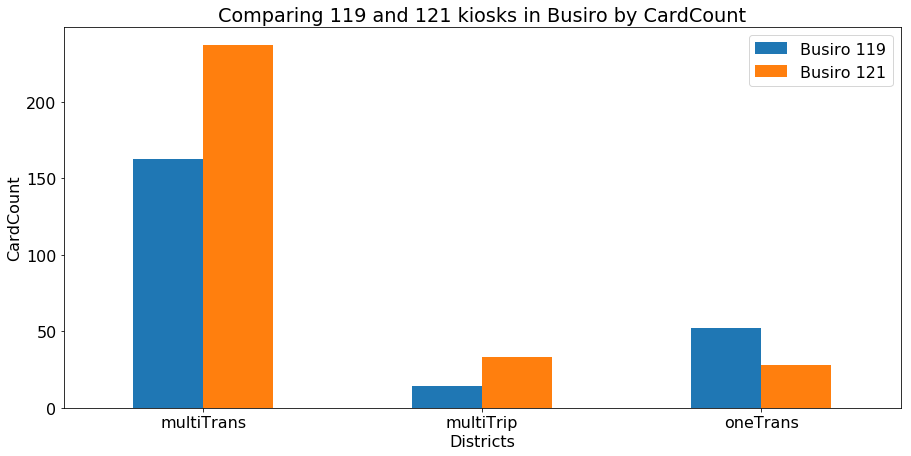

        Group  Busiro 119  Busiro 121
0  multiTrans       17132       51169
1   multiTrip        3027       16048
2    oneTrans        3010        2001


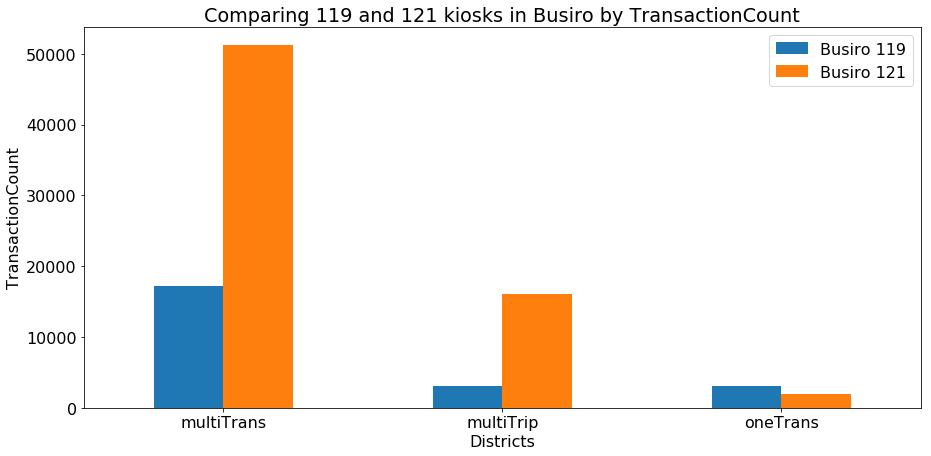

        Group  Busiro 119  Busiro 121
0  multiTrans   20.703677   20.279118
1   multiTrip   15.636472   18.723330
2    oneTrans   19.826246   20.583958


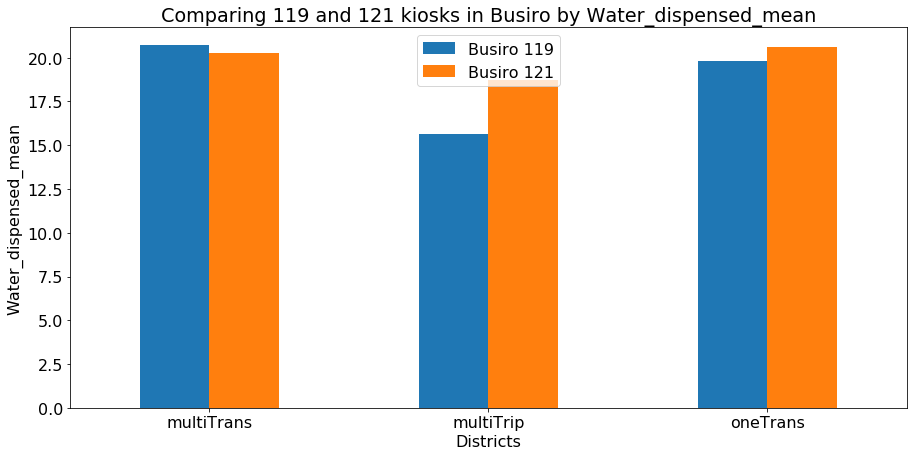

        Group  Busiro 119  Busiro 121
0  multiTrans       172.0       211.0
1   multiTrip       227.0       166.0
2    oneTrans       401.0       211.0


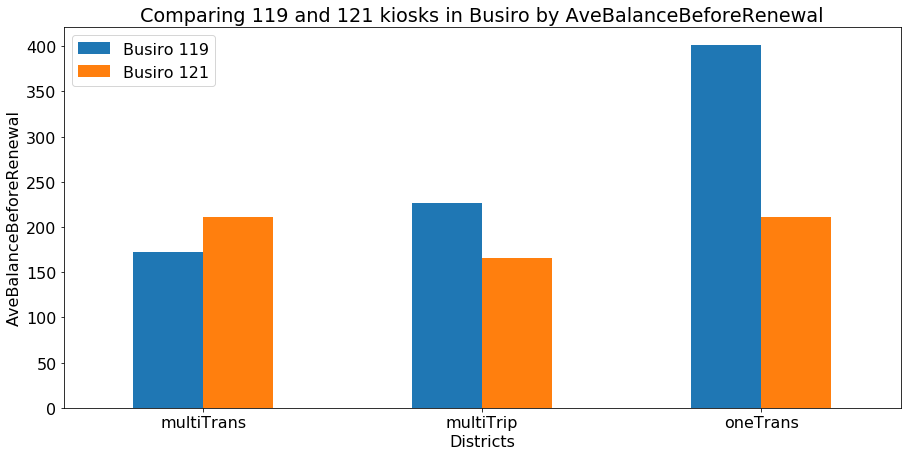

        Group  Busiro 119  Busiro 121
0  multiTrans        35.0        38.0
1   multiTrip         0.0         0.0
2    oneTrans        98.0       112.0


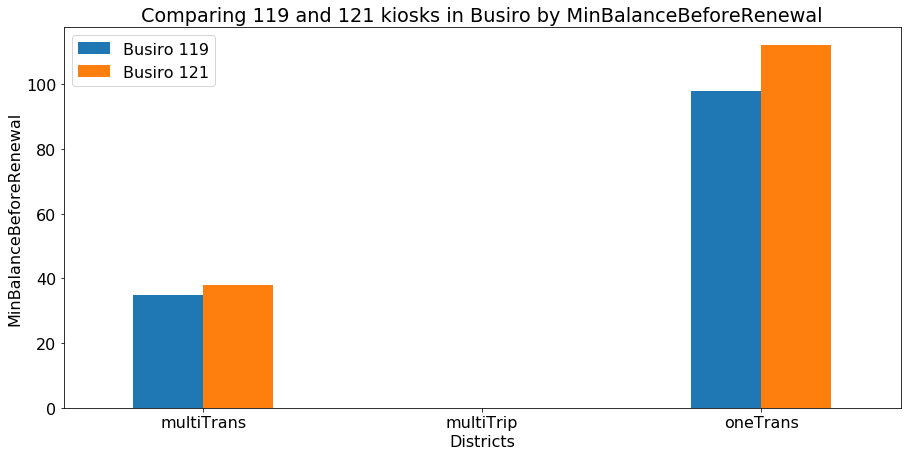

        Group  Busiro 119  Busiro 121
0  multiTrans        19.0        30.0
1   multiTrip        37.0        79.0
2    oneTrans         7.0        10.0


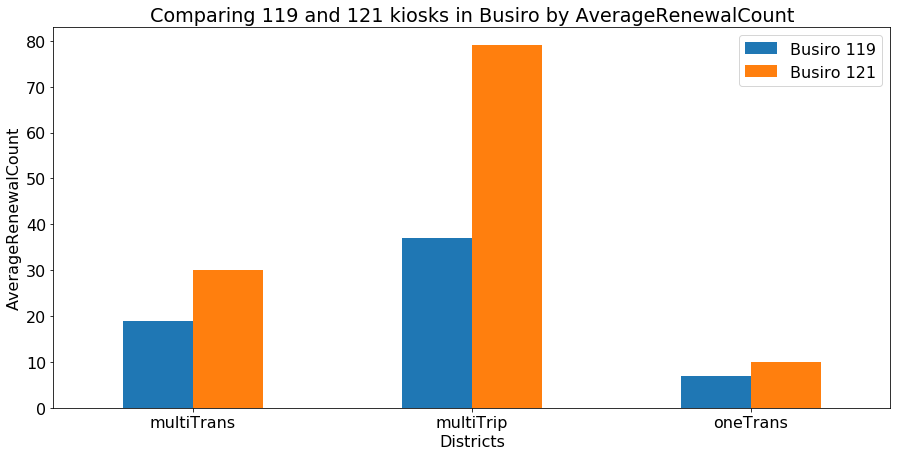

        Group  Busiro 119  Busiro 121
0  multiTrans      1064.0       967.0
1   multiTrip      1058.0       811.0
2    oneTrans      1289.0       696.0


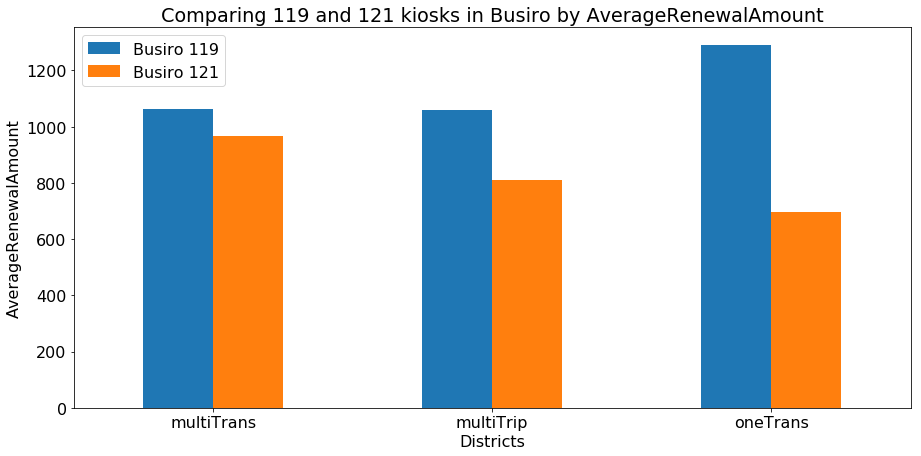

        Group  Busiro 119  Busiro 121
0  multiTrans       231.0       460.0
1   multiTrip        78.0      1667.0
2    oneTrans       523.0       409.0


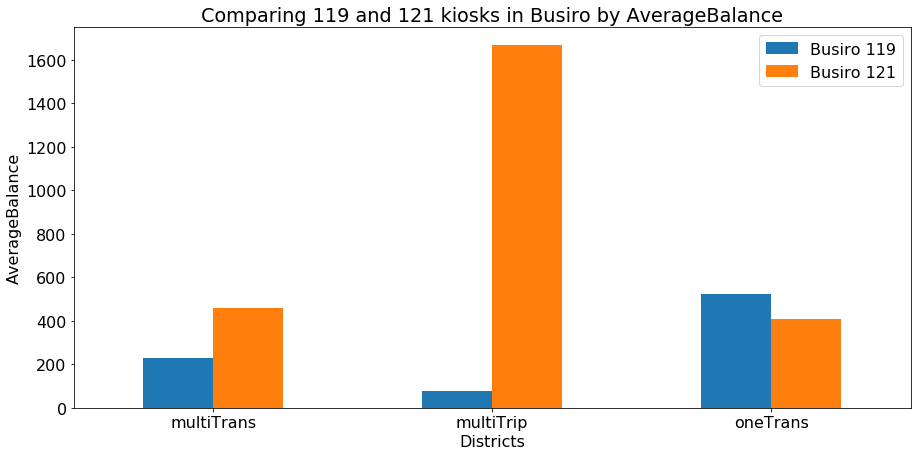

In [95]:
#@interact(index = list(resultByCardType_BusDispensers.columns)[2:])
def printNumbersOfIntervals(index):
    #index = 'AverageBalance'
    data1 = resultByCardType_BusDispensers[resultByCardType_BusDispensers.Dispenser == 'Busiro 119']
    data1.index = data1.Group
    data1 = data1[index].reset_index()
    
    data2 = resultByCardType_BusDispensers[resultByCardType_BusDispensers.Dispenser == 'Busiro 121']
    data2.index = data2.Group
    data2 = data2[index].reset_index()

    data = pd.merge(data1, data2, on = ['Group'])
    data.columns = ['Group', 'Busiro 119', 'Busiro 121']
    data.index = data.Group
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 7
    plt.rcParams["figure.figsize"] = fig_size
    
    ax = data.plot(kind='bar',title='Comparing 119 and 121 kiosks in Busiro by ' + index)
    ax.set_xlabel("Districts")
    ax.set_ylabel(index)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    
    print(data.reset_index(drop = True))
    plt.show()
    return data.reset_index(drop = True)

for index in list(resultByCardType_BusDispensers.columns)[2:]:
    printNumbersOfIntervals(index)

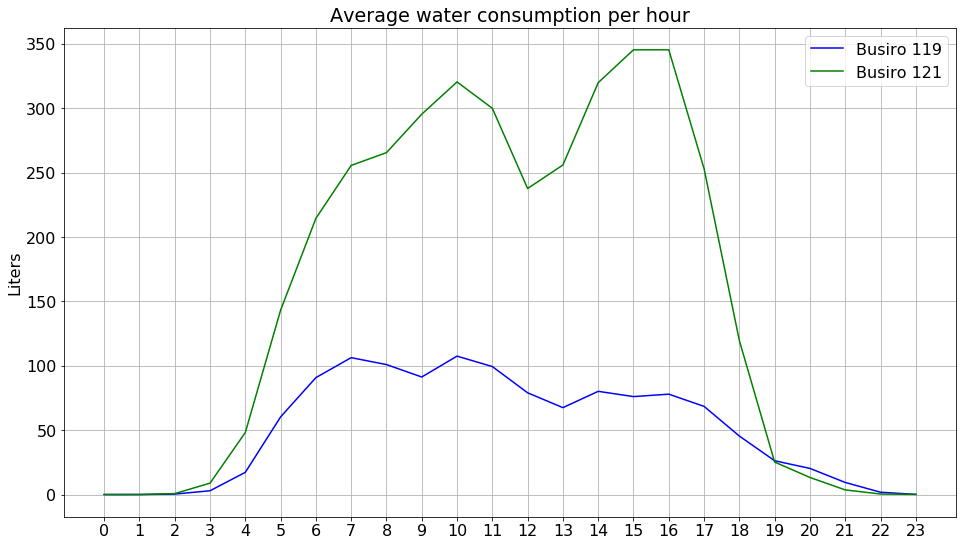

In [96]:
    x = hours.Hour
    y1 = getAverageWaterPerDayByDispenser('Busiro 119') 
    y2 = getAverageWaterPerDayByDispenser('Busiro 121') 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y1, 'b')
    plt.plot(x,y2, 'g')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ("Busiro 119", "Busiro 121") )
    plt.title('Average water consumption per hour')

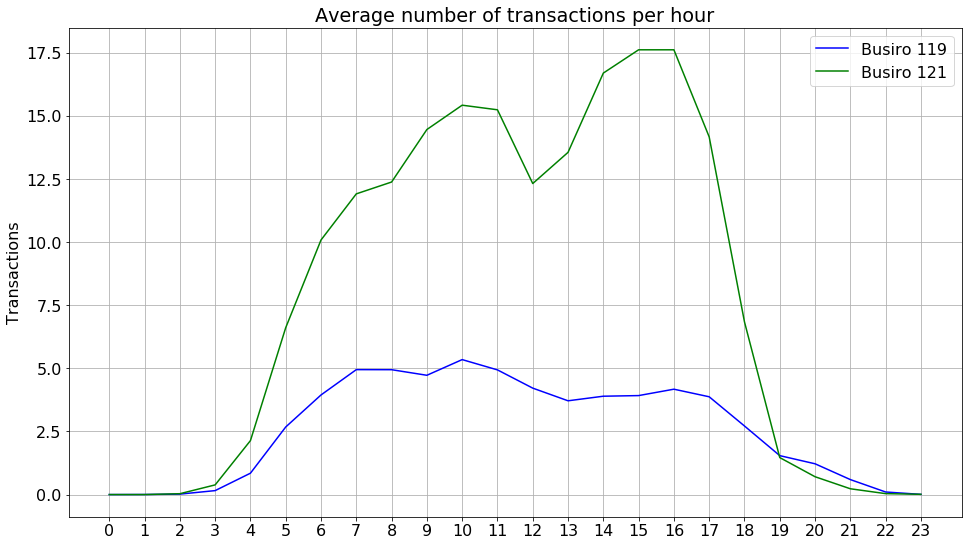

In [97]:
    x = hours.Hour
    y1 = getAverageTransactionsPerDayDispenser('Busiro 119') 
    y2 = getAverageTransactionsPerDayDispenser('Busiro 121') 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Transactions")
    
    plt.plot(x,y1, 'b')
    plt.plot(x,y2, 'g')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ("Busiro 119", "Busiro 121") )
    plt.title('Average number of transactions per hour')

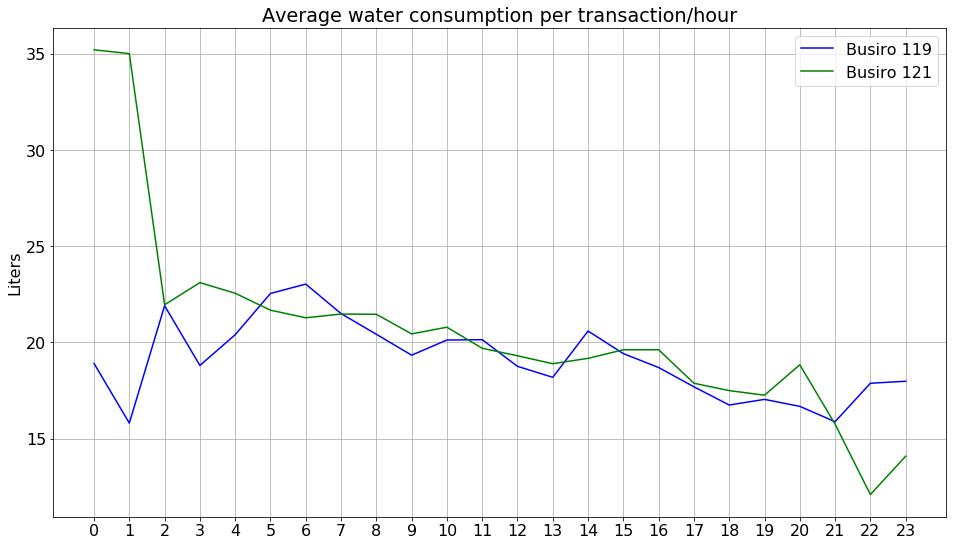

In [98]:
    x = hours.Hour
    y11 = getAverageWaterPerDayByDispenser('Busiro 119') 
    y12 = getAverageWaterPerDayByDispenser('Busiro 121') 
    y21 = getAverageTransactionsPerDayDispenser('Busiro 119') 
    y22 = getAverageTransactionsPerDayDispenser('Busiro 121') 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y11/y21, 'b')
    plt.plot(x,y12/y22, 'g')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ("Busiro 119", "Busiro 121") )
    plt.title('Average water consumption per transaction/hour')

# Section 15.1 - Comparing kiosks in Chanhumba
In this section we compare two kiosks in Busiro with general indexes from the report.

In [99]:
def loadWaterTransactionData(initial_df):
    df = initial_df.copy()
    df = df[~df['Smartcard 1'].isnull()]
    if(df['Date and time'].dtype != 'datetime64[ns]'):
        df['Date and time'] = df['Date and time'].str.slice(0,10).str.replace('-', '.')
        df['Date and time'] = pd.to_datetime(df['Date and time'], format='%d.%m.%Y')
    else:
        df['Date and time'] = df['Date and time'].dt.date
    if(df['Smartcard 1'].dtype != 'object'):
        df['Smartcard 1'] = df['Smartcard 1'].astype(int).astype(str)    
    df = df[(df['Smartcard 1'].str.contains(pattern) != True) & (df['Smartcard 1'] != '')]  
    df = df[df['Operation'] == 'Water dispensed']
    df['Smartcard 1'] = df['Smartcard 1'].astype(int)
    df = df[~df['Smartcard 1'].isin({1603, 1604, 1605, 2281, 2283, 2284, 2291, 2292, 2954})]
    df = df[['Transaction id', 'Date and time', 'Smartcard 1', 'Water dispensed', 'Credits', 'Balance', 'Operation', 'Dispenser']]
    df['year'] = pd.DatetimeIndex(df['Date and time']).year
    df['month'] = pd.DatetimeIndex(df['Date and time']).month
    df['day'] = pd.DatetimeIndex(df['Date and time']).day
    df['isoyear'] = pd.DatetimeIndex(df['Date and time']).year
    df['isoweek'] = pd.DatetimeIndex(df['Date and time']).week
    df['weekday'] = pd.DatetimeIndex(df['Date and time']).weekday
    df.columns = ['transaction', 'date', 'smartcard', 'amount', 'credits', 'balance', 'operation', 'dispenser', 'year', 'month', 'day', 'isoyear', 'isoweek', 'weekday']
    
    return df


def prepareTransactionData(initial_df):
    df = loadWaterTransactionData(initial_df)
    
    byday1 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.sum()
    byday2 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).smartcard.nunique()
    byday3 = df.groupby(['isoyear', 'isoweek', 'date', 'weekday']).amount.count()
    byday = pd.concat([byday1, byday2, byday3], axis = 1).reset_index()
    byday.columns = ['isoyear', 'isoweek', 'date', 'weekday', 'amount', 'smartcards', 'transactions'] 
    byday['amount_per_card'] = byday.amount / byday.smartcards
  
    # calc the last date
    last_date = np.max(df.date)
    card_last_day = df.groupby(['smartcard']).date.max().reset_index()
    card_last_day.columns = ['smartcard', 'last_date']
    # update last date for 'non-stopped' cards
    card_last_day['last_date'] = card_last_day['last_date'].apply(adjustDate, args=(last_date, 28))
    
    total_num = len(df.smartcard.drop_duplicates())
    pdf = byday
    # add number of non-stopped cards into dataframe
    pdf['active_cards'] = 0
    pdf['inactive_cards'] = 0
    pdf['amount_per_active_card'] = 0
    for i in pdf.index:
        row = pdf.ix[i]
        active_num = card_last_day[(card_last_day.last_date >= row.date)].smartcard.count()
        pdf.ix[i, 'active_cards'] = active_num
        pdf.ix[i, 'inactive_cards'] = total_num - active_num
        pdf.ix[i, 'amount_per_active_card'] = row.amount / active_num
    
    return pdf

def prepareDispenserTransactionData(initial_df):
    w = loadWaterTransactionData(initial_df)
    
    byday1 = w.groupby(['dispenser', 'isoyear', 'isoweek', 'date']).amount.sum()
    byday2 = w.groupby(['dispenser', 'isoyear', 'isoweek', 'date']).smartcard.nunique()
    byday3 = w.groupby(['dispenser', 'isoyear', 'isoweek', 'date']).amount.count()
    
    byday = pd.concat([byday1, byday2, byday3], axis = 1).reset_index()
            
    byday.columns = ['dispenser', 'isoyear', 'isoweek', 'date', 'amount', 'smartcards', 'transactions'] 
    byday['amount_per_card'] = byday.amount / byday.smartcards
    
    return byday.fillna(0)

In [100]:
dds2 = prepareDispenserTransactionData(waterUsageRDD_Chanhumba)

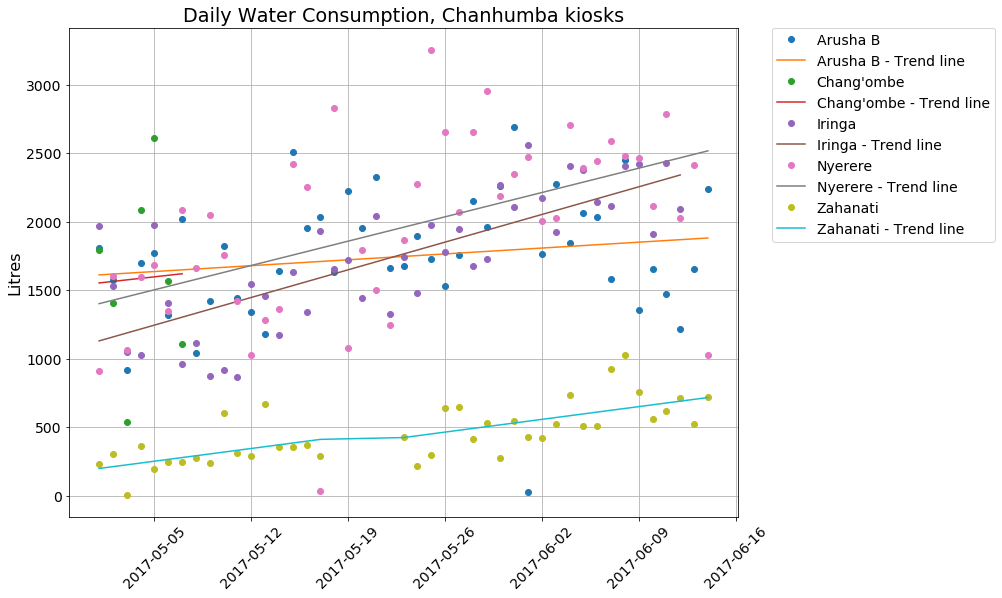

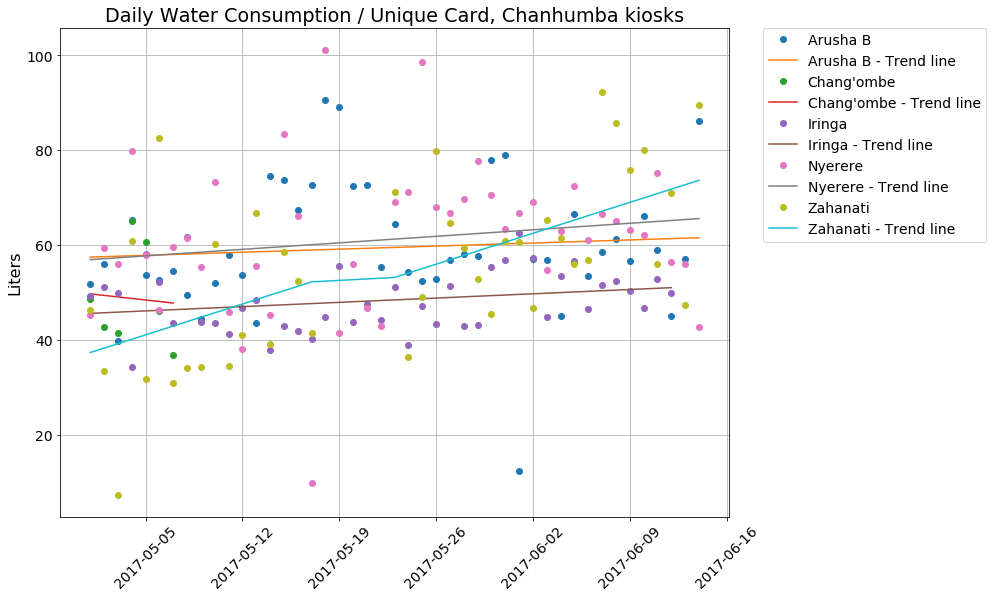

In [101]:
def showTrendsByDispensers(district, key, weeksToTrim, showPoints, showAverage):
    dsNames = list(dds2['dispenser'].drop_duplicates())
    data = dds2
    data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
    data = data.sort_values('date', ascending = True)
    #data = data[data.isoweek > 30]
   
    field = series2[key]['field']
    
    data = trimInitialWeeks(data, int(weeksToTrim))
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel(series2[key]['measure'])
    plt.xticks(rotation=90)
    #data = data[pd.to_datetime(data.date) < pd.to_datetime('2016-09-15', format='%Y-%m-%d')]
    
    legend = list()
    for name in dsNames:
        d = data[data.dispenser == name].reset_index(drop = True)
        x = d.date
        y = d[field]
        #name = name.replace('Busiro', 'Site 2, Kiosk ').replace('119', '1').replace('121', '2')
        if showPoints:
            plt.plot(x, y, 'o')
            legend.append(name)
        
        # calc the trendline
        i = x.index
        z = np.polyfit(i, y, 1)
        p = np.poly1d(z)

        t = data.index.map(lambda x: p(x))
        plt.plot(x, p(i),"-")
        legend.append(name + " - Trend line")
    
    plt.legend(legend)
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.title('Daily ' + key + ', Chanhumba kiosks')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
    plt.show()
    
series2 = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'}}

series3 = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'}}

weeksToTrim = 0
showAverage = True
showPoints = True

for i in series2:
    showTrendsByDispensers('Chanhumba', i, weeksToTrim, showPoints, showAverage)

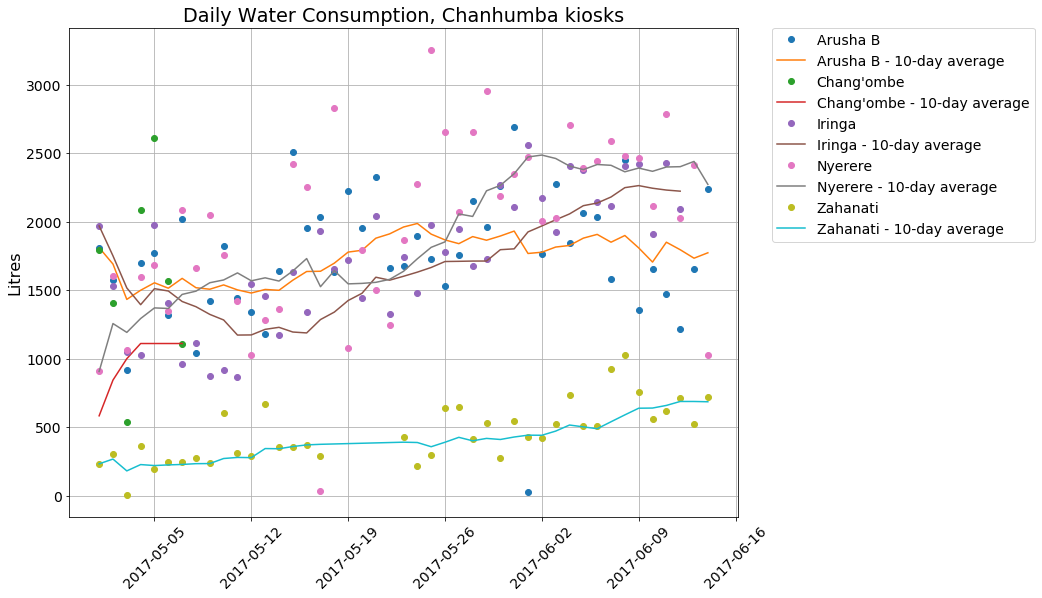

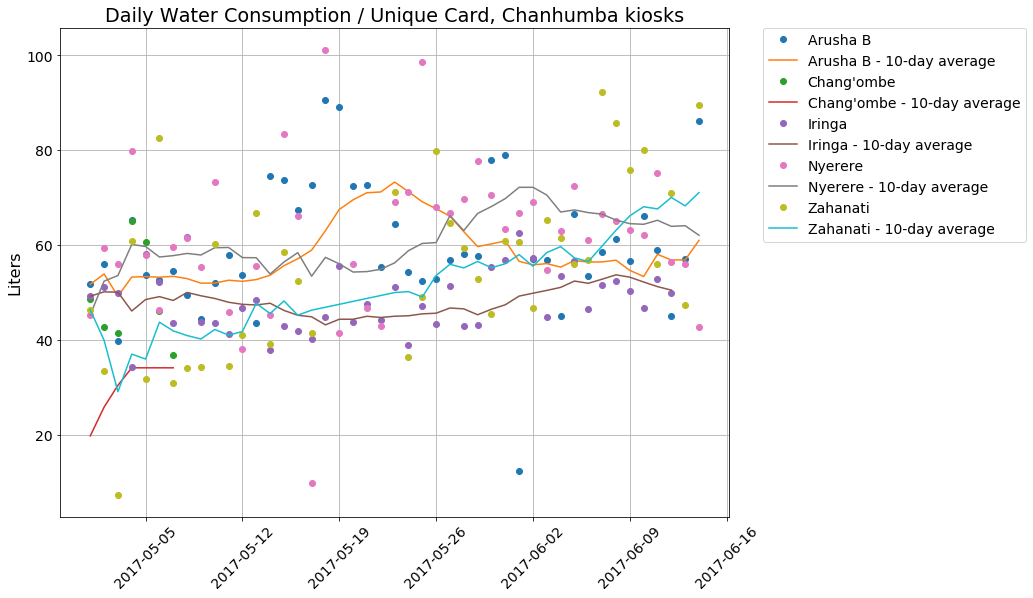

In [102]:
def showTrendsByDispensers(district, key, weeksToTrim, showPoints, showAverage):
    dsNames = list(dds2['dispenser'].drop_duplicates())
    data = dds2
    data.date =  pd.to_datetime(data.date, format='%Y-%m-%d')
    data = data.sort_values('date', ascending = True)
    #data = data[data.isoweek > 30]
   
    field = series2[key]['field']
    
    data = trimInitialWeeks(data, int(weeksToTrim))
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel(series2[key]['measure'])
    plt.xticks(rotation=90)
    #data = data[pd.to_datetime(data.date) < pd.to_datetime('2016-09-15', format='%Y-%m-%d')]
    
    legend = list()
    for name in dsNames:
        d = data[data.dispenser == name].reset_index(drop = True)
        x = d.date
        y = d[field]
        #name = name.replace('Busiro', 'Site 2, Kiosk ').replace('119', '1').replace('121', '2')
        if showPoints:
            plt.plot(x, y, 'o')
            legend.append(name)
        
        # calc 10-day average
        if showAverage:
            plt.plot(x, movingAverage(y, 10) ,"-")
            legend.append(name + " - 10-day average")

   
    plt.legend(legend)
    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.title('Daily ' + key + ', Chanhumba kiosks')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
    plt.show()
    
series2 = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'}}

series3 = {'Water Consumption':{'field':'amount', 'measure':'Litres'},
          'Number of Transactions':{'field':'transactions', 'measure':'Transactions'},
          'Number of Unique Cards':{'field':'smartcards', 'measure':'Unique cards'},
          'Water Consumption / Unique Card':{'field':'amount_per_card', 'measure':'Liters'}}

weeksToTrim = 0
showAverage = True
showPoints = True

for i in series2:
    showTrendsByDispensers('Chanhumba', i, weeksToTrim, showPoints, showAverage)

Number of smartcards
Dispenser                       
Arusha B                      91
Chang'ombe                    68
Iringa                        64
Nyerere                       60
Zahanati                      28
2 kiosks                      53
3 kiosks                       2
4 kiosks                       0
5 kiosks                       1

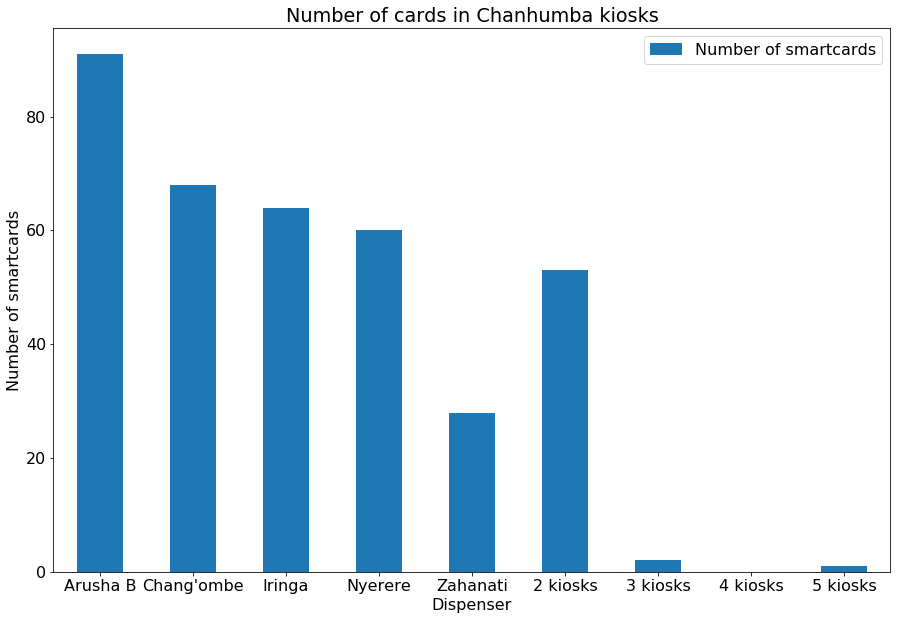

In [103]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

cn_df = resultset[resultset.District == 'Chanhumba'][['Dispenser','Smartcard_1']].drop_duplicates()
cn_df_group = cn_df.groupby(['Smartcard_1']).Dispenser.count().reset_index()
cn_df_2 = cn_df_group[cn_df_group.Dispenser == 2]
two_disp = len(cn_df_2)
cn_df_3 = cn_df_group[cn_df_group.Dispenser == 3]
three_disp = len(cn_df_3)
cn_df_4 = cn_df_group[cn_df_group.Dispenser == 4]
four_disp = len(cn_df_4)
cn_df_5 = cn_df_group[cn_df_group.Dispenser == 5]
five_disp = len(cn_df_5)

cn_df = cn_df[~cn_df.Smartcard_1.isin(list(cn_df_group[cn_df_group.Dispenser > 1].Smartcard_1))]
cn_df = cn_df.groupby(['Dispenser']).Smartcard_1.count().reset_index()
cn_df = cn_df.append([{'Dispenser':'2 kiosks', 'Smartcard_1' : two_disp}]).append([{'Dispenser':'3 kiosks', 'Smartcard_1' : three_disp}])
cn_df = cn_df.append([{'Dispenser':'4 kiosks', 'Smartcard_1' : four_disp}]).append([{'Dispenser':'5 kiosks', 'Smartcard_1' : five_disp}])
cn_df.index = cn_df.Dispenser
cn_df = cn_df.drop(['Dispenser'], axis = 1)
cn_df.columns = ['Number of smartcards']
ax = cn_df.plot(kind='bar',title='Number of cards in Chanhumba kiosks');
ax.set_ylabel("Number of smartcards")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)

cn_df



Dispenser  Transaction_id
0    Arusha B            4147
1  Chang'ombe             615
2      Iringa            3715
3     Nyerere            3823
4    Zahanati            1104

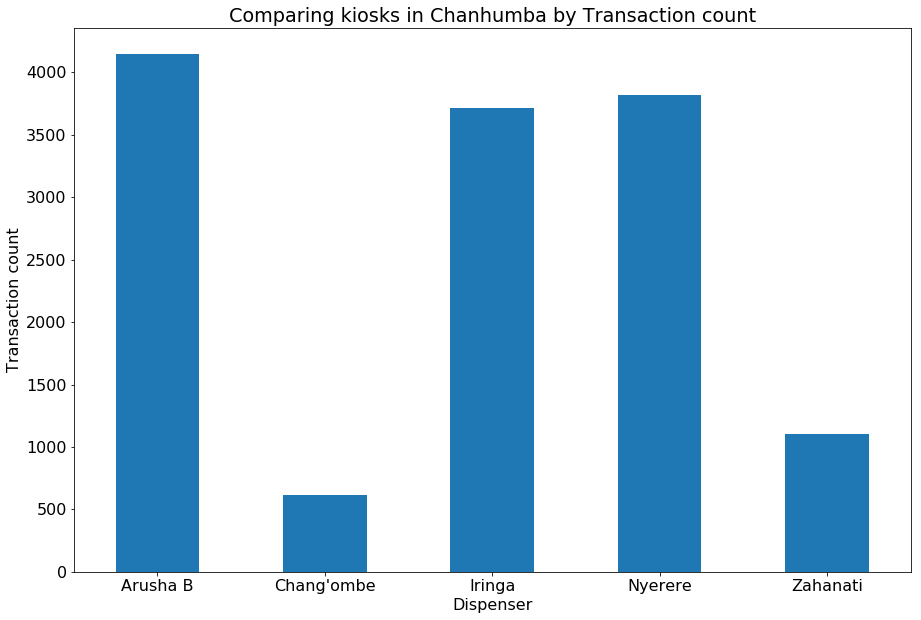

In [104]:
def chartTransactionNumbersOfBusiroDispensers():
    d1 = resultset[resultset.District == 'Chanhumba']
    d1 = d1[['Dispenser', 'Smartcard_1', 'Transaction_id']].groupby(['Dispenser'])['Transaction_id'].count()
    ax = d1.plot(kind='bar',title='Comparing kiosks in Chanhumba by Transaction count');
    ax.set_ylabel("Transaction count")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)

    return d1.reset_index()

chartTransactionNumbersOfBusiroDispensers()

    Dispenser  Water_dispensed_Mean
0    Arusha B             18.235976
1  Chang'ombe             23.121631
2      Iringa             22.927930
3     Nyerere             23.123288
4    Zahanati             16.336695


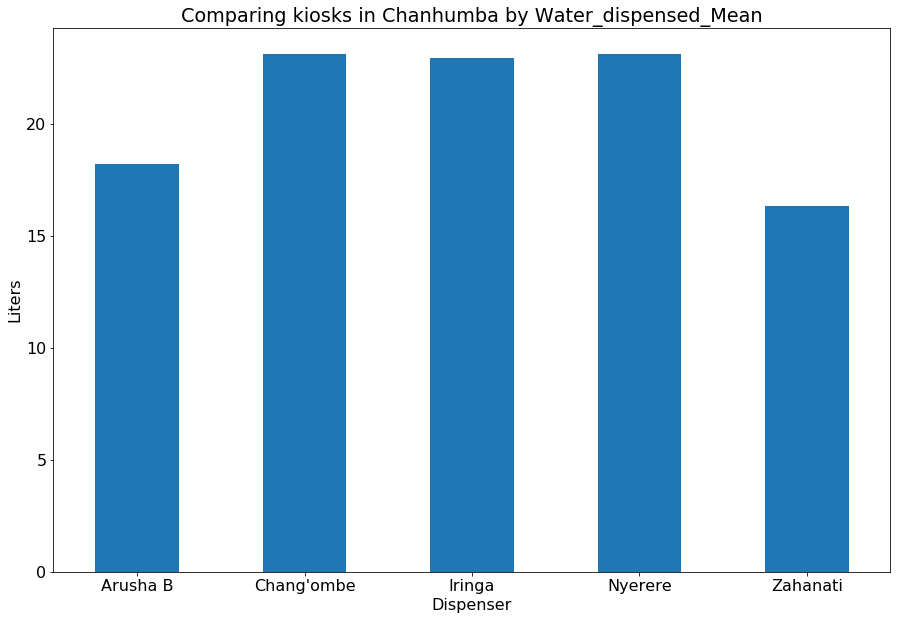

    Dispenser  Balance_Before_Credit_Mean
0    Arusha B                  159.085185
1  Chang'ombe                   60.784722
2      Iringa                  403.501740
3     Nyerere                   42.397073
4    Zahanati                  271.910505


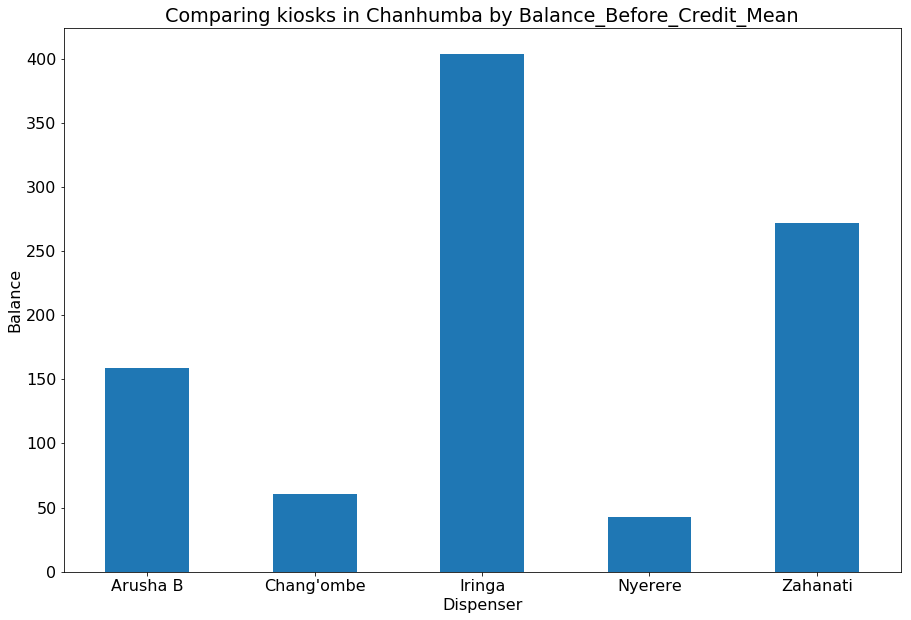

    Dispenser  Balance_Before_Credit_Min
0    Arusha B                  82.643750
1  Chang'ombe                  19.916667
2      Iringa                  10.709036
3     Nyerere                   2.338194
4    Zahanati                 193.684211


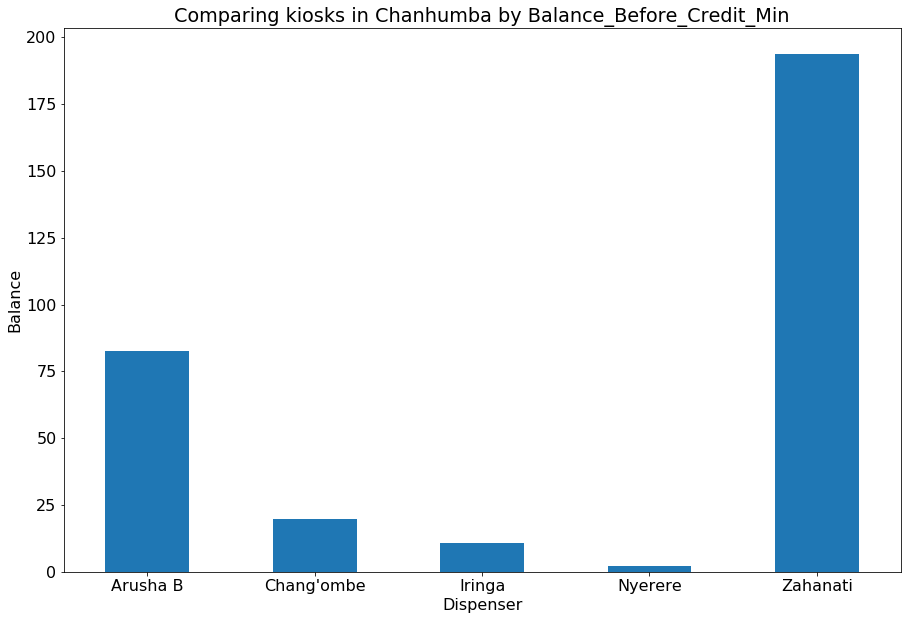

    Dispenser  Credits_Add
0    Arusha B     4.083333
1  Chang'ombe     2.444444
2      Iringa     3.590361
3     Nyerere     3.888889
4    Zahanati     3.210526


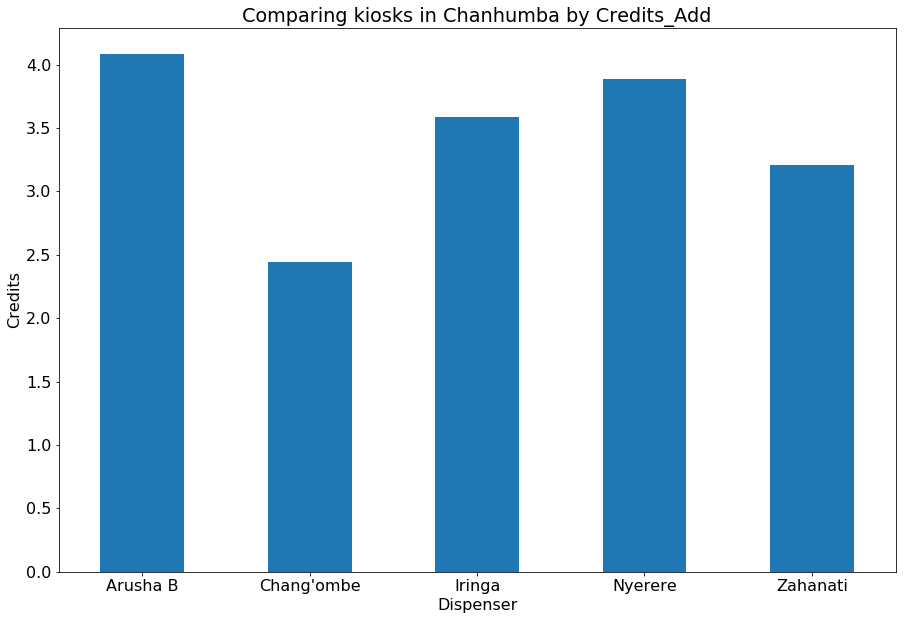

    Dispenser  Add_Credits_Mean
0    Arusha B        961.411723
1  Chang'ombe        682.869444
2      Iringa       1567.890700
3     Nyerere        820.384967
4    Zahanati       1502.557331


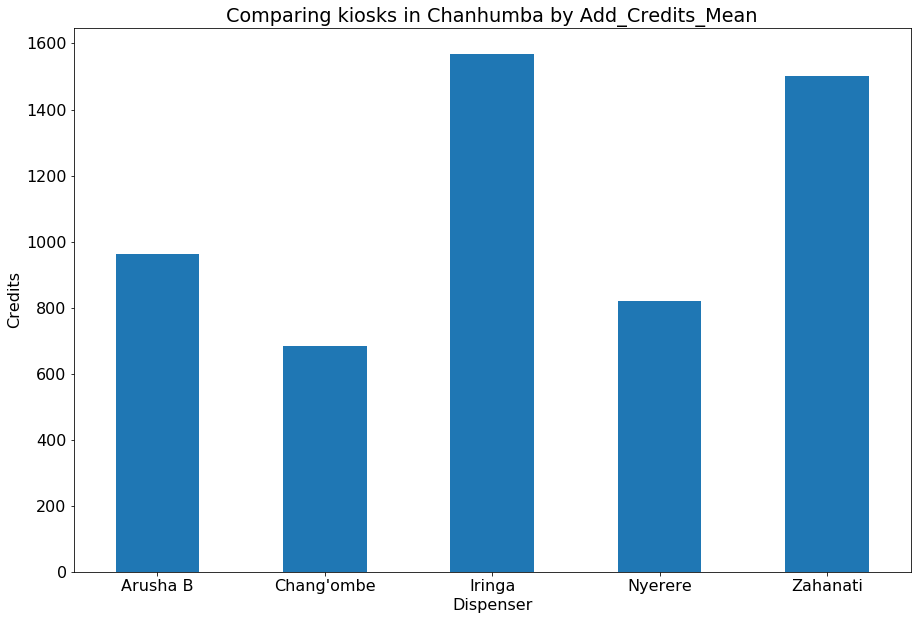

    Dispenser   LastBalance
0    Arusha B   7077.861009
1  Chang'ombe   5012.530000
2      Iringa   3312.512500
3     Nyerere   3769.045098
4    Zahanati  18391.139706


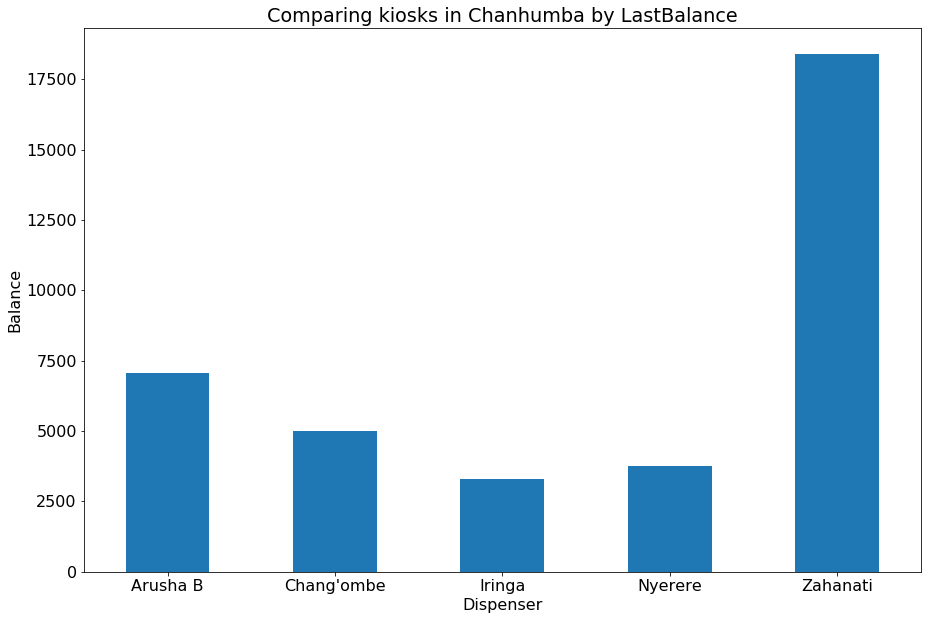

In [105]:
#@interact(ind = ['Water_dispensed_Mean', 'Balance_Before_Credit_Mean','Balance_Before_Credit_Min', 'Credits_Add', 'Add_Credits_Mean', 'LastBalance'])
def printNumbersOfIntervals(ind):
    d1 = resultset[resultset.District == 'Chanhumba']
    d1 = d1[['Dispenser', 'Smartcard_1', ind]].drop_duplicates().groupby(['Dispenser'])[ind].mean()
    ax = d1.plot(kind='bar',title='Comparing kiosks in Chanhumba by ' + ind)
    y_label = 'Balance'
    if(ind == 'Water_dispensed_Mean'):
        y_label = 'Liters'
    elif(ind == 'Credits_Add'):
        y_label = 'Credits'
    elif(ind == 'Add_Credits_Mean'):
        y_label = 'Credits'

    ax.set_ylabel(y_label)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    
    print(d1.reset_index())
    plt.show()
    return d1.reset_index()

for ind in ['Water_dispensed_Mean', 'Balance_Before_Credit_Mean','Balance_Before_Credit_Min', 'Credits_Add', 
            'Add_Credits_Mean', 'LastBalance']:
    printNumbersOfIntervals(ind)

In [106]:
groupAnalyzisBusiroDispensers = pd.merge(resultset[resultset.District == 'Chanhumba'], timeDiffDF_byCard[['District', 'Smartcard_1', 'Group']], on = ['District', 'Smartcard_1'])
groupAnalyzisBusiroDispensers = groupAnalyzisBusiroDispensers[['Date', 'Date_and_time', 'District', 'Dispenser', 'Smartcard_1', 'Water_dispensed', 'Credits',
       'Balance', 'Credits_Add', 'Add_Credits_Mean',
       'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean',
       'Transaction_Count', 'Water_dispensed_Mean', 'LastBalance', 'Group']]
groupAnalyzisBusiroDispensers.head()

Date       Date_and_time   District Dispenser Smartcard_1  \
0 2017-05-08 2017-05-08 06:55:18  Chanhumba    Iringa       15694   
1 2017-05-09 2017-05-09 06:40:11  Chanhumba    Iringa       15694   
2 2017-05-09 2017-05-09 18:46:12  Chanhumba    Iringa       15694   
3 2017-05-11 2017-05-11 07:33:09  Chanhumba    Iringa       15694   
4 2017-05-13 2017-05-13 16:44:57  Chanhumba    Iringa       15694   

   Water_dispensed  Credits   Balance  Credits_Add  Add_Credits_Mean  \
0             16.3    40.75  59370.25          NaN               NaN   
1             42.6   106.50  59263.75          NaN               NaN   
2             38.5    96.25  59167.50          NaN               NaN   
3             21.2    53.00  59114.50          NaN               NaN   
4             19.9    49.75  58064.75          NaN               NaN   

   Balance_Before_Credit_Min  Balance_Before_Credit_Mean  Transaction_Count  \
0                        NaN                         NaN                 75   
1                        NaN                         NaN                 75   
2                        NaN                         NaN                 75   
3                        NaN                         NaN                 75   
4                        NaN                         NaN                 75   

   Water_dispensed_Mean  LastBalance       Group  
0             16.694667        13.75  multiTrans  
1             16.694667        13.75  multiTrans  
2             16.694667        13.75  multiTrans  
3             16.694667        13.75  multiTrans  
4             16.694667        13.75  multiTrans

In [107]:
transCout2 = groupAnalyzisBusiroDispensers.groupby(['Dispenser',  'Group']).Date_and_time.count().reset_index()
transCout2.columns = ['Dispenser',  'Group', 'TransactionCount']
transCout2 = transCout2.set_index(['Dispenser',  'Group'])

watDispensed2 = groupAnalyzisBusiroDispensers.groupby(['Dispenser',  'Group']).Water_dispensed.mean().reset_index()
watDispensed2.columns = ['Dispenser',  'Group', 'Water_dispensed_mean']
watDispensed2 = watDispensed2.set_index(['Dispenser',  'Group'])

tempGroup2 = groupAnalyzisBusiroDispensers[['Dispenser',  'Group', 'Smartcard_1', 'Credits_Add', 'Add_Credits_Mean', 'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean',
       'Transaction_Count', 'Water_dispensed_Mean', 'LastBalance']].drop_duplicates()

cardCout2 = tempGroup2.groupby(['Dispenser',  'Group']).Smartcard_1.count().reset_index()
cardCout2.columns = ['Dispenser',  'Group', 'cardCount']
cardCout2 = cardCout2.set_index(['Dispenser',  'Group'])


cardNumbersByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Smartcard_1.count().reset_index()
cardNumbersByCardType2.columns = ['Dispenser',  'Group', 'CardNumbers']
cardNumbersByCardType2 = cardNumbersByCardType2.set_index(['Dispenser',  'Group'])

averageBalanceByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).LastBalance.mean().reset_index()
averageBalanceByCardType2.columns = ['Dispenser',  'Group', 'AverageBalance']
averageBalanceByCardType2.AverageBalance  = averageBalanceByCardType2.AverageBalance.apply(np.round)
averageBalanceByCardType2 = averageBalanceByCardType2.set_index(['Dispenser',  'Group'])

averageNumberOfRenewalsByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Credits_Add.mean().reset_index()
averageNumberOfRenewalsByCardType2.columns = ['Dispenser',  'Group', 'AverageRenewalCount']
averageNumberOfRenewalsByCardType2.AverageRenewalCount  = averageNumberOfRenewalsByCardType2.AverageRenewalCount.apply(np.round)
averageNumberOfRenewalsByCardType2 = averageNumberOfRenewalsByCardType2.set_index(['Dispenser',  'Group'])

averageAmountOfRenewalsByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Add_Credits_Mean.mean().reset_index()
averageAmountOfRenewalsByCardType2.columns = ['Dispenser',  'Group', 'AverageRenewalAmount']
averageAmountOfRenewalsByCardType2.AverageRenewalAmount  = averageAmountOfRenewalsByCardType2.AverageRenewalAmount.apply(np.round)
averageAmountOfRenewalsByCardType2 = averageAmountOfRenewalsByCardType2.set_index(['Dispenser',  'Group'])

balanceBeforeRenewalByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Balance_Before_Credit_Min.mean().reset_index()
balanceBeforeRenewalByCardType2.columns = ['Dispenser',  'Group', 'MinBalanceBeforeRenewal']
balanceBeforeRenewalByCardType2.MinBalanceBeforeRenewal  = balanceBeforeRenewalByCardType2.MinBalanceBeforeRenewal.apply(np.round)
balanceBeforeRenewalByCardType2 = balanceBeforeRenewalByCardType2.set_index(['Dispenser',  'Group'])

averageBalanceBeforeRenewalByCardType2 = tempGroup2.groupby(['Dispenser',  'Group']).Balance_Before_Credit_Mean.mean().reset_index()
averageBalanceBeforeRenewalByCardType2.columns = ['Dispenser',  'Group', 'AveBalanceBeforeRenewal']
averageBalanceBeforeRenewalByCardType2.AveBalanceBeforeRenewal  = averageBalanceBeforeRenewalByCardType2.AveBalanceBeforeRenewal.apply(np.round)
averageBalanceBeforeRenewalByCardType2 = averageBalanceBeforeRenewalByCardType2.set_index(['Dispenser',  'Group'])

resultByCardType_BusDispensers = pd.concat([cardCout2, transCout2, watDispensed2, averageBalanceBeforeRenewalByCardType2, balanceBeforeRenewalByCardType2, averageNumberOfRenewalsByCardType2
                    , averageAmountOfRenewalsByCardType2, averageBalanceByCardType2], axis=1)
resultByCardType_BusDispensers = resultByCardType_BusDispensers.reset_index()
resultByCardType_BusDispensers.columns = ['Dispenser',  'Group', 'CardCount', 'TransactionCount', 'Water_dispensed_mean', 'AveBalanceBeforeRenewal', 'MinBalanceBeforeRenewal', 'AverageRenewalCount', 
                            'AverageRenewalAmount', 'AverageBalance']
resultByCardType_BusDispensers = resultByCardType_BusDispensers[['Dispenser',  'Group', 'CardCount', 'TransactionCount', 'Water_dispensed_mean', 'AveBalanceBeforeRenewal', 'MinBalanceBeforeRenewal', 'AverageRenewalCount', 
                            'AverageRenewalAmount', 'AverageBalance']]
resultByCardType_BusDispensers = resultByCardType_BusDispensers[(resultByCardType_BusDispensers.Group != 'NA') & (resultByCardType_BusDispensers.Group != 'Creditor')]
resultByCardType_BusDispensers.head()

Dispenser       Group  CardCount  TransactionCount  Water_dispensed_mean  \
1    Arusha B  multiTrans         85              3915             19.047586   
2    Arusha B   multiTrip          7                71             18.311268   
3    Arusha B    oneTrans         15                97             17.554639   
5  Chang'ombe  multiTrans         45               471             15.028238   
6  Chang'ombe   multiTrip          6                37             23.072973   

   AveBalanceBeforeRenewal  MinBalanceBeforeRenewal  AverageRenewalCount  \
1                    154.0                     87.0                  4.0   
2                    105.0                      0.0                  5.0   
3                    291.0                     87.0                  2.0   
5                     49.0                     12.0                  3.0   
6                    143.0                      0.0                  2.0   

   AverageRenewalAmount  AverageBalance  
1                1023.0          1883.0  
2                 713.0         86372.0  
3                 662.0           440.0  
5                 780.0           697.0  
6                 746.0         54241.0

        Group  Nyerere  Zahanati  Arusha B  Iringa  Chang'ombe
0  multiTrans       80        17        85      77          45
1   multiTrip        9         5         7      11           6
2    oneTrans       10        10        15      17          17


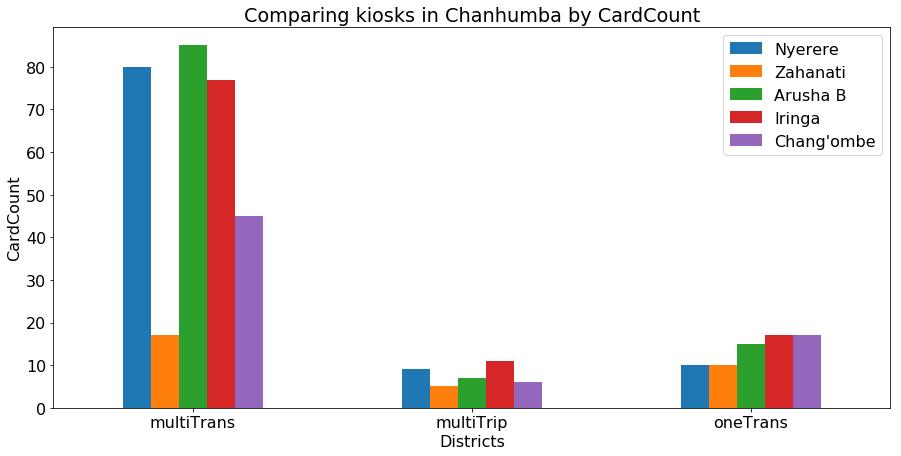

        Group  Nyerere  Zahanati  Arusha B  Iringa  Chang'ombe
0  multiTrans     3439       730      3915    2685         471
1   multiTrip      237       279        71     683          37
2    oneTrans       88        18        97     250          63


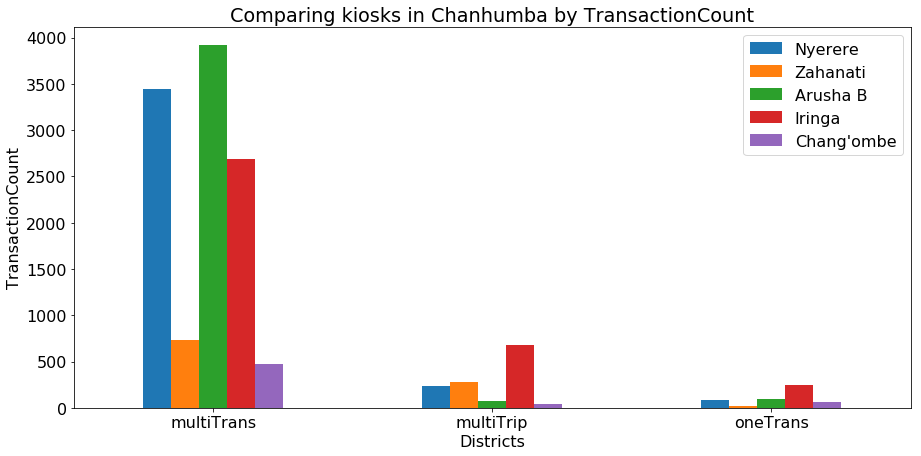

        Group    Nyerere   Zahanati   Arusha B     Iringa  Chang'ombe
0  multiTrans  22.918087  15.591096  19.047586  19.933333   15.028238
1   multiTrip  23.424473  18.234409  18.311268  16.647877   23.072973
2    oneTrans  26.877273  14.622222  17.554639  30.109200   30.852381


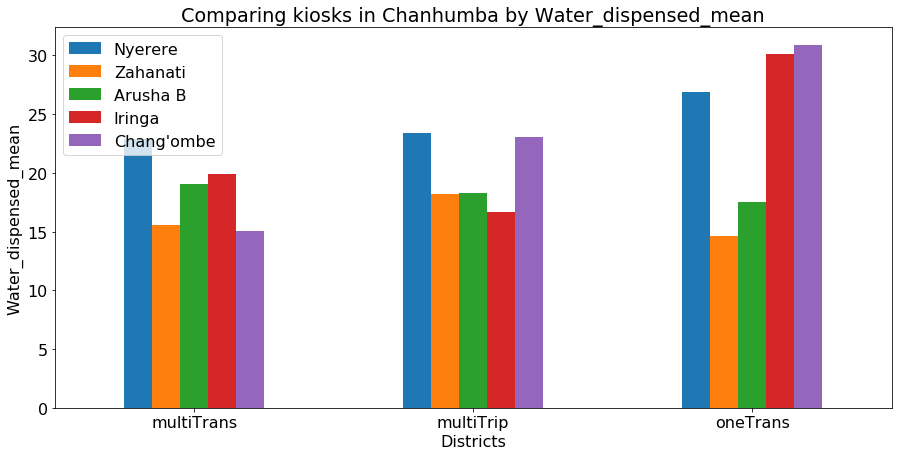

        Group  Nyerere  Zahanati  Arusha B  Iringa  Chang'ombe
0  multiTrans     45.0     365.0     154.0   531.0        49.0
1   multiTrip     48.0      44.0     105.0    37.0       143.0
2    oneTrans     27.0     337.0     291.0    22.0         1.0


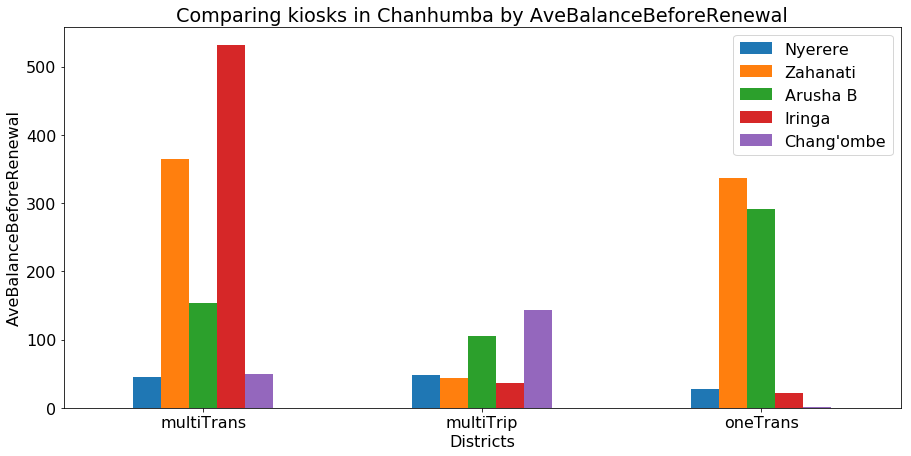

        Group  Nyerere  Zahanati  Arusha B  Iringa  Chang'ombe
0  multiTrans      3.0     333.0      87.0    14.0        12.0
1   multiTrip      0.0       1.0       0.0     1.0         0.0
2    oneTrans      1.0       6.0      87.0     1.0         1.0


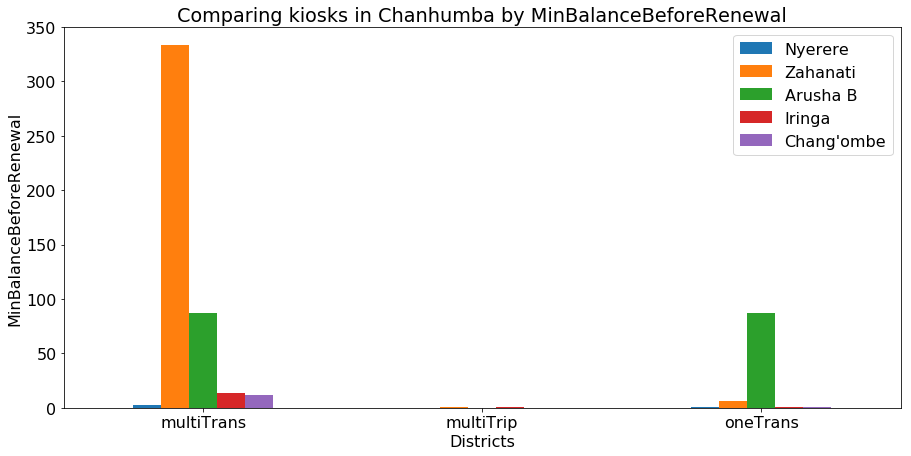

        Group  Nyerere  Zahanati  Arusha B  Iringa  Chang'ombe
0  multiTrans      4.0       4.0       4.0     4.0         3.0
1   multiTrip      7.0       3.0       5.0     6.0         2.0
2    oneTrans      3.0       1.0       2.0     2.0         1.0


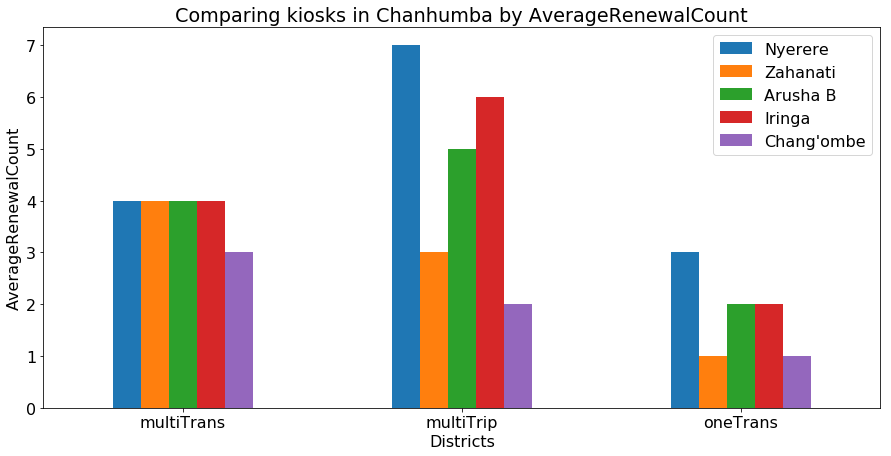

        Group  Nyerere  Zahanati  Arusha B  Iringa  Chang'ombe
0  multiTrans    836.0    1309.0    1023.0  1850.0       780.0
1   multiTrip    595.0    3800.0     713.0   649.0       746.0
2    oneTrans    872.0     373.0     662.0   787.0       500.0


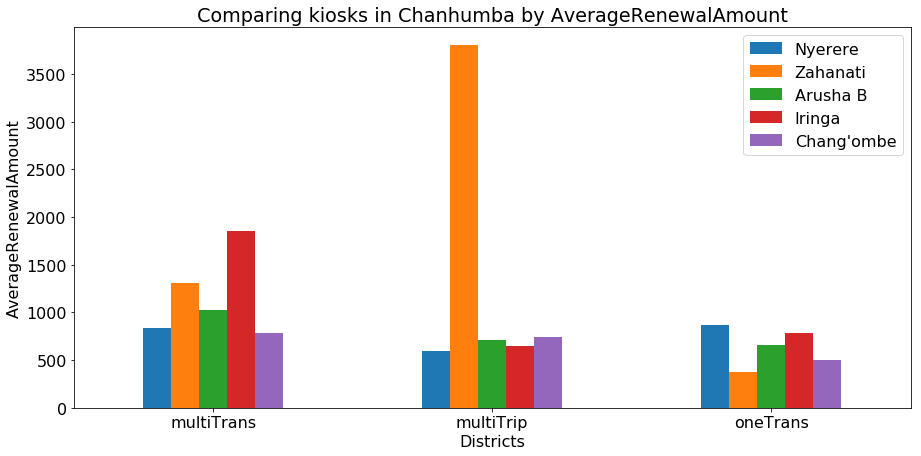

        Group  Nyerere  Zahanati  Arusha B   Iringa  Chang'ombe
0  multiTrans   2209.0     589.0    1883.0   1918.0       697.0
1   multiTrip  22652.0  122000.0   86372.0  18484.0     54241.0
2    oneTrans    247.0     447.0     440.0    355.0       881.0


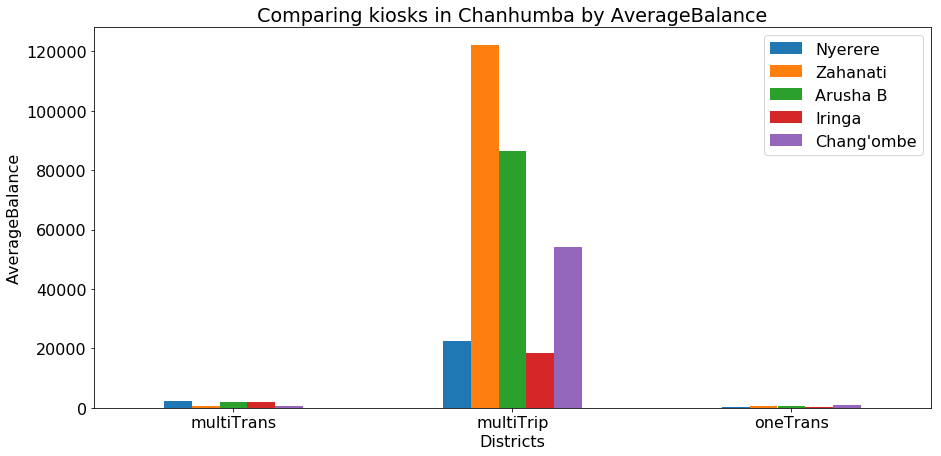

In [108]:
#@interact(index = list(resultByCardType_BusDispensers.columns)[2:])
def printNumbersOfIntervals(index): 
    #index = 'AverageBalance'
    data1 = resultByCardType_BusDispensers[resultByCardType_BusDispensers.Dispenser == 'Nyerere']
    data1.index = data1.Group
    data1 = data1[index].reset_index()
    
    data2 = resultByCardType_BusDispensers[resultByCardType_BusDispensers.Dispenser == 'Zahanati']
    data2.index = data2.Group
    data2 = data2[index].reset_index()

    data3 = resultByCardType_BusDispensers[resultByCardType_BusDispensers.Dispenser == 'Arusha B']
    data3.index = data3.Group
    data3 = data3[index].reset_index()

    data4 = resultByCardType_BusDispensers[resultByCardType_BusDispensers.Dispenser == 'Iringa']
    data4.index = data4.Group
    data4 = data4[index].reset_index()

    data5 = resultByCardType_BusDispensers[resultByCardType_BusDispensers.Dispenser == "Chang'ombe"]
    data5.index = data5.Group
    data5 = data5[index].reset_index()

    data = pd.merge(data1, data2, on = ['Group'])
    data = pd.merge(data, data3, on = ['Group'])
    data = pd.merge(data, data4, on = ['Group'])
    data = pd.merge(data, data5, on = ['Group'])
    data.columns = ['Group', 'Nyerere', 'Zahanati', 'Arusha B', 'Iringa', "Chang'ombe"]
    data.index = data.Group
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 7
    plt.rcParams["figure.figsize"] = fig_size
    
    ax = data.plot(kind='bar',title='Comparing kiosks in Chanhumba by ' + index)
    ax.set_xlabel("Districts")
    ax.set_ylabel(index)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    
    print(data.reset_index(drop = True))
    plt.show()
    return data.reset_index(drop = True)

for index in list(resultByCardType_BusDispensers.columns)[2:]:
    printNumbersOfIntervals(index)

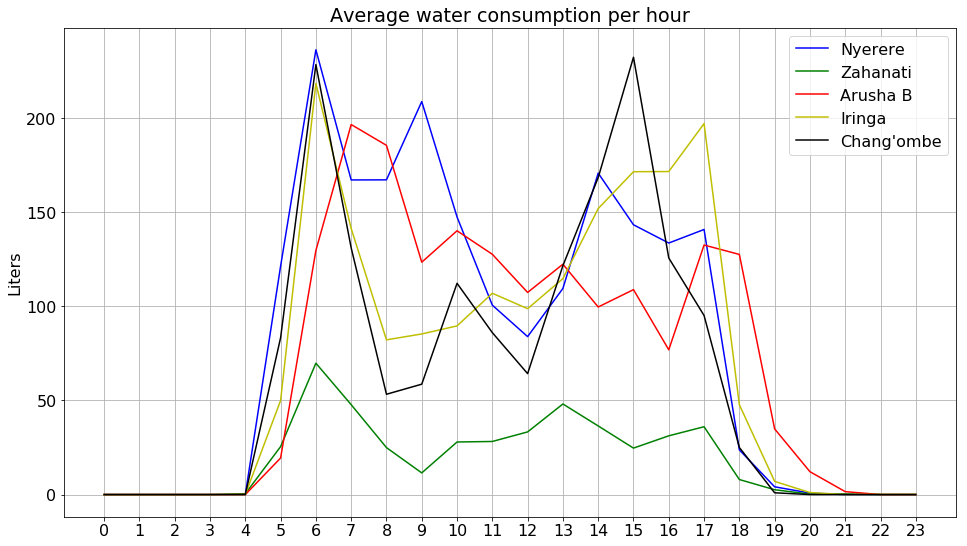

In [109]:
    x = hours.Hour 
    y1 = getAverageWaterPerDayByDispenser('Nyerere') 
    y2 = getAverageWaterPerDayByDispenser('Zahanati') 
    y3 = getAverageWaterPerDayByDispenser('Arusha B') 
    y4 = getAverageWaterPerDayByDispenser('Iringa') 
    y5 = getAverageWaterPerDayByDispenser("Chang'ombe") 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y1, 'b')
    plt.plot(x,y2, 'g')
    plt.plot(x,y3, 'r')
    plt.plot(x,y4, 'y')
    plt.plot(x,y5, 'black')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ('Nyerere', 'Zahanati', 'Arusha B', 'Iringa', "Chang'ombe") )
    plt.title('Average water consumption per hour')

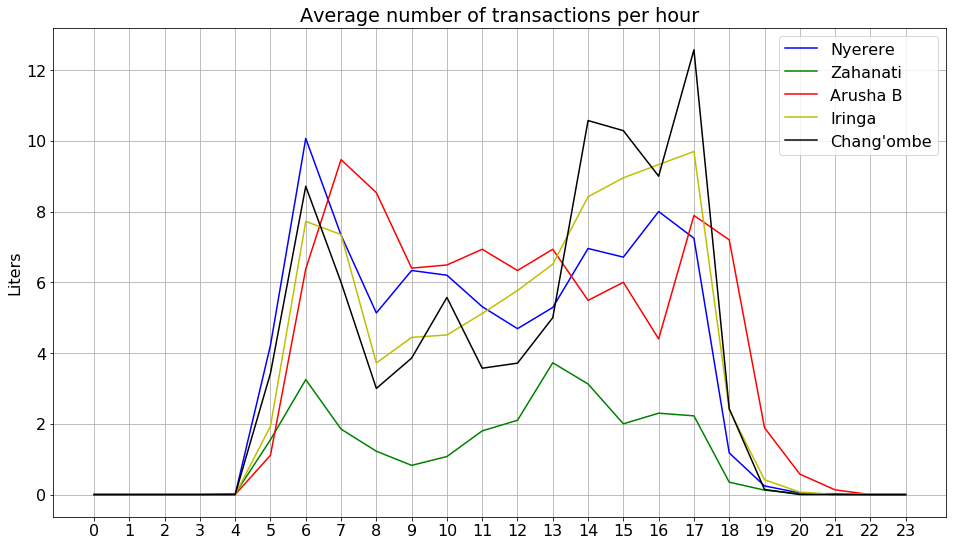

In [110]:
    x = hours.Hour 
    y1 = getAverageTransactionsPerDayDispenser('Nyerere') 
    y2 = getAverageTransactionsPerDayDispenser('Zahanati') 
    y3 = getAverageTransactionsPerDayDispenser('Arusha B') 
    y4 = getAverageTransactionsPerDayDispenser('Iringa') 
    y5 = getAverageTransactionsPerDayDispenser("Chang'ombe") 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y1, 'b')
    plt.plot(x,y2, 'g')
    plt.plot(x,y3, 'r')
    plt.plot(x,y4, 'y')
    plt.plot(x,y5, 'black')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ('Nyerere', 'Zahanati', 'Arusha B', 'Iringa', "Chang'ombe") )
    plt.title('Average number of transactions per hour')

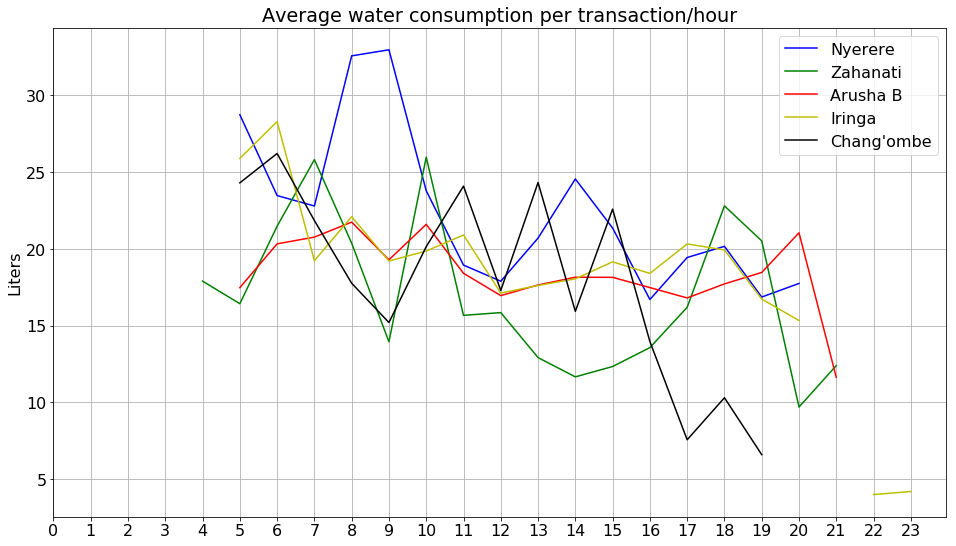

In [111]:
    x = hours.Hour 
    y11 = getAverageWaterPerDayByDispenser('Nyerere') 
    y12 = getAverageWaterPerDayByDispenser('Zahanati') 
    y13 = getAverageWaterPerDayByDispenser('Arusha B') 
    y14 = getAverageWaterPerDayByDispenser('Iringa') 
    y15 = getAverageWaterPerDayByDispenser("Chang'ombe") 

    y21 = getAverageTransactionsPerDayDispenser('Nyerere') 
    y22 = getAverageTransactionsPerDayDispenser('Zahanati') 
    y23 = getAverageTransactionsPerDayDispenser('Arusha B') 
    y24 = getAverageTransactionsPerDayDispenser('Iringa') 
    y25 = getAverageTransactionsPerDayDispenser("Chang'ombe") 

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    ax = plt.axes()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel("Liters")
    
    plt.plot(x,y11/y21, 'b')
    plt.plot(x,y12/y22, 'g')
    plt.plot(x,y13/y23, 'r')
    plt.plot(x,y14/y24, 'y')
    plt.plot(x,y15/y25, 'black')
 
    plt.xticks(np.arange(0, 24, 1.0))
    ax.xaxis.set_ticklabels(np.arange(24))
    
    plt.legend ( ('Nyerere', 'Zahanati', 'Arusha B', 'Iringa', "Chang'ombe") )
    plt.title('Average water consumption per transaction/hour')